In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math as math
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
# Download the dataset
dataframe = pd.read_csv('/content/AllHeartRatedata_new_and_improved.csv', header=None)
dataframe

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
1,118.0,102.0,114.0,138.0,99.0,75.0,108.0,64.0,91.0,90.0,...,189.0,120.0,181.0,128.0,189.0,99.0,179.0,112.0,184.0,116.0
2,120.0,107.0,115.0,138.0,102.0,77.0,114.0,63.0,90.0,89.0,...,189.0,120.0,179.0,130.0,190.0,100.0,177.0,114.0,183.0,117.0
3,123.0,112.0,123.0,137.0,103.0,81.0,116.0,62.0,89.0,90.0,...,187.0,122.0,178.0,132.0,189.0,102.0,176.0,116.0,182.0,116.0
4,127.0,115.0,127.0,136.0,106.0,85.0,123.0,63.0,88.0,92.0,...,186.0,125.0,177.0,133.0,187.0,104.0,175.0,117.0,180.0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
raw_data = dataframe.values
#print(raw_data.shape[0])


In [ ]:
initial_data_only = raw_data[1:, :]
labels = raw_data[0, :]


In [ ]:
def slicing_data(rawdata, num_samples, label):
  max_num_samples = rawdata.shape[0]
  num_slices = max_num_samples// num_samples
  new_raw_data = []
  original_array = rawdata
  original_labels = [label]
  for i in range(num_slices):
    sample_slice = original_array[:num_samples,:]
    sample_slice = np.concatenate((original_labels, sample_slice))
    new_raw_data.append(sample_slice)
    original_array = original_array[num_samples:,:]
  
  return new_raw_data

In [ ]:
new_data = np.array(slicing_data(initial_data_only, 80, labels))
y = np.concatenate((new_data[0],new_data[1]), axis = 1)
for i in range(len(new_data) - 2):
  y = np.concatenate((y,new_data[i+2]), axis = 1)
print(y)
print(y.shape)
y_float = [y[0]]
for i in range(len(y)-1):
  int_row = [(float(k)) for k in y[i+1]]
  y_float = np.concatenate((y_float,[int_row]))
print(y_float.shape[1])
index_to_remove = []
for j in range(y_float.shape[1]):
  for k in range(y_float.shape[0] - 1):
    if np.isnan(y_float[k + 1, j]):
      index_to_remove.append(j)
      break
remove_nan = y_float[:, :2]
for j in range(y_float.shape[1] - 2):
  if index_to_remove.count(j+2) == 0 :
    remove_nan = np.concatenate((remove_nan,np.transpose([y_float[:, j+2]])), axis = 1)


print(remove_nan)
print(len(index_to_remove))

[[  0.   0.   0. ...   0.   3.   0.]
 [118. 102. 114. ...  nan  nan  nan]
 [120. 107. 115. ...  nan  nan  nan]
 ...
 [163. 154. 173. ...  nan  nan  nan]
 [164. 152. 174. ...  nan  nan  nan]
 [165. 154. 173. ...  nan  nan  nan]]
(81, 3960)
3960
[[  0.   0.   0. ...   1.   1.   1.]
 [118. 102. 114. ... 186. 178. 113.]
 [120. 107. 115. ... 186. 178. 109.]
 ...
 [163. 154. 173. ... 192. 139. 139.]
 [164. 152. 174. ... 192. 135. 138.]
 [165. 154. 173. ... 192. 132. 137.]]
3236


In [ ]:
int_row1 = [(int(k)) for k in remove_nan[0]]
int_row2 = [(int(k)) for k in remove_nan[1]]
new_remove_nan = np.concatenate(([int_row1],[int_row2]))

for i in range(len(remove_nan)-2):
  int_row = [(int(k)) for k in remove_nan[i+2]]
  #print(int_row)
  new_remove_nan = np.concatenate((new_remove_nan,[int_row]))
print(new_remove_nan.shape)

(81, 724)


In [ ]:
data = new_remove_nan[1:, :]
labels = new_remove_nan[0, :]
data = data.T
labels = labels.T
print(data.shape)
print(labels.shape)

(724, 80)
(724,)


In [ ]:

num_zero = np.count_nonzero(labels == 0)
print(num_zero)
num_one = np.count_nonzero(labels == 1)
print(num_one)
num_two = np.count_nonzero(labels == 2)
print(num_two)
num_three = np.count_nonzero(labels == 3)
print(num_three)

175
258
250
41


In [ ]:
# TODO: Split data and labels in train and test sets.
from sklearn.model_selection import train_test_split 
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=21)
validation_data, test_data, validation_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=21)


In [ ]:
print(test_labels)

[1 2 3 2 0 2 1 1 0 0 1 1 2 2 1 1 2 2 2 0 1 2 3 1 2 2 2 1 1 2 1 0 2 2 0 1 1
 0 1 2 0 0 0 2 2 3 1 1 1 0 0 1 1 2 2 0 1 1 1 2 2 1 0 1 2 2 1 1 1 2 1 1 1 0
 1 0 2 2 2 1 1 0 2 1 0 1 1 1 2 1 0 0 0 0 1 2 1 1 3 1 1 1 0 0 1 3 1 1 0]


In [ ]:
print(train_data.shape)

(506, 80)


In [ ]:
model = Sequential()
model.add(Input(shape=(data.shape[1], 1)))
model.add(
      LSTM(
          units=32,
      )
)
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu'))

model.add(Dense(4, activation='softmax'))

In [ ]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=1000, batch_size=128, callbacks=[chk], validation_data=(validation_data,validation_labels))

Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.0909

4/4 [==============================] - 12s 791ms/step - loss: 1.6094 - accuracy: 0.0909 - val_loss: 1.6213 - val_accuracy: 0.0550
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 1.5714 - accuracy: 0.0949

4/4 [==============================] - 0s 110ms/step - loss: 1.5714 - accuracy: 0.0949 - val_loss: 1.5531 - val_accuracy: 0.0550
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 1.5020 - accuracy: 0.1759

4/4 [==============================] - 0s 110ms/step - loss: 1.5020 - accuracy: 0.1759 - val_loss: 1.4335 - val_accuracy: 0.4587
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 1.4307 - accuracy: 0.2984

4/4 [==============================] - 1s 167ms/step - loss: 1.4307 - accuracy: 0.2984 - val_loss: 1.3497 - val_accuracy: 0.4587
Epoch 5/1000
4/4 [==============================] - ETA: 0s - loss: 1.4073 - accuracy: 0.3300

4/4 [==============================] - 1s 173ms/step - loss: 1.4073 - accuracy: 0.3300 - val_loss: 1.3094 - val_accuracy: 0.4587
Epoch 6/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3903 - accuracy: 0.3255

4/4 [==============================] - 0s 57ms/step - loss: 1.3880 - accuracy: 0.3300 - val_loss: 1.2817 - val_accuracy: 0.4587
Epoch 7/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3757 - accuracy: 0.3359

4/4 [==============================] - 0s 58ms/step - loss: 1.3780 - accuracy: 0.3300 - val_loss: 1.2591 - val_accuracy: 0.4587
Epoch 8/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3541 - accuracy: 0.3281

4/4 [==============================] - 0s 59ms/step - loss: 1.3408 - accuracy: 0.3379 - val_loss: 1.2469 - val_accuracy: 0.4587
Epoch 9/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3179 - accuracy: 0.3385

4/4 [==============================] - 0s 58ms/step - loss: 1.3172 - accuracy: 0.3399 - val_loss: 1.2362 - val_accuracy: 0.4587
Epoch 10/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3251 - accuracy: 0.3099

4/4 [==============================] - 0s 63ms/step - loss: 1.3227 - accuracy: 0.3221 - val_loss: 1.2290 - val_accuracy: 0.4587
Epoch 11/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3113 - accuracy: 0.2891

4/4 [==============================] - 0s 64ms/step - loss: 1.3065 - accuracy: 0.3221 - val_loss: 1.2249 - val_accuracy: 0.3670
Epoch 12/1000
4/4 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.3162

4/4 [==============================] - 0s 62ms/step - loss: 1.3091 - accuracy: 0.3162 - val_loss: 1.2231 - val_accuracy: 0.3394
Epoch 13/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2961 - accuracy: 0.3151

4/4 [==============================] - 0s 59ms/step - loss: 1.2904 - accuracy: 0.3241 - val_loss: 1.2232 - val_accuracy: 0.3394
Epoch 14/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2940 - accuracy: 0.3125

4/4 [==============================] - 0s 58ms/step - loss: 1.2953 - accuracy: 0.3043 - val_loss: 1.2232 - val_accuracy: 0.3394
Epoch 15/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.3018 - accuracy: 0.3359

4/4 [==============================] - 0s 62ms/step - loss: 1.2849 - accuracy: 0.3478 - val_loss: 1.2238 - val_accuracy: 0.3394
Epoch 16/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2754 - accuracy: 0.3177

4/4 [==============================] - 0s 57ms/step - loss: 1.2813 - accuracy: 0.3261 - val_loss: 1.2228 - val_accuracy: 0.3394
Epoch 17/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2754 - accuracy: 0.3359

4/4 [==============================] - 0s 57ms/step - loss: 1.2616 - accuracy: 0.3597 - val_loss: 1.2206 - val_accuracy: 0.3394
Epoch 18/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2780 - accuracy: 0.3672

4/4 [==============================] - 0s 57ms/step - loss: 1.2884 - accuracy: 0.3636 - val_loss: 1.2156 - val_accuracy: 0.3394
Epoch 19/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2744 - accuracy: 0.3151

4/4 [==============================] - 0s 62ms/step - loss: 1.2748 - accuracy: 0.3221 - val_loss: 1.2089 - val_accuracy: 0.3394
Epoch 20/1000
4/4 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.3281

4/4 [==============================] - 0s 71ms/step - loss: 1.2688 - accuracy: 0.3281 - val_loss: 1.2104 - val_accuracy: 0.3394
Epoch 21/1000
4/4 [==============================] - ETA: 0s - loss: 1.2634 - accuracy: 0.3597

4/4 [==============================] - 0s 64ms/step - loss: 1.2634 - accuracy: 0.3597 - val_loss: 1.2093 - val_accuracy: 0.3394
Epoch 22/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2370 - accuracy: 0.3594

4/4 [==============================] - 0s 61ms/step - loss: 1.2549 - accuracy: 0.3419 - val_loss: 1.2064 - val_accuracy: 0.3394
Epoch 23/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2308 - accuracy: 0.3724

4/4 [==============================] - 0s 74ms/step - loss: 1.2460 - accuracy: 0.3478 - val_loss: 1.1948 - val_accuracy: 0.3394
Epoch 24/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2292 - accuracy: 0.3698

4/4 [==============================] - 0s 62ms/step - loss: 1.2424 - accuracy: 0.3538 - val_loss: 1.1839 - val_accuracy: 0.3394
Epoch 25/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2344 - accuracy: 0.3568

4/4 [==============================] - 0s 60ms/step - loss: 1.2367 - accuracy: 0.3617 - val_loss: 1.1786 - val_accuracy: 0.3394
Epoch 26/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2191 - accuracy: 0.3828

4/4 [==============================] - 0s 60ms/step - loss: 1.2286 - accuracy: 0.3775 - val_loss: 1.1814 - val_accuracy: 0.3394
Epoch 27/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2421 - accuracy: 0.3594

4/4 [==============================] - 0s 61ms/step - loss: 1.2359 - accuracy: 0.3735 - val_loss: 1.1745 - val_accuracy: 0.3394
Epoch 28/1000
4/4 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.3933

4/4 [==============================] - 0s 67ms/step - loss: 1.2202 - accuracy: 0.3933 - val_loss: 1.1721 - val_accuracy: 0.3578
Epoch 29/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2404 - accuracy: 0.3854

4/4 [==============================] - 0s 60ms/step - loss: 1.2405 - accuracy: 0.3794 - val_loss: 1.1677 - val_accuracy: 0.3578
Epoch 30/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2294 - accuracy: 0.3828

4/4 [==============================] - 0s 59ms/step - loss: 1.2081 - accuracy: 0.3972 - val_loss: 1.1660 - val_accuracy: 0.3578
Epoch 31/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.2021 - accuracy: 0.3880

4/4 [==============================] - 0s 60ms/step - loss: 1.2055 - accuracy: 0.3814 - val_loss: 1.1625 - val_accuracy: 0.3578
Epoch 32/1000
4/4 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.4071

4/4 [==============================] - 0s 64ms/step - loss: 1.2082 - accuracy: 0.4071 - val_loss: 1.1562 - val_accuracy: 0.3578
Epoch 33/1000
4/4 [==============================] - ETA: 0s - loss: 1.1928 - accuracy: 0.4328

4/4 [==============================] - 0s 82ms/step - loss: 1.1928 - accuracy: 0.4328 - val_loss: 1.1511 - val_accuracy: 0.5872
Epoch 34/1000
4/4 [==============================] - ETA: 0s - loss: 1.2001 - accuracy: 0.4407

4/4 [==============================] - 0s 108ms/step - loss: 1.2001 - accuracy: 0.4407 - val_loss: 1.1437 - val_accuracy: 0.4587
Epoch 35/1000
4/4 [==============================] - ETA: 0s - loss: 1.2079 - accuracy: 0.4190

4/4 [==============================] - 0s 116ms/step - loss: 1.2079 - accuracy: 0.4190 - val_loss: 1.1372 - val_accuracy: 0.4679
Epoch 36/1000
4/4 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.4368

4/4 [==============================] - 0s 96ms/step - loss: 1.1852 - accuracy: 0.4368 - val_loss: 1.1275 - val_accuracy: 0.6330
Epoch 37/1000
4/4 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.4486

4/4 [==============================] - 0s 94ms/step - loss: 1.1872 - accuracy: 0.4486 - val_loss: 1.1235 - val_accuracy: 0.6147
Epoch 38/1000
4/4 [==============================] - ETA: 0s - loss: 1.1926 - accuracy: 0.4625

4/4 [==============================] - 0s 106ms/step - loss: 1.1926 - accuracy: 0.4625 - val_loss: 1.1240 - val_accuracy: 0.5138
Epoch 39/1000
4/4 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.4348

4/4 [==============================] - 0s 107ms/step - loss: 1.1730 - accuracy: 0.4348 - val_loss: 1.1145 - val_accuracy: 0.6055
Epoch 40/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1656 - accuracy: 0.4740

4/4 [==============================] - 0s 74ms/step - loss: 1.1772 - accuracy: 0.4644 - val_loss: 1.1070 - val_accuracy: 0.6697
Epoch 41/1000
4/4 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.4565

4/4 [==============================] - 0s 67ms/step - loss: 1.1730 - accuracy: 0.4565 - val_loss: 1.1012 - val_accuracy: 0.6239
Epoch 42/1000
4/4 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.4545

4/4 [==============================] - 0s 65ms/step - loss: 1.1772 - accuracy: 0.4545 - val_loss: 1.0964 - val_accuracy: 0.6422
Epoch 43/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1624 - accuracy: 0.4557

4/4 [==============================] - 0s 59ms/step - loss: 1.1657 - accuracy: 0.4605 - val_loss: 1.0960 - val_accuracy: 0.5872
Epoch 44/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1911 - accuracy: 0.4766

4/4 [==============================] - 0s 57ms/step - loss: 1.1787 - accuracy: 0.4783 - val_loss: 1.0911 - val_accuracy: 0.6239
Epoch 45/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1606 - accuracy: 0.4844

4/4 [==============================] - 0s 58ms/step - loss: 1.1515 - accuracy: 0.4862 - val_loss: 1.0791 - val_accuracy: 0.6422
Epoch 46/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1685 - accuracy: 0.4583

4/4 [==============================] - 0s 56ms/step - loss: 1.1524 - accuracy: 0.4802 - val_loss: 1.0669 - val_accuracy: 0.6881
Epoch 47/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1564 - accuracy: 0.4688

4/4 [==============================] - 0s 57ms/step - loss: 1.1457 - accuracy: 0.4684 - val_loss: 1.0608 - val_accuracy: 0.6881
Epoch 48/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1323 - accuracy: 0.5234

4/4 [==============================] - 0s 58ms/step - loss: 1.1321 - accuracy: 0.5138 - val_loss: 1.0584 - val_accuracy: 0.6514
Epoch 49/1000
4/4 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.5178

4/4 [==============================] - 0s 67ms/step - loss: 1.1191 - accuracy: 0.5178 - val_loss: 1.0531 - val_accuracy: 0.6514
Epoch 50/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1380 - accuracy: 0.4740

4/4 [==============================] - 0s 60ms/step - loss: 1.1352 - accuracy: 0.4822 - val_loss: 1.0491 - val_accuracy: 0.6881
Epoch 51/1000
4/4 [==============================] - ETA: 0s - loss: 1.1250 - accuracy: 0.4901

4/4 [==============================] - 0s 62ms/step - loss: 1.1250 - accuracy: 0.4901 - val_loss: 1.0443 - val_accuracy: 0.6972
Epoch 52/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1166 - accuracy: 0.5026

4/4 [==============================] - 0s 58ms/step - loss: 1.1229 - accuracy: 0.5138 - val_loss: 1.0441 - val_accuracy: 0.6514
Epoch 53/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1317 - accuracy: 0.4870

4/4 [==============================] - 0s 58ms/step - loss: 1.1154 - accuracy: 0.5040 - val_loss: 1.0361 - val_accuracy: 0.6881
Epoch 54/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0887 - accuracy: 0.5000

4/4 [==============================] - 0s 61ms/step - loss: 1.1064 - accuracy: 0.5059 - val_loss: 1.0278 - val_accuracy: 0.6881
Epoch 55/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1251 - accuracy: 0.4948

4/4 [==============================] - 0s 59ms/step - loss: 1.1106 - accuracy: 0.5079 - val_loss: 1.0246 - val_accuracy: 0.6881
Epoch 56/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.1136 - accuracy: 0.5000

4/4 [==============================] - 0s 69ms/step - loss: 1.1149 - accuracy: 0.5079 - val_loss: 1.0197 - val_accuracy: 0.6881
Epoch 57/1000
4/4 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.5415

4/4 [==============================] - 0s 67ms/step - loss: 1.0967 - accuracy: 0.5415 - val_loss: 1.0172 - val_accuracy: 0.6514
Epoch 58/1000
4/4 [==============================] - ETA: 0s - loss: 1.0965 - accuracy: 0.5217

4/4 [==============================] - 0s 68ms/step - loss: 1.0965 - accuracy: 0.5217 - val_loss: 1.0072 - val_accuracy: 0.6881
Epoch 59/1000
4/4 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.5316

4/4 [==============================] - 0s 64ms/step - loss: 1.0884 - accuracy: 0.5316 - val_loss: 0.9996 - val_accuracy: 0.6881
Epoch 60/1000
4/4 [==============================] - ETA: 0s - loss: 1.0930 - accuracy: 0.5257

4/4 [==============================] - 0s 61ms/step - loss: 1.0930 - accuracy: 0.5257 - val_loss: 0.9919 - val_accuracy: 0.6881
Epoch 61/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0890 - accuracy: 0.4974

4/4 [==============================] - 0s 62ms/step - loss: 1.0852 - accuracy: 0.5198 - val_loss: 0.9882 - val_accuracy: 0.6972
Epoch 62/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0559 - accuracy: 0.5625

4/4 [==============================] - 0s 58ms/step - loss: 1.0800 - accuracy: 0.5455 - val_loss: 0.9804 - val_accuracy: 0.6881
Epoch 63/1000
4/4 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.5237

4/4 [==============================] - 0s 66ms/step - loss: 1.0921 - accuracy: 0.5237 - val_loss: 0.9763 - val_accuracy: 0.6972
Epoch 64/1000
4/4 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.5375

4/4 [==============================] - 0s 65ms/step - loss: 1.0684 - accuracy: 0.5375 - val_loss: 0.9782 - val_accuracy: 0.6881
Epoch 65/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0708 - accuracy: 0.5417

4/4 [==============================] - 0s 63ms/step - loss: 1.0797 - accuracy: 0.5375 - val_loss: 0.9842 - val_accuracy: 0.7064
Epoch 66/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0468 - accuracy: 0.5911

4/4 [==============================] - 0s 65ms/step - loss: 1.0461 - accuracy: 0.5870 - val_loss: 0.9753 - val_accuracy: 0.7064
Epoch 67/1000
4/4 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.5830

4/4 [==============================] - 0s 71ms/step - loss: 1.0557 - accuracy: 0.5830 - val_loss: 0.9696 - val_accuracy: 0.7248
Epoch 68/1000
4/4 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.5929

4/4 [==============================] - 0s 63ms/step - loss: 1.0588 - accuracy: 0.5929 - val_loss: 0.9702 - val_accuracy: 0.7431
Epoch 69/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0616 - accuracy: 0.5885

4/4 [==============================] - 0s 57ms/step - loss: 1.0635 - accuracy: 0.5830 - val_loss: 0.9608 - val_accuracy: 0.7339
Epoch 70/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0389 - accuracy: 0.5677

4/4 [==============================] - 0s 61ms/step - loss: 1.0548 - accuracy: 0.5652 - val_loss: 0.9634 - val_accuracy: 0.7523
Epoch 71/1000
4/4 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.5830

4/4 [==============================] - 0s 64ms/step - loss: 1.0524 - accuracy: 0.5830 - val_loss: 0.9492 - val_accuracy: 0.7431
Epoch 72/1000
4/4 [==============================] - ETA: 0s - loss: 1.0412 - accuracy: 0.5830

4/4 [==============================] - 0s 64ms/step - loss: 1.0412 - accuracy: 0.5830 - val_loss: 0.9430 - val_accuracy: 0.7248
Epoch 73/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0391 - accuracy: 0.5781

4/4 [==============================] - 0s 60ms/step - loss: 1.0483 - accuracy: 0.5771 - val_loss: 0.9442 - val_accuracy: 0.7431
Epoch 74/1000
4/4 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5889

4/4 [==============================] - 0s 65ms/step - loss: 1.0648 - accuracy: 0.5889 - val_loss: 0.9450 - val_accuracy: 0.7431
Epoch 75/1000
4/4 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.5751

4/4 [==============================] - 0s 67ms/step - loss: 1.0485 - accuracy: 0.5751 - val_loss: 0.9448 - val_accuracy: 0.7431
Epoch 76/1000
4/4 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.5909

4/4 [==============================] - 0s 62ms/step - loss: 1.0429 - accuracy: 0.5909 - val_loss: 0.9351 - val_accuracy: 0.7248
Epoch 77/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0205 - accuracy: 0.6094

4/4 [==============================] - 0s 61ms/step - loss: 1.0108 - accuracy: 0.5949 - val_loss: 0.9348 - val_accuracy: 0.7431
Epoch 78/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0565 - accuracy: 0.5833

4/4 [==============================] - 0s 58ms/step - loss: 1.0465 - accuracy: 0.5929 - val_loss: 0.9305 - val_accuracy: 0.7431
Epoch 79/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0265 - accuracy: 0.5911

4/4 [==============================] - 0s 58ms/step - loss: 1.0206 - accuracy: 0.5929 - val_loss: 0.9358 - val_accuracy: 0.7431
Epoch 80/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0320 - accuracy: 0.5938

4/4 [==============================] - 0s 61ms/step - loss: 1.0476 - accuracy: 0.5949 - val_loss: 0.9354 - val_accuracy: 0.7431
Epoch 81/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0735 - accuracy: 0.5703

4/4 [==============================] - 0s 62ms/step - loss: 1.0365 - accuracy: 0.5968 - val_loss: 0.9304 - val_accuracy: 0.7431
Epoch 82/1000
4/4 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.6067

4/4 [==============================] - 0s 97ms/step - loss: 1.0244 - accuracy: 0.6067 - val_loss: 0.9214 - val_accuracy: 0.7431
Epoch 83/1000
4/4 [==============================] - ETA: 0s - loss: 1.0357 - accuracy: 0.5771

4/4 [==============================] - 0s 101ms/step - loss: 1.0357 - accuracy: 0.5771 - val_loss: 0.9420 - val_accuracy: 0.6881
Epoch 84/1000
4/4 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.5949

4/4 [==============================] - 0s 109ms/step - loss: 0.9972 - accuracy: 0.5949 - val_loss: 0.9140 - val_accuracy: 0.7431
Epoch 85/1000
4/4 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.5830

4/4 [==============================] - 0s 94ms/step - loss: 1.0525 - accuracy: 0.5830 - val_loss: 0.9299 - val_accuracy: 0.7248
Epoch 86/1000
4/4 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.5909

4/4 [==============================] - 0s 97ms/step - loss: 1.0096 - accuracy: 0.5909 - val_loss: 0.9229 - val_accuracy: 0.7248
Epoch 87/1000
4/4 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.5988

4/4 [==============================] - 0s 96ms/step - loss: 0.9963 - accuracy: 0.5988 - val_loss: 0.9160 - val_accuracy: 0.7431
Epoch 88/1000
4/4 [==============================] - ETA: 0s - loss: 1.0326 - accuracy: 0.5850

4/4 [==============================] - 0s 102ms/step - loss: 1.0326 - accuracy: 0.5850 - val_loss: 0.9139 - val_accuracy: 0.7248
Epoch 89/1000
4/4 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.5968

4/4 [==============================] - 0s 91ms/step - loss: 1.0150 - accuracy: 0.5968 - val_loss: 0.9185 - val_accuracy: 0.7156
Epoch 90/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0153 - accuracy: 0.5964

4/4 [==============================] - 0s 60ms/step - loss: 1.0004 - accuracy: 0.5929 - val_loss: 0.9039 - val_accuracy: 0.7431
Epoch 91/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0104 - accuracy: 0.6510

4/4 [==============================] - 0s 60ms/step - loss: 1.0091 - accuracy: 0.6482 - val_loss: 0.9132 - val_accuracy: 0.7248
Epoch 92/1000
4/4 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.6008

4/4 [==============================] - 0s 62ms/step - loss: 1.0147 - accuracy: 0.6008 - val_loss: 0.9016 - val_accuracy: 0.7248
Epoch 93/1000
4/4 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.5929

4/4 [==============================] - 0s 64ms/step - loss: 0.9979 - accuracy: 0.5929 - val_loss: 0.8998 - val_accuracy: 0.7156
Epoch 94/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0260 - accuracy: 0.5859

4/4 [==============================] - 0s 62ms/step - loss: 1.0061 - accuracy: 0.5988 - val_loss: 0.9034 - val_accuracy: 0.7064
Epoch 95/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9753 - accuracy: 0.5990

4/4 [==============================] - 0s 65ms/step - loss: 0.9852 - accuracy: 0.5949 - val_loss: 0.8976 - val_accuracy: 0.7156
Epoch 96/1000
4/4 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.6047

4/4 [==============================] - 0s 67ms/step - loss: 1.0086 - accuracy: 0.6047 - val_loss: 0.9083 - val_accuracy: 0.7156
Epoch 97/1000
4/4 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.6126

4/4 [==============================] - 0s 62ms/step - loss: 0.9911 - accuracy: 0.6126 - val_loss: 0.8980 - val_accuracy: 0.7339
Epoch 98/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9766 - accuracy: 0.6354

4/4 [==============================] - 0s 62ms/step - loss: 0.9917 - accuracy: 0.6225 - val_loss: 0.9057 - val_accuracy: 0.7248
Epoch 99/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9911 - accuracy: 0.6224

4/4 [==============================] - 0s 60ms/step - loss: 0.9814 - accuracy: 0.6304 - val_loss: 0.8846 - val_accuracy: 0.7339
Epoch 100/1000
4/4 [==============================] - ETA: 0s - loss: 1.0002 - accuracy: 0.5810

4/4 [==============================] - 0s 78ms/step - loss: 1.0002 - accuracy: 0.5810 - val_loss: 0.9065 - val_accuracy: 0.7064
Epoch 101/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9680 - accuracy: 0.6406

4/4 [==============================] - 0s 64ms/step - loss: 0.9732 - accuracy: 0.6364 - val_loss: 0.9024 - val_accuracy: 0.7431
Epoch 102/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9623 - accuracy: 0.6432

4/4 [==============================] - 0s 61ms/step - loss: 0.9752 - accuracy: 0.6324 - val_loss: 0.8860 - val_accuracy: 0.7523
Epoch 103/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9910 - accuracy: 0.6432

4/4 [==============================] - 0s 66ms/step - loss: 0.9936 - accuracy: 0.6364 - val_loss: 0.9090 - val_accuracy: 0.7339
Epoch 104/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9659 - accuracy: 0.6042

4/4 [==============================] - 0s 59ms/step - loss: 0.9730 - accuracy: 0.6067 - val_loss: 0.8899 - val_accuracy: 0.7339
Epoch 105/1000
4/4 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.6166

4/4 [==============================] - 0s 66ms/step - loss: 0.9810 - accuracy: 0.6166 - val_loss: 0.8976 - val_accuracy: 0.7064
Epoch 106/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9888 - accuracy: 0.6016

4/4 [==============================] - 0s 60ms/step - loss: 0.9754 - accuracy: 0.6245 - val_loss: 0.8812 - val_accuracy: 0.7248
Epoch 107/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9792 - accuracy: 0.5990

4/4 [==============================] - 0s 58ms/step - loss: 0.9648 - accuracy: 0.5988 - val_loss: 0.8803 - val_accuracy: 0.7248
Epoch 108/1000
4/4 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.6028

4/4 [==============================] - 0s 64ms/step - loss: 0.9739 - accuracy: 0.6028 - val_loss: 0.8754 - val_accuracy: 0.7339
Epoch 109/1000
4/4 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.5949

4/4 [==============================] - 0s 65ms/step - loss: 0.9896 - accuracy: 0.5949 - val_loss: 0.8940 - val_accuracy: 0.6972
Epoch 110/1000
3/4 [=====================>........] - ETA: 0s - loss: 1.0014 - accuracy: 0.6068

4/4 [==============================] - 0s 61ms/step - loss: 0.9935 - accuracy: 0.6166 - val_loss: 0.8797 - val_accuracy: 0.7248
Epoch 111/1000
4/4 [==============================] - ETA: 0s - loss: 0.9985 - accuracy: 0.5968

4/4 [==============================] - 0s 66ms/step - loss: 0.9985 - accuracy: 0.5968 - val_loss: 0.8717 - val_accuracy: 0.7248
Epoch 112/1000
4/4 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.6166

4/4 [==============================] - 0s 65ms/step - loss: 0.9703 - accuracy: 0.6166 - val_loss: 0.8715 - val_accuracy: 0.7339
Epoch 113/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9751 - accuracy: 0.6146

4/4 [==============================] - 0s 66ms/step - loss: 0.9776 - accuracy: 0.6146 - val_loss: 0.8816 - val_accuracy: 0.7248
Epoch 114/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9748 - accuracy: 0.6120

4/4 [==============================] - 0s 61ms/step - loss: 0.9742 - accuracy: 0.6028 - val_loss: 0.8882 - val_accuracy: 0.7156
Epoch 115/1000
4/4 [==============================] - ETA: 0s - loss: 0.9996 - accuracy: 0.6028

4/4 [==============================] - 0s 64ms/step - loss: 0.9996 - accuracy: 0.6028 - val_loss: 0.8661 - val_accuracy: 0.7248
Epoch 116/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9970 - accuracy: 0.5964

4/4 [==============================] - 0s 59ms/step - loss: 0.9761 - accuracy: 0.6146 - val_loss: 0.8991 - val_accuracy: 0.6789
Epoch 117/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9705 - accuracy: 0.6224

4/4 [==============================] - 0s 61ms/step - loss: 0.9666 - accuracy: 0.6285 - val_loss: 0.8711 - val_accuracy: 0.7431
Epoch 118/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9753 - accuracy: 0.6094

4/4 [==============================] - 0s 63ms/step - loss: 0.9606 - accuracy: 0.6245 - val_loss: 0.8691 - val_accuracy: 0.7339
Epoch 119/1000
4/4 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.6304

4/4 [==============================] - 0s 67ms/step - loss: 0.9595 - accuracy: 0.6304 - val_loss: 0.8614 - val_accuracy: 0.7431
Epoch 120/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9526 - accuracy: 0.6328

4/4 [==============================] - 0s 61ms/step - loss: 0.9637 - accuracy: 0.6265 - val_loss: 0.8691 - val_accuracy: 0.7523
Epoch 121/1000
4/4 [==============================] - ETA: 0s - loss: 0.9637 - accuracy: 0.6047

4/4 [==============================] - 0s 63ms/step - loss: 0.9637 - accuracy: 0.6047 - val_loss: 0.8593 - val_accuracy: 0.7431
Epoch 122/1000
4/4 [==============================] - ETA: 0s - loss: 0.9330 - accuracy: 0.6482

4/4 [==============================] - 0s 70ms/step - loss: 0.9330 - accuracy: 0.6482 - val_loss: 0.8622 - val_accuracy: 0.7431
Epoch 123/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9349 - accuracy: 0.6276

4/4 [==============================] - 0s 72ms/step - loss: 0.9515 - accuracy: 0.6166 - val_loss: 0.8723 - val_accuracy: 0.7156
Epoch 124/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9590 - accuracy: 0.6042

4/4 [==============================] - 0s 60ms/step - loss: 0.9677 - accuracy: 0.5988 - val_loss: 0.8603 - val_accuracy: 0.7339
Epoch 125/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9688 - accuracy: 0.6094

4/4 [==============================] - 0s 59ms/step - loss: 0.9547 - accuracy: 0.6265 - val_loss: 0.8731 - val_accuracy: 0.7339
Epoch 126/1000
4/4 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6146

4/4 [==============================] - 0s 65ms/step - loss: 0.9607 - accuracy: 0.6146 - val_loss: 0.8537 - val_accuracy: 0.7523
Epoch 127/1000
4/4 [==============================] - ETA: 0s - loss: 0.9479 - accuracy: 0.6364

4/4 [==============================] - 0s 78ms/step - loss: 0.9479 - accuracy: 0.6364 - val_loss: 0.8758 - val_accuracy: 0.7156
Epoch 128/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9752 - accuracy: 0.6172

4/4 [==============================] - 0s 65ms/step - loss: 0.9486 - accuracy: 0.6304 - val_loss: 0.8385 - val_accuracy: 0.7523
Epoch 129/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9455 - accuracy: 0.6328

4/4 [==============================] - 0s 60ms/step - loss: 0.9564 - accuracy: 0.6304 - val_loss: 0.8715 - val_accuracy: 0.6789
Epoch 130/1000
4/4 [==============================] - ETA: 0s - loss: 0.9296 - accuracy: 0.6304

4/4 [==============================] - 0s 88ms/step - loss: 0.9296 - accuracy: 0.6304 - val_loss: 0.8443 - val_accuracy: 0.7706
Epoch 131/1000
4/4 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.6245

4/4 [==============================] - 0s 110ms/step - loss: 0.9588 - accuracy: 0.6245 - val_loss: 0.8441 - val_accuracy: 0.7431
Epoch 132/1000
4/4 [==============================] - ETA: 0s - loss: 0.9493 - accuracy: 0.6225

4/4 [==============================] - 0s 103ms/step - loss: 0.9493 - accuracy: 0.6225 - val_loss: 0.8509 - val_accuracy: 0.7523
Epoch 133/1000
4/4 [==============================] - ETA: 0s - loss: 0.9257 - accuracy: 0.6621

4/4 [==============================] - 0s 95ms/step - loss: 0.9257 - accuracy: 0.6621 - val_loss: 0.8412 - val_accuracy: 0.7523
Epoch 134/1000
4/4 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.6186

4/4 [==============================] - 0s 97ms/step - loss: 0.9467 - accuracy: 0.6186 - val_loss: 0.8386 - val_accuracy: 0.7523
Epoch 135/1000
4/4 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.6423

4/4 [==============================] - 0s 103ms/step - loss: 0.9392 - accuracy: 0.6423 - val_loss: 0.8340 - val_accuracy: 0.7798
Epoch 136/1000
4/4 [==============================] - ETA: 0s - loss: 0.9454 - accuracy: 0.6265

4/4 [==============================] - 0s 101ms/step - loss: 0.9454 - accuracy: 0.6265 - val_loss: 0.8481 - val_accuracy: 0.7615
Epoch 137/1000
4/4 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.6423

4/4 [==============================] - 0s 94ms/step - loss: 0.9450 - accuracy: 0.6423 - val_loss: 0.8274 - val_accuracy: 0.7706
Epoch 138/1000
4/4 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.6640

4/4 [==============================] - 0s 64ms/step - loss: 0.9292 - accuracy: 0.6640 - val_loss: 0.8465 - val_accuracy: 0.7523
Epoch 139/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8885 - accuracy: 0.6458

4/4 [==============================] - 0s 62ms/step - loss: 0.9273 - accuracy: 0.6245 - val_loss: 0.8244 - val_accuracy: 0.7706
Epoch 140/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9403 - accuracy: 0.6328

4/4 [==============================] - 0s 61ms/step - loss: 0.9384 - accuracy: 0.6344 - val_loss: 0.8564 - val_accuracy: 0.6972
Epoch 141/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9275 - accuracy: 0.6536

4/4 [==============================] - 0s 59ms/step - loss: 0.9260 - accuracy: 0.6502 - val_loss: 0.8169 - val_accuracy: 0.7615
Epoch 142/1000
4/4 [==============================] - ETA: 0s - loss: 0.9146 - accuracy: 0.6482

4/4 [==============================] - 0s 62ms/step - loss: 0.9146 - accuracy: 0.6482 - val_loss: 0.8744 - val_accuracy: 0.6881
Epoch 143/1000
4/4 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.6285

4/4 [==============================] - 0s 63ms/step - loss: 0.9347 - accuracy: 0.6285 - val_loss: 0.8134 - val_accuracy: 0.7706
Epoch 144/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9039 - accuracy: 0.6432

4/4 [==============================] - 0s 61ms/step - loss: 0.9218 - accuracy: 0.6403 - val_loss: 0.8201 - val_accuracy: 0.7523
Epoch 145/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9319 - accuracy: 0.6198

4/4 [==============================] - 0s 60ms/step - loss: 0.9245 - accuracy: 0.6324 - val_loss: 0.8158 - val_accuracy: 0.7706
Epoch 146/1000
4/4 [==============================] - ETA: 0s - loss: 0.9233 - accuracy: 0.6542

4/4 [==============================] - 0s 66ms/step - loss: 0.9233 - accuracy: 0.6542 - val_loss: 0.8214 - val_accuracy: 0.7798
Epoch 147/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9342 - accuracy: 0.6354

4/4 [==============================] - 0s 64ms/step - loss: 0.9265 - accuracy: 0.6225 - val_loss: 0.8259 - val_accuracy: 0.7615
Epoch 148/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9098 - accuracy: 0.6667

4/4 [==============================] - 0s 62ms/step - loss: 0.9159 - accuracy: 0.6621 - val_loss: 0.8128 - val_accuracy: 0.7706
Epoch 149/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8999 - accuracy: 0.6667

4/4 [==============================] - 0s 59ms/step - loss: 0.9091 - accuracy: 0.6482 - val_loss: 0.8321 - val_accuracy: 0.7523
Epoch 150/1000
4/4 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.6502

4/4 [==============================] - 0s 62ms/step - loss: 0.9044 - accuracy: 0.6502 - val_loss: 0.7971 - val_accuracy: 0.7615
Epoch 151/1000
4/4 [==============================] - ETA: 0s - loss: 0.9117 - accuracy: 0.6621

4/4 [==============================] - 0s 65ms/step - loss: 0.9117 - accuracy: 0.6621 - val_loss: 0.8263 - val_accuracy: 0.7431
Epoch 152/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9161 - accuracy: 0.6432

4/4 [==============================] - 0s 59ms/step - loss: 0.9065 - accuracy: 0.6462 - val_loss: 0.7981 - val_accuracy: 0.7706
Epoch 153/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9361 - accuracy: 0.6406

4/4 [==============================] - 0s 69ms/step - loss: 0.9267 - accuracy: 0.6443 - val_loss: 0.8191 - val_accuracy: 0.7798
Epoch 154/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8784 - accuracy: 0.6771

4/4 [==============================] - 0s 63ms/step - loss: 0.9021 - accuracy: 0.6621 - val_loss: 0.7857 - val_accuracy: 0.7615
Epoch 155/1000
4/4 [==============================] - ETA: 0s - loss: 0.9071 - accuracy: 0.6542

4/4 [==============================] - 0s 66ms/step - loss: 0.9071 - accuracy: 0.6542 - val_loss: 0.8210 - val_accuracy: 0.7431
Epoch 156/1000
4/4 [==============================] - ETA: 0s - loss: 0.9053 - accuracy: 0.6462

4/4 [==============================] - 0s 65ms/step - loss: 0.9053 - accuracy: 0.6462 - val_loss: 0.7874 - val_accuracy: 0.7798
Epoch 157/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8951 - accuracy: 0.6354

4/4 [==============================] - 0s 60ms/step - loss: 0.9047 - accuracy: 0.6403 - val_loss: 0.8026 - val_accuracy: 0.7890
Epoch 158/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8721 - accuracy: 0.6797

4/4 [==============================] - 0s 59ms/step - loss: 0.8894 - accuracy: 0.6621 - val_loss: 0.7922 - val_accuracy: 0.7890
Epoch 159/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8576 - accuracy: 0.6641

4/4 [==============================] - 0s 60ms/step - loss: 0.8929 - accuracy: 0.6542 - val_loss: 0.7763 - val_accuracy: 0.7798
Epoch 160/1000
4/4 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.6462

4/4 [==============================] - 0s 64ms/step - loss: 0.8955 - accuracy: 0.6462 - val_loss: 0.8313 - val_accuracy: 0.6972
Epoch 161/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9420 - accuracy: 0.6328

4/4 [==============================] - 0s 65ms/step - loss: 0.9114 - accuracy: 0.6482 - val_loss: 0.7807 - val_accuracy: 0.7798
Epoch 162/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8607 - accuracy: 0.6693

4/4 [==============================] - 0s 60ms/step - loss: 0.8566 - accuracy: 0.6680 - val_loss: 0.8355 - val_accuracy: 0.6972
Epoch 163/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8764 - accuracy: 0.6641

4/4 [==============================] - 0s 59ms/step - loss: 0.8865 - accuracy: 0.6640 - val_loss: 0.7622 - val_accuracy: 0.7615
Epoch 164/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8934 - accuracy: 0.6562

4/4 [==============================] - 0s 64ms/step - loss: 0.8857 - accuracy: 0.6660 - val_loss: 0.8380 - val_accuracy: 0.6972
Epoch 165/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8792 - accuracy: 0.6589

4/4 [==============================] - 0s 59ms/step - loss: 0.8761 - accuracy: 0.6601 - val_loss: 0.7615 - val_accuracy: 0.7523
Epoch 166/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9213 - accuracy: 0.6484

4/4 [==============================] - 0s 59ms/step - loss: 0.9148 - accuracy: 0.6462 - val_loss: 0.7945 - val_accuracy: 0.7615
Epoch 167/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.9115 - accuracy: 0.6406

4/4 [==============================] - 0s 58ms/step - loss: 0.9027 - accuracy: 0.6423 - val_loss: 0.7609 - val_accuracy: 0.7706
Epoch 168/1000
4/4 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6502

4/4 [==============================] - 0s 78ms/step - loss: 0.9010 - accuracy: 0.6502 - val_loss: 0.7874 - val_accuracy: 0.7615
Epoch 169/1000
4/4 [==============================] - ETA: 0s - loss: 0.8628 - accuracy: 0.6818

4/4 [==============================] - 0s 71ms/step - loss: 0.8628 - accuracy: 0.6818 - val_loss: 0.7669 - val_accuracy: 0.7798
Epoch 170/1000
4/4 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.6601

4/4 [==============================] - 0s 66ms/step - loss: 0.8515 - accuracy: 0.6601 - val_loss: 0.7550 - val_accuracy: 0.7706
Epoch 171/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8412 - accuracy: 0.6823

4/4 [==============================] - 0s 60ms/step - loss: 0.8646 - accuracy: 0.6680 - val_loss: 0.7637 - val_accuracy: 0.7798
Epoch 172/1000
4/4 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.6680

4/4 [==============================] - 0s 78ms/step - loss: 0.8584 - accuracy: 0.6680 - val_loss: 0.7544 - val_accuracy: 0.7890
Epoch 173/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8590 - accuracy: 0.6823

4/4 [==============================] - 0s 61ms/step - loss: 0.8451 - accuracy: 0.6818 - val_loss: 0.7456 - val_accuracy: 0.7615
Epoch 174/1000
4/4 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.6818

4/4 [==============================] - 0s 65ms/step - loss: 0.8497 - accuracy: 0.6818 - val_loss: 0.7432 - val_accuracy: 0.7615
Epoch 175/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8372 - accuracy: 0.6901

4/4 [==============================] - 0s 60ms/step - loss: 0.8342 - accuracy: 0.6877 - val_loss: 0.7448 - val_accuracy: 0.7890
Epoch 176/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8123 - accuracy: 0.6979

4/4 [==============================] - 0s 61ms/step - loss: 0.8366 - accuracy: 0.6798 - val_loss: 0.7693 - val_accuracy: 0.7431
Epoch 177/1000
4/4 [==============================] - ETA: 0s - loss: 0.8218 - accuracy: 0.6739

4/4 [==============================] - 0s 64ms/step - loss: 0.8218 - accuracy: 0.6739 - val_loss: 0.7303 - val_accuracy: 0.7706
Epoch 178/1000
4/4 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.6719

4/4 [==============================] - 0s 114ms/step - loss: 0.8378 - accuracy: 0.6719 - val_loss: 0.7216 - val_accuracy: 0.7798
Epoch 179/1000
4/4 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.6779

4/4 [==============================] - 0s 118ms/step - loss: 0.8529 - accuracy: 0.6779 - val_loss: 0.8173 - val_accuracy: 0.6881
Epoch 180/1000
4/4 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.6482

4/4 [==============================] - 0s 96ms/step - loss: 0.8819 - accuracy: 0.6482 - val_loss: 0.7185 - val_accuracy: 0.7798
Epoch 181/1000
4/4 [==============================] - ETA: 0s - loss: 0.8512 - accuracy: 0.6798

4/4 [==============================] - 0s 104ms/step - loss: 0.8512 - accuracy: 0.6798 - val_loss: 0.7758 - val_accuracy: 0.6972
Epoch 182/1000
4/4 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.6700

4/4 [==============================] - 0s 102ms/step - loss: 0.8554 - accuracy: 0.6700 - val_loss: 0.7247 - val_accuracy: 0.7706
Epoch 183/1000
4/4 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.6621

4/4 [==============================] - 0s 100ms/step - loss: 0.8501 - accuracy: 0.6621 - val_loss: 0.7565 - val_accuracy: 0.7248
Epoch 184/1000
4/4 [==============================] - ETA: 0s - loss: 0.8249 - accuracy: 0.6877

4/4 [==============================] - 0s 107ms/step - loss: 0.8249 - accuracy: 0.6877 - val_loss: 0.7230 - val_accuracy: 0.7890
Epoch 185/1000
4/4 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.6897

4/4 [==============================] - 0s 73ms/step - loss: 0.8207 - accuracy: 0.6897 - val_loss: 0.7525 - val_accuracy: 0.7248
Epoch 186/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8416 - accuracy: 0.6667

4/4 [==============================] - 0s 58ms/step - loss: 0.8280 - accuracy: 0.6779 - val_loss: 0.7048 - val_accuracy: 0.7706
Epoch 187/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7779 - accuracy: 0.7188

4/4 [==============================] - 0s 59ms/step - loss: 0.8139 - accuracy: 0.6917 - val_loss: 0.7311 - val_accuracy: 0.7706
Epoch 188/1000
4/4 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.6937

4/4 [==============================] - 0s 70ms/step - loss: 0.8252 - accuracy: 0.6937 - val_loss: 0.7251 - val_accuracy: 0.7615
Epoch 189/1000
4/4 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.6759

4/4 [==============================] - 0s 67ms/step - loss: 0.8208 - accuracy: 0.6759 - val_loss: 0.7101 - val_accuracy: 0.7798
Epoch 190/1000
4/4 [==============================] - ETA: 0s - loss: 0.8589 - accuracy: 0.6700

4/4 [==============================] - 0s 64ms/step - loss: 0.8589 - accuracy: 0.6700 - val_loss: 0.7373 - val_accuracy: 0.7156
Epoch 191/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8361 - accuracy: 0.6823

4/4 [==============================] - 0s 58ms/step - loss: 0.8064 - accuracy: 0.6976 - val_loss: 0.7163 - val_accuracy: 0.7615
Epoch 192/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8227 - accuracy: 0.6667

4/4 [==============================] - 0s 64ms/step - loss: 0.8279 - accuracy: 0.6759 - val_loss: 0.7445 - val_accuracy: 0.7339
Epoch 193/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8089 - accuracy: 0.6875

4/4 [==============================] - 0s 59ms/step - loss: 0.8099 - accuracy: 0.6917 - val_loss: 0.6978 - val_accuracy: 0.7798
Epoch 194/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8122 - accuracy: 0.6953

4/4 [==============================] - 0s 61ms/step - loss: 0.8023 - accuracy: 0.6957 - val_loss: 0.7164 - val_accuracy: 0.7431
Epoch 195/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7486 - accuracy: 0.7135

4/4 [==============================] - 0s 62ms/step - loss: 0.7888 - accuracy: 0.6818 - val_loss: 0.6990 - val_accuracy: 0.7798
Epoch 196/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7954 - accuracy: 0.6901

4/4 [==============================] - 0s 59ms/step - loss: 0.7913 - accuracy: 0.6897 - val_loss: 0.7089 - val_accuracy: 0.7706
Epoch 197/1000
4/4 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.6957

4/4 [==============================] - 0s 68ms/step - loss: 0.8125 - accuracy: 0.6957 - val_loss: 0.6980 - val_accuracy: 0.7615
Epoch 198/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8487 - accuracy: 0.6823

4/4 [==============================] - 0s 65ms/step - loss: 0.8147 - accuracy: 0.6858 - val_loss: 0.7035 - val_accuracy: 0.7706
Epoch 199/1000
4/4 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.6917

4/4 [==============================] - 0s 64ms/step - loss: 0.7954 - accuracy: 0.6917 - val_loss: 0.7152 - val_accuracy: 0.7706
Epoch 200/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8206 - accuracy: 0.6797

4/4 [==============================] - 0s 62ms/step - loss: 0.8114 - accuracy: 0.6838 - val_loss: 0.6971 - val_accuracy: 0.7615
Epoch 201/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8314 - accuracy: 0.6771

4/4 [==============================] - 0s 66ms/step - loss: 0.8102 - accuracy: 0.6897 - val_loss: 0.6903 - val_accuracy: 0.7615
Epoch 202/1000
4/4 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.6877

4/4 [==============================] - 0s 64ms/step - loss: 0.8033 - accuracy: 0.6877 - val_loss: 0.6942 - val_accuracy: 0.7615
Epoch 203/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7493 - accuracy: 0.7240

4/4 [==============================] - 0s 59ms/step - loss: 0.7957 - accuracy: 0.6917 - val_loss: 0.7166 - val_accuracy: 0.7523
Epoch 204/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7877 - accuracy: 0.7005

4/4 [==============================] - 0s 61ms/step - loss: 0.8055 - accuracy: 0.6897 - val_loss: 0.7005 - val_accuracy: 0.7706
Epoch 205/1000
4/4 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.6937

4/4 [==============================] - 0s 69ms/step - loss: 0.7867 - accuracy: 0.6937 - val_loss: 0.7094 - val_accuracy: 0.7431
Epoch 206/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8066 - accuracy: 0.6979

4/4 [==============================] - 0s 59ms/step - loss: 0.8103 - accuracy: 0.6838 - val_loss: 0.6866 - val_accuracy: 0.7706
Epoch 207/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7545 - accuracy: 0.7292

4/4 [==============================] - 0s 60ms/step - loss: 0.7793 - accuracy: 0.6976 - val_loss: 0.7142 - val_accuracy: 0.7431
Epoch 208/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7689 - accuracy: 0.7135

4/4 [==============================] - 0s 64ms/step - loss: 0.7718 - accuracy: 0.7075 - val_loss: 0.6994 - val_accuracy: 0.7706
Epoch 209/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7974 - accuracy: 0.6875

4/4 [==============================] - 0s 67ms/step - loss: 0.7802 - accuracy: 0.6976 - val_loss: 0.6919 - val_accuracy: 0.7615
Epoch 210/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7944 - accuracy: 0.6719

4/4 [==============================] - 0s 60ms/step - loss: 0.7985 - accuracy: 0.6739 - val_loss: 0.6994 - val_accuracy: 0.7706
Epoch 211/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7839 - accuracy: 0.6875

4/4 [==============================] - 0s 63ms/step - loss: 0.7818 - accuracy: 0.6858 - val_loss: 0.7023 - val_accuracy: 0.7706
Epoch 212/1000
4/4 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.6976

4/4 [==============================] - 0s 67ms/step - loss: 0.7952 - accuracy: 0.6976 - val_loss: 0.6865 - val_accuracy: 0.7523
Epoch 213/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8077 - accuracy: 0.6745

4/4 [==============================] - 0s 69ms/step - loss: 0.7892 - accuracy: 0.6877 - val_loss: 0.6792 - val_accuracy: 0.7706
Epoch 214/1000
4/4 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.6877

4/4 [==============================] - 0s 65ms/step - loss: 0.8222 - accuracy: 0.6877 - val_loss: 0.6933 - val_accuracy: 0.7706
Epoch 215/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7375 - accuracy: 0.7083

4/4 [==============================] - 0s 59ms/step - loss: 0.7642 - accuracy: 0.7075 - val_loss: 0.6824 - val_accuracy: 0.7706
Epoch 216/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8006 - accuracy: 0.6875

4/4 [==============================] - 0s 61ms/step - loss: 0.7722 - accuracy: 0.7016 - val_loss: 0.6874 - val_accuracy: 0.7615
Epoch 217/1000
4/4 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.6937

4/4 [==============================] - 0s 66ms/step - loss: 0.7966 - accuracy: 0.6937 - val_loss: 0.6916 - val_accuracy: 0.7615
Epoch 218/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7927 - accuracy: 0.6875

4/4 [==============================] - 0s 58ms/step - loss: 0.7793 - accuracy: 0.6937 - val_loss: 0.6819 - val_accuracy: 0.7706
Epoch 219/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7465 - accuracy: 0.7083

4/4 [==============================] - 0s 61ms/step - loss: 0.7735 - accuracy: 0.6877 - val_loss: 0.6794 - val_accuracy: 0.7706
Epoch 220/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7769 - accuracy: 0.6979

4/4 [==============================] - 0s 61ms/step - loss: 0.7680 - accuracy: 0.7055 - val_loss: 0.6654 - val_accuracy: 0.7615
Epoch 221/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7650 - accuracy: 0.6953

4/4 [==============================] - 0s 73ms/step - loss: 0.7672 - accuracy: 0.6996 - val_loss: 0.6664 - val_accuracy: 0.7615
Epoch 222/1000
4/4 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.6976

4/4 [==============================] - 0s 64ms/step - loss: 0.7824 - accuracy: 0.6976 - val_loss: 0.7791 - val_accuracy: 0.6789
Epoch 223/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8369 - accuracy: 0.6615

4/4 [==============================] - 0s 62ms/step - loss: 0.8005 - accuracy: 0.6917 - val_loss: 0.6722 - val_accuracy: 0.7615
Epoch 224/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8057 - accuracy: 0.6797

4/4 [==============================] - 0s 62ms/step - loss: 0.8193 - accuracy: 0.6759 - val_loss: 0.6693 - val_accuracy: 0.7615
Epoch 225/1000
4/4 [==============================] - ETA: 0s - loss: 0.7820 - accuracy: 0.6976

4/4 [==============================] - 0s 85ms/step - loss: 0.7820 - accuracy: 0.6976 - val_loss: 0.6761 - val_accuracy: 0.7706
Epoch 226/1000
4/4 [==============================] - ETA: 0s - loss: 0.7709 - accuracy: 0.6937

4/4 [==============================] - 0s 97ms/step - loss: 0.7709 - accuracy: 0.6937 - val_loss: 0.7102 - val_accuracy: 0.7248
Epoch 227/1000
4/4 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7075

4/4 [==============================] - 0s 110ms/step - loss: 0.7916 - accuracy: 0.7075 - val_loss: 0.6751 - val_accuracy: 0.7615
Epoch 228/1000
4/4 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7036

4/4 [==============================] - 0s 107ms/step - loss: 0.7816 - accuracy: 0.7036 - val_loss: 0.7093 - val_accuracy: 0.7339
Epoch 229/1000
4/4 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.6937

4/4 [==============================] - 0s 105ms/step - loss: 0.7678 - accuracy: 0.6937 - val_loss: 0.6692 - val_accuracy: 0.7706
Epoch 230/1000
4/4 [==============================] - ETA: 0s - loss: 0.7812 - accuracy: 0.6838

4/4 [==============================] - 0s 101ms/step - loss: 0.7812 - accuracy: 0.6838 - val_loss: 0.7034 - val_accuracy: 0.7248
Epoch 231/1000
4/4 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.6996

4/4 [==============================] - 0s 105ms/step - loss: 0.7627 - accuracy: 0.6996 - val_loss: 0.6687 - val_accuracy: 0.7706
Epoch 232/1000
4/4 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.6937

4/4 [==============================] - 0s 93ms/step - loss: 0.7662 - accuracy: 0.6937 - val_loss: 0.6591 - val_accuracy: 0.7706
Epoch 233/1000
4/4 [==============================] - ETA: 0s - loss: 0.7622 - accuracy: 0.6957

4/4 [==============================] - 0s 71ms/step - loss: 0.7622 - accuracy: 0.6957 - val_loss: 0.6599 - val_accuracy: 0.7523
Epoch 234/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7810 - accuracy: 0.7057

4/4 [==============================] - 0s 60ms/step - loss: 0.7736 - accuracy: 0.7036 - val_loss: 0.6841 - val_accuracy: 0.7615
Epoch 235/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7796 - accuracy: 0.6849

4/4 [==============================] - 0s 65ms/step - loss: 0.7634 - accuracy: 0.6858 - val_loss: 0.6660 - val_accuracy: 0.7706
Epoch 236/1000
4/4 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.6739

4/4 [==============================] - 0s 66ms/step - loss: 0.7743 - accuracy: 0.6739 - val_loss: 0.6856 - val_accuracy: 0.7431
Epoch 237/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7870 - accuracy: 0.6771

4/4 [==============================] - 0s 59ms/step - loss: 0.7966 - accuracy: 0.6779 - val_loss: 0.6589 - val_accuracy: 0.7523
Epoch 238/1000
4/4 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.6877

4/4 [==============================] - 0s 64ms/step - loss: 0.7755 - accuracy: 0.6877 - val_loss: 0.6931 - val_accuracy: 0.7431
Epoch 239/1000
4/4 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.7095

4/4 [==============================] - 0s 63ms/step - loss: 0.7715 - accuracy: 0.7095 - val_loss: 0.6599 - val_accuracy: 0.7706
Epoch 240/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7683 - accuracy: 0.6901

4/4 [==============================] - 0s 73ms/step - loss: 0.7718 - accuracy: 0.6779 - val_loss: 0.6913 - val_accuracy: 0.7248
Epoch 241/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7611 - accuracy: 0.6927

4/4 [==============================] - 0s 61ms/step - loss: 0.7771 - accuracy: 0.6996 - val_loss: 0.6497 - val_accuracy: 0.7706
Epoch 242/1000
4/4 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.6976

4/4 [==============================] - 0s 67ms/step - loss: 0.7675 - accuracy: 0.6976 - val_loss: 0.6621 - val_accuracy: 0.7706
Epoch 243/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7778 - accuracy: 0.6823

4/4 [==============================] - 0s 63ms/step - loss: 0.7484 - accuracy: 0.6996 - val_loss: 0.6567 - val_accuracy: 0.7798
Epoch 244/1000
4/4 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.7115

4/4 [==============================] - 0s 63ms/step - loss: 0.7464 - accuracy: 0.7115 - val_loss: 0.6423 - val_accuracy: 0.7706
Epoch 245/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7621 - accuracy: 0.6953

4/4 [==============================] - 0s 61ms/step - loss: 0.7471 - accuracy: 0.6996 - val_loss: 0.6409 - val_accuracy: 0.7615
Epoch 246/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.8031 - accuracy: 0.7005

4/4 [==============================] - 0s 67ms/step - loss: 0.7752 - accuracy: 0.7115 - val_loss: 0.6531 - val_accuracy: 0.7615
Epoch 247/1000
4/4 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7233

4/4 [==============================] - 0s 72ms/step - loss: 0.7290 - accuracy: 0.7233 - val_loss: 0.6788 - val_accuracy: 0.7431
Epoch 248/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7301 - accuracy: 0.7266

4/4 [==============================] - 0s 68ms/step - loss: 0.7472 - accuracy: 0.7134 - val_loss: 0.6511 - val_accuracy: 0.7615
Epoch 249/1000
4/4 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.6818

4/4 [==============================] - 0s 63ms/step - loss: 0.7485 - accuracy: 0.6818 - val_loss: 0.6790 - val_accuracy: 0.7523
Epoch 250/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7475 - accuracy: 0.7266

4/4 [==============================] - 0s 68ms/step - loss: 0.7387 - accuracy: 0.7253 - val_loss: 0.6398 - val_accuracy: 0.7706
Epoch 251/1000
4/4 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.7016

4/4 [==============================] - 0s 67ms/step - loss: 0.7417 - accuracy: 0.7016 - val_loss: 0.7039 - val_accuracy: 0.7156
Epoch 252/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7651 - accuracy: 0.6719

4/4 [==============================] - 0s 60ms/step - loss: 0.7673 - accuracy: 0.6779 - val_loss: 0.6691 - val_accuracy: 0.7706
Epoch 253/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7781 - accuracy: 0.7057

4/4 [==============================] - 0s 62ms/step - loss: 0.7576 - accuracy: 0.7154 - val_loss: 0.6675 - val_accuracy: 0.7706
Epoch 254/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7934 - accuracy: 0.6953

4/4 [==============================] - 0s 68ms/step - loss: 0.7732 - accuracy: 0.6996 - val_loss: 0.6486 - val_accuracy: 0.7706
Epoch 255/1000
4/4 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.7154

4/4 [==============================] - 0s 65ms/step - loss: 0.7335 - accuracy: 0.7154 - val_loss: 0.6538 - val_accuracy: 0.7706
Epoch 256/1000
4/4 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7055

4/4 [==============================] - 0s 68ms/step - loss: 0.7277 - accuracy: 0.7055 - val_loss: 0.6353 - val_accuracy: 0.7706
Epoch 257/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7423 - accuracy: 0.6823

4/4 [==============================] - 0s 60ms/step - loss: 0.7363 - accuracy: 0.6976 - val_loss: 0.6437 - val_accuracy: 0.7615
Epoch 258/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7546 - accuracy: 0.6927

4/4 [==============================] - 0s 64ms/step - loss: 0.7288 - accuracy: 0.7016 - val_loss: 0.6406 - val_accuracy: 0.7523
Epoch 259/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7237 - accuracy: 0.7292

4/4 [==============================] - 0s 60ms/step - loss: 0.7459 - accuracy: 0.7174 - val_loss: 0.6447 - val_accuracy: 0.7615
Epoch 260/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7682 - accuracy: 0.7057

4/4 [==============================] - 0s 58ms/step - loss: 0.7377 - accuracy: 0.7213 - val_loss: 0.6471 - val_accuracy: 0.7431
Epoch 261/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7618 - accuracy: 0.7188

4/4 [==============================] - 0s 61ms/step - loss: 0.7783 - accuracy: 0.7036 - val_loss: 0.6362 - val_accuracy: 0.7798
Epoch 262/1000
4/4 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.7134

4/4 [==============================] - 0s 67ms/step - loss: 0.7424 - accuracy: 0.7134 - val_loss: 0.6699 - val_accuracy: 0.7248
Epoch 263/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7492 - accuracy: 0.7031

4/4 [==============================] - 0s 59ms/step - loss: 0.7424 - accuracy: 0.7055 - val_loss: 0.6344 - val_accuracy: 0.7615
Epoch 264/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7766 - accuracy: 0.6771

4/4 [==============================] - 0s 68ms/step - loss: 0.7505 - accuracy: 0.6996 - val_loss: 0.6451 - val_accuracy: 0.7615
Epoch 265/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7537 - accuracy: 0.6927

4/4 [==============================] - 0s 67ms/step - loss: 0.7645 - accuracy: 0.6937 - val_loss: 0.6446 - val_accuracy: 0.7615
Epoch 266/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7868 - accuracy: 0.6823

4/4 [==============================] - 0s 69ms/step - loss: 0.7778 - accuracy: 0.6877 - val_loss: 0.6479 - val_accuracy: 0.7615
Epoch 267/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7882 - accuracy: 0.6693

4/4 [==============================] - 0s 61ms/step - loss: 0.7553 - accuracy: 0.6818 - val_loss: 0.6295 - val_accuracy: 0.7706
Epoch 268/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7518 - accuracy: 0.7188

4/4 [==============================] - 0s 61ms/step - loss: 0.7479 - accuracy: 0.7134 - val_loss: 0.6326 - val_accuracy: 0.7706
Epoch 269/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6784 - accuracy: 0.7109

4/4 [==============================] - 0s 60ms/step - loss: 0.7135 - accuracy: 0.7036 - val_loss: 0.6362 - val_accuracy: 0.7615
Epoch 270/1000
4/4 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.7115

4/4 [==============================] - 0s 66ms/step - loss: 0.7280 - accuracy: 0.7115 - val_loss: 0.6277 - val_accuracy: 0.7706
Epoch 271/1000
4/4 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.7154

4/4 [==============================] - 0s 69ms/step - loss: 0.7302 - accuracy: 0.7154 - val_loss: 0.6422 - val_accuracy: 0.7615
Epoch 272/1000
4/4 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.7095

4/4 [==============================] - 0s 76ms/step - loss: 0.7433 - accuracy: 0.7095 - val_loss: 0.6290 - val_accuracy: 0.7982
Epoch 273/1000
4/4 [==============================] - ETA: 0s - loss: 0.7611 - accuracy: 0.7016

4/4 [==============================] - 0s 111ms/step - loss: 0.7611 - accuracy: 0.7016 - val_loss: 0.6251 - val_accuracy: 0.7706
Epoch 274/1000
4/4 [==============================] - ETA: 0s - loss: 0.7496 - accuracy: 0.6917

4/4 [==============================] - 0s 104ms/step - loss: 0.7496 - accuracy: 0.6917 - val_loss: 0.6334 - val_accuracy: 0.7890
Epoch 275/1000
4/4 [==============================] - ETA: 0s - loss: 0.7794 - accuracy: 0.6838

4/4 [==============================] - 0s 105ms/step - loss: 0.7794 - accuracy: 0.6838 - val_loss: 0.6273 - val_accuracy: 0.7890
Epoch 276/1000
4/4 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.7095

4/4 [==============================] - 0s 110ms/step - loss: 0.7201 - accuracy: 0.7095 - val_loss: 0.6634 - val_accuracy: 0.7339
Epoch 277/1000
4/4 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7134

4/4 [==============================] - 0s 107ms/step - loss: 0.7349 - accuracy: 0.7134 - val_loss: 0.6395 - val_accuracy: 0.7798
Epoch 278/1000
4/4 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.6937

4/4 [==============================] - 0s 109ms/step - loss: 0.7476 - accuracy: 0.6937 - val_loss: 0.6375 - val_accuracy: 0.8073
Epoch 279/1000
4/4 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.7055

4/4 [==============================] - 0s 100ms/step - loss: 0.7381 - accuracy: 0.7055 - val_loss: 0.6322 - val_accuracy: 0.7615
Epoch 280/1000
4/4 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.6976

4/4 [==============================] - 0s 67ms/step - loss: 0.7432 - accuracy: 0.6976 - val_loss: 0.6310 - val_accuracy: 0.7615
Epoch 281/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7259 - accuracy: 0.7214

4/4 [==============================] - 0s 61ms/step - loss: 0.7253 - accuracy: 0.7174 - val_loss: 0.6170 - val_accuracy: 0.8073
Epoch 282/1000
4/4 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7273

4/4 [==============================] - 0s 68ms/step - loss: 0.7123 - accuracy: 0.7273 - val_loss: 0.6138 - val_accuracy: 0.7706
Epoch 283/1000
4/4 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.7055

4/4 [==============================] - 0s 69ms/step - loss: 0.7308 - accuracy: 0.7055 - val_loss: 0.6130 - val_accuracy: 0.7798
Epoch 284/1000
4/4 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7233

4/4 [==============================] - 0s 66ms/step - loss: 0.7265 - accuracy: 0.7233 - val_loss: 0.6249 - val_accuracy: 0.7798
Epoch 285/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7340 - accuracy: 0.7240

4/4 [==============================] - 0s 61ms/step - loss: 0.7368 - accuracy: 0.7115 - val_loss: 0.6215 - val_accuracy: 0.7706
Epoch 286/1000
4/4 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.7213

4/4 [==============================] - 0s 68ms/step - loss: 0.7162 - accuracy: 0.7213 - val_loss: 0.6181 - val_accuracy: 0.7706
Epoch 287/1000
4/4 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.7095

4/4 [==============================] - 0s 67ms/step - loss: 0.7323 - accuracy: 0.7095 - val_loss: 0.6188 - val_accuracy: 0.7982
Epoch 288/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7005 - accuracy: 0.7318

4/4 [==============================] - 0s 59ms/step - loss: 0.7118 - accuracy: 0.7292 - val_loss: 0.6383 - val_accuracy: 0.7706
Epoch 289/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7463 - accuracy: 0.6979

4/4 [==============================] - 0s 61ms/step - loss: 0.7481 - accuracy: 0.7016 - val_loss: 0.6378 - val_accuracy: 0.7706
Epoch 290/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7480 - accuracy: 0.6901

4/4 [==============================] - 0s 63ms/step - loss: 0.7433 - accuracy: 0.6976 - val_loss: 0.6101 - val_accuracy: 0.7982
Epoch 291/1000
4/4 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.7213

4/4 [==============================] - 0s 67ms/step - loss: 0.7272 - accuracy: 0.7213 - val_loss: 0.6153 - val_accuracy: 0.7798
Epoch 292/1000
4/4 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.7154

4/4 [==============================] - 0s 64ms/step - loss: 0.7278 - accuracy: 0.7154 - val_loss: 0.6330 - val_accuracy: 0.7706
Epoch 293/1000
4/4 [==============================] - ETA: 0s - loss: 0.7194 - accuracy: 0.7174

4/4 [==============================] - 0s 65ms/step - loss: 0.7194 - accuracy: 0.7174 - val_loss: 0.6231 - val_accuracy: 0.7890
Epoch 294/1000
4/4 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.7194

4/4 [==============================] - 0s 69ms/step - loss: 0.7321 - accuracy: 0.7194 - val_loss: 0.6038 - val_accuracy: 0.7982
Epoch 295/1000
4/4 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.7115

4/4 [==============================] - 0s 66ms/step - loss: 0.7299 - accuracy: 0.7115 - val_loss: 0.6082 - val_accuracy: 0.7982
Epoch 296/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7377 - accuracy: 0.7083

4/4 [==============================] - 0s 62ms/step - loss: 0.7288 - accuracy: 0.7075 - val_loss: 0.6207 - val_accuracy: 0.7706
Epoch 297/1000
4/4 [==============================] - ETA: 0s - loss: 0.7228 - accuracy: 0.7372

4/4 [==============================] - 0s 65ms/step - loss: 0.7228 - accuracy: 0.7372 - val_loss: 0.6151 - val_accuracy: 0.7890
Epoch 298/1000
4/4 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.7194

4/4 [==============================] - 0s 71ms/step - loss: 0.7307 - accuracy: 0.7194 - val_loss: 0.6330 - val_accuracy: 0.7615
Epoch 299/1000
4/4 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7431

4/4 [==============================] - 0s 66ms/step - loss: 0.7050 - accuracy: 0.7431 - val_loss: 0.6137 - val_accuracy: 0.8073
Epoch 300/1000
4/4 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.7253

4/4 [==============================] - 0s 69ms/step - loss: 0.7139 - accuracy: 0.7253 - val_loss: 0.6239 - val_accuracy: 0.7798
Epoch 301/1000
4/4 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.6858

4/4 [==============================] - 0s 65ms/step - loss: 0.7507 - accuracy: 0.6858 - val_loss: 0.6289 - val_accuracy: 0.7890
Epoch 302/1000
4/4 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.7174

4/4 [==============================] - 0s 67ms/step - loss: 0.6948 - accuracy: 0.7174 - val_loss: 0.6757 - val_accuracy: 0.7615
Epoch 303/1000
4/4 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.7075

4/4 [==============================] - 0s 62ms/step - loss: 0.7274 - accuracy: 0.7075 - val_loss: 0.5961 - val_accuracy: 0.7890
Epoch 304/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7875 - accuracy: 0.6979

4/4 [==============================] - 0s 60ms/step - loss: 0.7508 - accuracy: 0.7115 - val_loss: 0.6142 - val_accuracy: 0.7890
Epoch 305/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6944 - accuracy: 0.7292

4/4 [==============================] - 0s 61ms/step - loss: 0.7044 - accuracy: 0.7273 - val_loss: 0.6313 - val_accuracy: 0.7706
Epoch 306/1000
4/4 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.7154

4/4 [==============================] - 0s 71ms/step - loss: 0.7240 - accuracy: 0.7154 - val_loss: 0.6146 - val_accuracy: 0.7890
Epoch 307/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6877 - accuracy: 0.7292

4/4 [==============================] - 0s 64ms/step - loss: 0.7070 - accuracy: 0.7194 - val_loss: 0.5965 - val_accuracy: 0.7798
Epoch 308/1000
4/4 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7292

4/4 [==============================] - 0s 69ms/step - loss: 0.7126 - accuracy: 0.7292 - val_loss: 0.6056 - val_accuracy: 0.8257
Epoch 309/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7361 - accuracy: 0.7031

4/4 [==============================] - 0s 61ms/step - loss: 0.7119 - accuracy: 0.7213 - val_loss: 0.6139 - val_accuracy: 0.7982
Epoch 310/1000
4/4 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7115

4/4 [==============================] - 0s 67ms/step - loss: 0.7126 - accuracy: 0.7115 - val_loss: 0.6236 - val_accuracy: 0.7615
Epoch 311/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7506 - accuracy: 0.7057

4/4 [==============================] - 0s 59ms/step - loss: 0.7216 - accuracy: 0.7233 - val_loss: 0.6216 - val_accuracy: 0.7798
Epoch 312/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7406 - accuracy: 0.7083

4/4 [==============================] - 0s 62ms/step - loss: 0.7248 - accuracy: 0.7134 - val_loss: 0.6030 - val_accuracy: 0.7982
Epoch 313/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6761 - accuracy: 0.7344

4/4 [==============================] - 0s 60ms/step - loss: 0.7064 - accuracy: 0.7154 - val_loss: 0.5941 - val_accuracy: 0.8073
Epoch 314/1000
4/4 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7352

4/4 [==============================] - 0s 69ms/step - loss: 0.6903 - accuracy: 0.7352 - val_loss: 0.5974 - val_accuracy: 0.8073
Epoch 315/1000
4/4 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7352

4/4 [==============================] - 0s 65ms/step - loss: 0.6917 - accuracy: 0.7352 - val_loss: 0.6291 - val_accuracy: 0.7890
Epoch 316/1000
4/4 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7213

4/4 [==============================] - 0s 66ms/step - loss: 0.6882 - accuracy: 0.7213 - val_loss: 0.6384 - val_accuracy: 0.8073
Epoch 317/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7312 - accuracy: 0.7266

4/4 [==============================] - 0s 66ms/step - loss: 0.7243 - accuracy: 0.7352 - val_loss: 0.5984 - val_accuracy: 0.8073
Epoch 318/1000
4/4 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.7154

4/4 [==============================] - 0s 70ms/step - loss: 0.7370 - accuracy: 0.7154 - val_loss: 0.6048 - val_accuracy: 0.7982
Epoch 319/1000
4/4 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.7292

4/4 [==============================] - 0s 101ms/step - loss: 0.7091 - accuracy: 0.7292 - val_loss: 0.6005 - val_accuracy: 0.7982
Epoch 320/1000
4/4 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.7352

4/4 [==============================] - 0s 94ms/step - loss: 0.6841 - accuracy: 0.7352 - val_loss: 0.6180 - val_accuracy: 0.7523
Epoch 321/1000
4/4 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.7174

4/4 [==============================] - 0s 109ms/step - loss: 0.6944 - accuracy: 0.7174 - val_loss: 0.5906 - val_accuracy: 0.8257
Epoch 322/1000
4/4 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7470

4/4 [==============================] - 0s 112ms/step - loss: 0.6924 - accuracy: 0.7470 - val_loss: 0.5908 - val_accuracy: 0.7890
Epoch 323/1000
4/4 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7332

4/4 [==============================] - 0s 105ms/step - loss: 0.7059 - accuracy: 0.7332 - val_loss: 0.6076 - val_accuracy: 0.7982
Epoch 324/1000
4/4 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.7115

4/4 [==============================] - 0s 111ms/step - loss: 0.7216 - accuracy: 0.7115 - val_loss: 0.6194 - val_accuracy: 0.7706
Epoch 325/1000
4/4 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.7194

4/4 [==============================] - 0s 107ms/step - loss: 0.7008 - accuracy: 0.7194 - val_loss: 0.6026 - val_accuracy: 0.7890
Epoch 326/1000
4/4 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7253

4/4 [==============================] - 0s 106ms/step - loss: 0.6981 - accuracy: 0.7253 - val_loss: 0.5912 - val_accuracy: 0.8165
Epoch 327/1000
4/4 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.7312

4/4 [==============================] - 0s 66ms/step - loss: 0.7112 - accuracy: 0.7312 - val_loss: 0.5906 - val_accuracy: 0.7982
Epoch 328/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6977 - accuracy: 0.7318

4/4 [==============================] - 0s 69ms/step - loss: 0.6916 - accuracy: 0.7352 - val_loss: 0.6071 - val_accuracy: 0.7706
Epoch 329/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7050 - accuracy: 0.7188

4/4 [==============================] - 0s 60ms/step - loss: 0.6760 - accuracy: 0.7332 - val_loss: 0.5993 - val_accuracy: 0.7798
Epoch 330/1000
4/4 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.7292

4/4 [==============================] - 0s 68ms/step - loss: 0.7174 - accuracy: 0.7292 - val_loss: 0.6111 - val_accuracy: 0.7890
Epoch 331/1000
4/4 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.7055

4/4 [==============================] - 0s 64ms/step - loss: 0.7156 - accuracy: 0.7055 - val_loss: 0.5940 - val_accuracy: 0.7890
Epoch 332/1000
4/4 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7095

4/4 [==============================] - 0s 67ms/step - loss: 0.7130 - accuracy: 0.7095 - val_loss: 0.5986 - val_accuracy: 0.7890
Epoch 333/1000
4/4 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7391

4/4 [==============================] - 0s 72ms/step - loss: 0.6852 - accuracy: 0.7391 - val_loss: 0.6664 - val_accuracy: 0.7064
Epoch 334/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7828 - accuracy: 0.6927

4/4 [==============================] - 0s 68ms/step - loss: 0.7437 - accuracy: 0.7016 - val_loss: 0.6183 - val_accuracy: 0.7982
Epoch 335/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6894 - accuracy: 0.7318

4/4 [==============================] - 0s 59ms/step - loss: 0.7015 - accuracy: 0.7292 - val_loss: 0.6738 - val_accuracy: 0.7706
Epoch 336/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7302 - accuracy: 0.7188

4/4 [==============================] - 0s 59ms/step - loss: 0.7626 - accuracy: 0.7055 - val_loss: 0.6680 - val_accuracy: 0.7706
Epoch 337/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7954 - accuracy: 0.6953

4/4 [==============================] - 0s 60ms/step - loss: 0.7756 - accuracy: 0.6957 - val_loss: 0.7243 - val_accuracy: 0.7156
Epoch 338/1000
4/4 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.6917

4/4 [==============================] - 0s 66ms/step - loss: 0.7502 - accuracy: 0.6917 - val_loss: 0.6434 - val_accuracy: 0.7798
Epoch 339/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7001 - accuracy: 0.7240

4/4 [==============================] - 0s 65ms/step - loss: 0.6918 - accuracy: 0.7213 - val_loss: 0.6002 - val_accuracy: 0.7890
Epoch 340/1000
4/4 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.7134

4/4 [==============================] - 0s 67ms/step - loss: 0.7208 - accuracy: 0.7134 - val_loss: 0.5776 - val_accuracy: 0.7890
Epoch 341/1000
4/4 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.7312

4/4 [==============================] - 0s 67ms/step - loss: 0.6951 - accuracy: 0.7312 - val_loss: 0.5996 - val_accuracy: 0.8073
Epoch 342/1000
4/4 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7213

4/4 [==============================] - 0s 73ms/step - loss: 0.7116 - accuracy: 0.7213 - val_loss: 0.6388 - val_accuracy: 0.7798
Epoch 343/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7152 - accuracy: 0.7266

4/4 [==============================] - 0s 63ms/step - loss: 0.7083 - accuracy: 0.7312 - val_loss: 0.5912 - val_accuracy: 0.7982
Epoch 344/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6994 - accuracy: 0.7109

4/4 [==============================] - 0s 61ms/step - loss: 0.6853 - accuracy: 0.7233 - val_loss: 0.5868 - val_accuracy: 0.7890
Epoch 345/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7301 - accuracy: 0.7344

4/4 [==============================] - 0s 62ms/step - loss: 0.7395 - accuracy: 0.7273 - val_loss: 0.5837 - val_accuracy: 0.7982
Epoch 346/1000
4/4 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.7253

4/4 [==============================] - 0s 68ms/step - loss: 0.7031 - accuracy: 0.7253 - val_loss: 0.6579 - val_accuracy: 0.7431
Epoch 347/1000
4/4 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.7016

4/4 [==============================] - 0s 65ms/step - loss: 0.7270 - accuracy: 0.7016 - val_loss: 0.6165 - val_accuracy: 0.7890
Epoch 348/1000
4/4 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7352

4/4 [==============================] - 0s 70ms/step - loss: 0.7130 - accuracy: 0.7352 - val_loss: 0.5827 - val_accuracy: 0.8257
Epoch 349/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6738 - accuracy: 0.7344

4/4 [==============================] - 0s 70ms/step - loss: 0.7021 - accuracy: 0.7233 - val_loss: 0.5770 - val_accuracy: 0.8165
Epoch 350/1000
4/4 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.7628

4/4 [==============================] - 0s 83ms/step - loss: 0.6630 - accuracy: 0.7628 - val_loss: 0.6033 - val_accuracy: 0.7706
Epoch 351/1000
4/4 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.7233

4/4 [==============================] - 0s 67ms/step - loss: 0.7226 - accuracy: 0.7233 - val_loss: 0.5933 - val_accuracy: 0.8073
Epoch 352/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6926 - accuracy: 0.7214

4/4 [==============================] - 0s 61ms/step - loss: 0.7268 - accuracy: 0.7055 - val_loss: 0.5950 - val_accuracy: 0.8073
Epoch 353/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6837 - accuracy: 0.7396

4/4 [==============================] - 0s 61ms/step - loss: 0.7116 - accuracy: 0.7213 - val_loss: 0.6302 - val_accuracy: 0.7706
Epoch 354/1000
4/4 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.7174

4/4 [==============================] - 0s 90ms/step - loss: 0.7023 - accuracy: 0.7174 - val_loss: 0.6041 - val_accuracy: 0.7982
Epoch 355/1000
4/4 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7312

4/4 [==============================] - 0s 75ms/step - loss: 0.7017 - accuracy: 0.7312 - val_loss: 0.5895 - val_accuracy: 0.8073
Epoch 356/1000
4/4 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7510

4/4 [==============================] - 0s 67ms/step - loss: 0.6633 - accuracy: 0.7510 - val_loss: 0.5756 - val_accuracy: 0.8073
Epoch 357/1000
4/4 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.7530

4/4 [==============================] - 0s 81ms/step - loss: 0.6808 - accuracy: 0.7530 - val_loss: 0.6074 - val_accuracy: 0.7890
Epoch 358/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7312 - accuracy: 0.7188

4/4 [==============================] - 0s 68ms/step - loss: 0.7296 - accuracy: 0.7154 - val_loss: 0.5907 - val_accuracy: 0.7982
Epoch 359/1000
4/4 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.7292

4/4 [==============================] - 0s 66ms/step - loss: 0.7082 - accuracy: 0.7292 - val_loss: 0.5967 - val_accuracy: 0.7982
Epoch 360/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6562 - accuracy: 0.7396

4/4 [==============================] - 0s 62ms/step - loss: 0.6871 - accuracy: 0.7273 - val_loss: 0.5846 - val_accuracy: 0.8349
Epoch 361/1000
4/4 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.7213

4/4 [==============================] - 0s 67ms/step - loss: 0.6973 - accuracy: 0.7213 - val_loss: 0.5723 - val_accuracy: 0.8073
Epoch 362/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7131 - accuracy: 0.7422

4/4 [==============================] - 0s 61ms/step - loss: 0.7024 - accuracy: 0.7352 - val_loss: 0.5817 - val_accuracy: 0.7982
Epoch 363/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7103 - accuracy: 0.7214

4/4 [==============================] - 0s 68ms/step - loss: 0.7042 - accuracy: 0.7292 - val_loss: 0.5850 - val_accuracy: 0.8257
Epoch 364/1000
4/4 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7213

4/4 [==============================] - 0s 64ms/step - loss: 0.7130 - accuracy: 0.7213 - val_loss: 0.6130 - val_accuracy: 0.7706
Epoch 365/1000
4/4 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7213

4/4 [==============================] - 0s 113ms/step - loss: 0.7050 - accuracy: 0.7213 - val_loss: 0.5863 - val_accuracy: 0.8257
Epoch 366/1000
4/4 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7055

4/4 [==============================] - 0s 105ms/step - loss: 0.7123 - accuracy: 0.7055 - val_loss: 0.6420 - val_accuracy: 0.7523
Epoch 367/1000
4/4 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.7154

4/4 [==============================] - 0s 107ms/step - loss: 0.7082 - accuracy: 0.7154 - val_loss: 0.5879 - val_accuracy: 0.8165
Epoch 368/1000
4/4 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.7154

4/4 [==============================] - 0s 92ms/step - loss: 0.7164 - accuracy: 0.7154 - val_loss: 0.6456 - val_accuracy: 0.7706
Epoch 369/1000
4/4 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.6917

4/4 [==============================] - 0s 106ms/step - loss: 0.7404 - accuracy: 0.6917 - val_loss: 0.6118 - val_accuracy: 0.7706
Epoch 370/1000
4/4 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7292

4/4 [==============================] - 0s 107ms/step - loss: 0.7024 - accuracy: 0.7292 - val_loss: 0.5634 - val_accuracy: 0.8165
Epoch 371/1000
4/4 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.7174

4/4 [==============================] - 0s 108ms/step - loss: 0.7388 - accuracy: 0.7174 - val_loss: 0.5947 - val_accuracy: 0.7890
Epoch 372/1000
4/4 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7312

4/4 [==============================] - 0s 108ms/step - loss: 0.6917 - accuracy: 0.7312 - val_loss: 0.6009 - val_accuracy: 0.8165
Epoch 373/1000
4/4 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.7233

4/4 [==============================] - 0s 69ms/step - loss: 0.7105 - accuracy: 0.7233 - val_loss: 0.6451 - val_accuracy: 0.7706
Epoch 374/1000
4/4 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.7075

4/4 [==============================] - 0s 66ms/step - loss: 0.7153 - accuracy: 0.7075 - val_loss: 0.6030 - val_accuracy: 0.7890
Epoch 375/1000
4/4 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.7451

4/4 [==============================] - 0s 65ms/step - loss: 0.6673 - accuracy: 0.7451 - val_loss: 0.6084 - val_accuracy: 0.7523
Epoch 376/1000
4/4 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.7411

4/4 [==============================] - 0s 63ms/step - loss: 0.6697 - accuracy: 0.7411 - val_loss: 0.5527 - val_accuracy: 0.8257
Epoch 377/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7000 - accuracy: 0.7240

4/4 [==============================] - 0s 69ms/step - loss: 0.6852 - accuracy: 0.7312 - val_loss: 0.5759 - val_accuracy: 0.8073
Epoch 378/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7028 - accuracy: 0.7188

4/4 [==============================] - 0s 66ms/step - loss: 0.6855 - accuracy: 0.7194 - val_loss: 0.5753 - val_accuracy: 0.8073
Epoch 379/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7449 - accuracy: 0.7083

4/4 [==============================] - 0s 61ms/step - loss: 0.7340 - accuracy: 0.7095 - val_loss: 0.5835 - val_accuracy: 0.7982
Epoch 380/1000
4/4 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7154

4/4 [==============================] - 0s 66ms/step - loss: 0.7057 - accuracy: 0.7154 - val_loss: 0.5913 - val_accuracy: 0.7982
Epoch 381/1000
4/4 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7411

4/4 [==============================] - 0s 64ms/step - loss: 0.6807 - accuracy: 0.7411 - val_loss: 0.6073 - val_accuracy: 0.7890
Epoch 382/1000
4/4 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7411

4/4 [==============================] - 0s 65ms/step - loss: 0.6873 - accuracy: 0.7411 - val_loss: 0.5785 - val_accuracy: 0.8165
Epoch 383/1000
4/4 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7352

4/4 [==============================] - 0s 66ms/step - loss: 0.6640 - accuracy: 0.7352 - val_loss: 0.5585 - val_accuracy: 0.8165
Epoch 384/1000
4/4 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.7292

4/4 [==============================] - 0s 66ms/step - loss: 0.6781 - accuracy: 0.7292 - val_loss: 0.5868 - val_accuracy: 0.7982
Epoch 385/1000
4/4 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7332

4/4 [==============================] - 0s 77ms/step - loss: 0.6640 - accuracy: 0.7332 - val_loss: 0.6382 - val_accuracy: 0.7890
Epoch 386/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7314 - accuracy: 0.7188

4/4 [==============================] - 0s 61ms/step - loss: 0.7148 - accuracy: 0.7273 - val_loss: 0.5761 - val_accuracy: 0.8073
Epoch 387/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6666 - accuracy: 0.7292

4/4 [==============================] - 0s 76ms/step - loss: 0.6773 - accuracy: 0.7312 - val_loss: 0.5846 - val_accuracy: 0.8165
Epoch 388/1000
4/4 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7213

4/4 [==============================] - 0s 82ms/step - loss: 0.6974 - accuracy: 0.7213 - val_loss: 0.5881 - val_accuracy: 0.8257
Epoch 389/1000
4/4 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.7332

4/4 [==============================] - 0s 67ms/step - loss: 0.6956 - accuracy: 0.7332 - val_loss: 0.6174 - val_accuracy: 0.7890
Epoch 390/1000
4/4 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.7213

4/4 [==============================] - 0s 66ms/step - loss: 0.7064 - accuracy: 0.7213 - val_loss: 0.6350 - val_accuracy: 0.7890
Epoch 391/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6790 - accuracy: 0.7318

4/4 [==============================] - 0s 77ms/step - loss: 0.6792 - accuracy: 0.7352 - val_loss: 0.5980 - val_accuracy: 0.7982
Epoch 392/1000
4/4 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.7372

4/4 [==============================] - 0s 80ms/step - loss: 0.6985 - accuracy: 0.7372 - val_loss: 0.5814 - val_accuracy: 0.8073
Epoch 393/1000
4/4 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7292

4/4 [==============================] - 0s 65ms/step - loss: 0.7144 - accuracy: 0.7292 - val_loss: 0.6269 - val_accuracy: 0.7706
Epoch 394/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7551 - accuracy: 0.7083

4/4 [==============================] - 0s 64ms/step - loss: 0.7665 - accuracy: 0.6976 - val_loss: 0.5981 - val_accuracy: 0.7982
Epoch 395/1000
4/4 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6772 - accuracy: 0.7411 - val_loss: 0.6693 - val_accuracy: 0.7156
Epoch 396/1000
4/4 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.7174

4/4 [==============================] - 0s 70ms/step - loss: 0.7406 - accuracy: 0.7174 - val_loss: 0.6004 - val_accuracy: 0.8165
Epoch 397/1000
4/4 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7273

4/4 [==============================] - 0s 68ms/step - loss: 0.6903 - accuracy: 0.7273 - val_loss: 0.5958 - val_accuracy: 0.8165
Epoch 398/1000
4/4 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7451

4/4 [==============================] - 0s 65ms/step - loss: 0.6707 - accuracy: 0.7451 - val_loss: 0.5547 - val_accuracy: 0.8073
Epoch 399/1000
4/4 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.7352

4/4 [==============================] - 0s 66ms/step - loss: 0.6945 - accuracy: 0.7352 - val_loss: 0.5820 - val_accuracy: 0.7890
Epoch 400/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6725 - accuracy: 0.7552

4/4 [==============================] - 0s 60ms/step - loss: 0.6788 - accuracy: 0.7569 - val_loss: 0.6267 - val_accuracy: 0.7982
Epoch 401/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6730 - accuracy: 0.7240

4/4 [==============================] - 0s 60ms/step - loss: 0.6738 - accuracy: 0.7292 - val_loss: 0.5721 - val_accuracy: 0.7890
Epoch 402/1000
4/4 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7213

4/4 [==============================] - 0s 80ms/step - loss: 0.6790 - accuracy: 0.7213 - val_loss: 0.5876 - val_accuracy: 0.7982
Epoch 403/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7056 - accuracy: 0.7135

4/4 [==============================] - 0s 77ms/step - loss: 0.6884 - accuracy: 0.7194 - val_loss: 0.5811 - val_accuracy: 0.7982
Epoch 404/1000
4/4 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7451

4/4 [==============================] - 0s 77ms/step - loss: 0.6506 - accuracy: 0.7451 - val_loss: 0.5938 - val_accuracy: 0.7798
Epoch 405/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7057 - accuracy: 0.7109

4/4 [==============================] - 0s 64ms/step - loss: 0.6963 - accuracy: 0.7154 - val_loss: 0.6049 - val_accuracy: 0.7982
Epoch 406/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7058 - accuracy: 0.7448

4/4 [==============================] - 0s 61ms/step - loss: 0.7037 - accuracy: 0.7352 - val_loss: 0.6345 - val_accuracy: 0.8073
Epoch 407/1000
4/4 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7292

4/4 [==============================] - 0s 69ms/step - loss: 0.6833 - accuracy: 0.7292 - val_loss: 0.5663 - val_accuracy: 0.8073
Epoch 408/1000
4/4 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.7332

4/4 [==============================] - 0s 65ms/step - loss: 0.6713 - accuracy: 0.7332 - val_loss: 0.5571 - val_accuracy: 0.8073
Epoch 409/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6677 - accuracy: 0.7344

4/4 [==============================] - 0s 67ms/step - loss: 0.6832 - accuracy: 0.7233 - val_loss: 0.5774 - val_accuracy: 0.7982
Epoch 410/1000
4/4 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7470

4/4 [==============================] - 0s 111ms/step - loss: 0.6689 - accuracy: 0.7470 - val_loss: 0.5544 - val_accuracy: 0.8165
Epoch 411/1000
4/4 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.7194

4/4 [==============================] - 0s 108ms/step - loss: 0.6841 - accuracy: 0.7194 - val_loss: 0.5545 - val_accuracy: 0.8165
Epoch 412/1000
4/4 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7569

4/4 [==============================] - 0s 105ms/step - loss: 0.6631 - accuracy: 0.7569 - val_loss: 0.5589 - val_accuracy: 0.8257
Epoch 413/1000
4/4 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7431

4/4 [==============================] - 0s 95ms/step - loss: 0.6924 - accuracy: 0.7431 - val_loss: 0.5734 - val_accuracy: 0.7982
Epoch 414/1000
4/4 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.7431

4/4 [==============================] - 0s 108ms/step - loss: 0.6945 - accuracy: 0.7431 - val_loss: 0.5920 - val_accuracy: 0.8165
Epoch 415/1000
4/4 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7391

4/4 [==============================] - 0s 92ms/step - loss: 0.6850 - accuracy: 0.7391 - val_loss: 0.6960 - val_accuracy: 0.6972
Epoch 416/1000
4/4 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.7253

4/4 [==============================] - 0s 99ms/step - loss: 0.7189 - accuracy: 0.7253 - val_loss: 0.5774 - val_accuracy: 0.8165
Epoch 417/1000
4/4 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.7510

4/4 [==============================] - 0s 107ms/step - loss: 0.6688 - accuracy: 0.7510 - val_loss: 0.5869 - val_accuracy: 0.7890
Epoch 418/1000
4/4 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.7332

4/4 [==============================] - 0s 69ms/step - loss: 0.6714 - accuracy: 0.7332 - val_loss: 0.6069 - val_accuracy: 0.7890
Epoch 419/1000
4/4 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7253

4/4 [==============================] - 0s 71ms/step - loss: 0.6947 - accuracy: 0.7253 - val_loss: 0.5730 - val_accuracy: 0.8257
Epoch 420/1000
4/4 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.7431

4/4 [==============================] - 0s 64ms/step - loss: 0.6768 - accuracy: 0.7431 - val_loss: 0.5646 - val_accuracy: 0.8073
Epoch 421/1000
4/4 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7451

4/4 [==============================] - 0s 66ms/step - loss: 0.6656 - accuracy: 0.7451 - val_loss: 0.6309 - val_accuracy: 0.7615
Epoch 422/1000
4/4 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7174

4/4 [==============================] - 0s 77ms/step - loss: 0.6812 - accuracy: 0.7174 - val_loss: 0.5655 - val_accuracy: 0.8257
Epoch 423/1000
4/4 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.7233

4/4 [==============================] - 0s 74ms/step - loss: 0.7113 - accuracy: 0.7233 - val_loss: 0.5942 - val_accuracy: 0.7798
Epoch 424/1000
4/4 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.7233

4/4 [==============================] - 0s 68ms/step - loss: 0.7091 - accuracy: 0.7233 - val_loss: 0.5808 - val_accuracy: 0.7982
Epoch 425/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6999 - accuracy: 0.7396

4/4 [==============================] - 0s 63ms/step - loss: 0.6936 - accuracy: 0.7391 - val_loss: 0.5774 - val_accuracy: 0.8165
Epoch 426/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7028 - accuracy: 0.7214

4/4 [==============================] - 0s 62ms/step - loss: 0.6782 - accuracy: 0.7312 - val_loss: 0.6204 - val_accuracy: 0.7706
Epoch 427/1000
4/4 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7372

4/4 [==============================] - 0s 85ms/step - loss: 0.7055 - accuracy: 0.7372 - val_loss: 0.5581 - val_accuracy: 0.8257
Epoch 428/1000
4/4 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7431

4/4 [==============================] - 0s 64ms/step - loss: 0.6644 - accuracy: 0.7431 - val_loss: 0.5980 - val_accuracy: 0.7890
Epoch 429/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6917 - accuracy: 0.7344

4/4 [==============================] - 0s 64ms/step - loss: 0.7039 - accuracy: 0.7292 - val_loss: 0.6230 - val_accuracy: 0.7431
Epoch 430/1000
4/4 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7411

4/4 [==============================] - 0s 75ms/step - loss: 0.6869 - accuracy: 0.7411 - val_loss: 0.5823 - val_accuracy: 0.7890
Epoch 431/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6314 - accuracy: 0.7474

4/4 [==============================] - 0s 61ms/step - loss: 0.6423 - accuracy: 0.7431 - val_loss: 0.5649 - val_accuracy: 0.7982
Epoch 432/1000
4/4 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7372

4/4 [==============================] - 0s 65ms/step - loss: 0.6724 - accuracy: 0.7372 - val_loss: 0.5479 - val_accuracy: 0.8073
Epoch 433/1000
4/4 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.7213

4/4 [==============================] - 0s 65ms/step - loss: 0.6688 - accuracy: 0.7213 - val_loss: 0.5947 - val_accuracy: 0.7706
Epoch 434/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6877 - accuracy: 0.7318

4/4 [==============================] - 0s 71ms/step - loss: 0.6774 - accuracy: 0.7332 - val_loss: 0.5933 - val_accuracy: 0.7706
Epoch 435/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7058 - accuracy: 0.7266

4/4 [==============================] - 0s 70ms/step - loss: 0.7056 - accuracy: 0.7233 - val_loss: 0.5872 - val_accuracy: 0.7798
Epoch 436/1000
4/4 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7530

4/4 [==============================] - 0s 64ms/step - loss: 0.6502 - accuracy: 0.7530 - val_loss: 0.5505 - val_accuracy: 0.8257
Epoch 437/1000
4/4 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.7391

4/4 [==============================] - 0s 65ms/step - loss: 0.6673 - accuracy: 0.7391 - val_loss: 0.5464 - val_accuracy: 0.8165
Epoch 438/1000
4/4 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7372

4/4 [==============================] - 0s 68ms/step - loss: 0.6553 - accuracy: 0.7372 - val_loss: 0.5516 - val_accuracy: 0.7982
Epoch 439/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6452 - accuracy: 0.7656

4/4 [==============================] - 0s 60ms/step - loss: 0.6620 - accuracy: 0.7530 - val_loss: 0.5698 - val_accuracy: 0.7890
Epoch 440/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5925 - accuracy: 0.7630

4/4 [==============================] - 0s 61ms/step - loss: 0.6418 - accuracy: 0.7352 - val_loss: 0.5670 - val_accuracy: 0.8073
Epoch 441/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6672 - accuracy: 0.7344

4/4 [==============================] - 0s 71ms/step - loss: 0.6776 - accuracy: 0.7411 - val_loss: 0.5625 - val_accuracy: 0.8257
Epoch 442/1000
4/4 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6840 - accuracy: 0.7411 - val_loss: 0.5337 - val_accuracy: 0.8257
Epoch 443/1000
4/4 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6706 - accuracy: 0.7411 - val_loss: 0.5655 - val_accuracy: 0.7890
Epoch 444/1000
4/4 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7352

4/4 [==============================] - 0s 66ms/step - loss: 0.6756 - accuracy: 0.7352 - val_loss: 0.5709 - val_accuracy: 0.7982
Epoch 445/1000
4/4 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7352

4/4 [==============================] - 0s 65ms/step - loss: 0.6669 - accuracy: 0.7352 - val_loss: 0.5559 - val_accuracy: 0.8165
Epoch 446/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6192 - accuracy: 0.7604

4/4 [==============================] - 0s 67ms/step - loss: 0.6375 - accuracy: 0.7549 - val_loss: 0.5634 - val_accuracy: 0.7890
Epoch 447/1000
4/4 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6714 - accuracy: 0.7411 - val_loss: 0.5521 - val_accuracy: 0.8165
Epoch 448/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6644 - accuracy: 0.7214

4/4 [==============================] - 0s 65ms/step - loss: 0.6775 - accuracy: 0.7292 - val_loss: 0.5713 - val_accuracy: 0.7982
Epoch 449/1000
4/4 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7589

4/4 [==============================] - 0s 66ms/step - loss: 0.6661 - accuracy: 0.7589 - val_loss: 0.5886 - val_accuracy: 0.8073
Epoch 450/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6904 - accuracy: 0.7344

4/4 [==============================] - 0s 66ms/step - loss: 0.6913 - accuracy: 0.7312 - val_loss: 0.5726 - val_accuracy: 0.7890
Epoch 451/1000
4/4 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.7352

4/4 [==============================] - 0s 66ms/step - loss: 0.6909 - accuracy: 0.7352 - val_loss: 0.5709 - val_accuracy: 0.8073
Epoch 452/1000
4/4 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.7352

4/4 [==============================] - 0s 66ms/step - loss: 0.6887 - accuracy: 0.7352 - val_loss: 0.5642 - val_accuracy: 0.8073
Epoch 453/1000
4/4 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.7372

4/4 [==============================] - 0s 62ms/step - loss: 0.6713 - accuracy: 0.7372 - val_loss: 0.5833 - val_accuracy: 0.7890
Epoch 454/1000
4/4 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.7332

4/4 [==============================] - 0s 63ms/step - loss: 0.6791 - accuracy: 0.7332 - val_loss: 0.5554 - val_accuracy: 0.8257
Epoch 455/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6408 - accuracy: 0.7552

4/4 [==============================] - 0s 65ms/step - loss: 0.6629 - accuracy: 0.7549 - val_loss: 0.5767 - val_accuracy: 0.8073
Epoch 456/1000
4/4 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7668

4/4 [==============================] - 0s 109ms/step - loss: 0.6661 - accuracy: 0.7668 - val_loss: 0.5499 - val_accuracy: 0.8257
Epoch 457/1000
4/4 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.7510

4/4 [==============================] - 0s 109ms/step - loss: 0.6455 - accuracy: 0.7510 - val_loss: 0.5584 - val_accuracy: 0.7982
Epoch 458/1000
4/4 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.7490

4/4 [==============================] - 0s 98ms/step - loss: 0.6719 - accuracy: 0.7490 - val_loss: 0.5665 - val_accuracy: 0.8073
Epoch 459/1000
4/4 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7391

4/4 [==============================] - 0s 111ms/step - loss: 0.6556 - accuracy: 0.7391 - val_loss: 0.5507 - val_accuracy: 0.8165
Epoch 460/1000
4/4 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.7451

4/4 [==============================] - 0s 93ms/step - loss: 0.6627 - accuracy: 0.7451 - val_loss: 0.5591 - val_accuracy: 0.8165
Epoch 461/1000
4/4 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.7372

4/4 [==============================] - 0s 108ms/step - loss: 0.6881 - accuracy: 0.7372 - val_loss: 0.6104 - val_accuracy: 0.7890
Epoch 462/1000
4/4 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.7213

4/4 [==============================] - 0s 110ms/step - loss: 0.6972 - accuracy: 0.7213 - val_loss: 0.5846 - val_accuracy: 0.8257
Epoch 463/1000
4/4 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7431

4/4 [==============================] - 0s 120ms/step - loss: 0.6723 - accuracy: 0.7431 - val_loss: 0.5914 - val_accuracy: 0.7706
Epoch 464/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6690 - accuracy: 0.7370

4/4 [==============================] - 0s 70ms/step - loss: 0.6689 - accuracy: 0.7372 - val_loss: 0.5368 - val_accuracy: 0.8257
Epoch 465/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6535 - accuracy: 0.7552

4/4 [==============================] - 0s 69ms/step - loss: 0.6743 - accuracy: 0.7411 - val_loss: 0.5510 - val_accuracy: 0.7982
Epoch 466/1000
4/4 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7372

4/4 [==============================] - 0s 66ms/step - loss: 0.6917 - accuracy: 0.7372 - val_loss: 0.5738 - val_accuracy: 0.8073
Epoch 467/1000
4/4 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.7134

4/4 [==============================] - 0s 67ms/step - loss: 0.7213 - accuracy: 0.7134 - val_loss: 0.6426 - val_accuracy: 0.7706
Epoch 468/1000
4/4 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7194

4/4 [==============================] - 0s 71ms/step - loss: 0.7062 - accuracy: 0.7194 - val_loss: 0.6480 - val_accuracy: 0.7523
Epoch 469/1000
4/4 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7391

4/4 [==============================] - 0s 67ms/step - loss: 0.6703 - accuracy: 0.7391 - val_loss: 0.5934 - val_accuracy: 0.7982
Epoch 470/1000
4/4 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7312

4/4 [==============================] - 0s 68ms/step - loss: 0.7032 - accuracy: 0.7312 - val_loss: 0.6009 - val_accuracy: 0.7798
Epoch 471/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6863 - accuracy: 0.7292

4/4 [==============================] - 0s 67ms/step - loss: 0.6687 - accuracy: 0.7411 - val_loss: 0.5600 - val_accuracy: 0.7982
Epoch 472/1000
4/4 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7194

4/4 [==============================] - 0s 66ms/step - loss: 0.7057 - accuracy: 0.7194 - val_loss: 0.5731 - val_accuracy: 0.8165
Epoch 473/1000
4/4 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7372

4/4 [==============================] - 0s 72ms/step - loss: 0.6723 - accuracy: 0.7372 - val_loss: 0.5832 - val_accuracy: 0.7982
Epoch 474/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6475 - accuracy: 0.7526

4/4 [==============================] - 0s 61ms/step - loss: 0.6602 - accuracy: 0.7490 - val_loss: 0.5519 - val_accuracy: 0.8073
Epoch 475/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6450 - accuracy: 0.7422

4/4 [==============================] - 0s 62ms/step - loss: 0.6547 - accuracy: 0.7332 - val_loss: 0.5721 - val_accuracy: 0.7982
Epoch 476/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7086 - accuracy: 0.7318

4/4 [==============================] - 0s 66ms/step - loss: 0.6719 - accuracy: 0.7411 - val_loss: 0.5453 - val_accuracy: 0.8257
Epoch 477/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6528 - accuracy: 0.7344

4/4 [==============================] - 0s 64ms/step - loss: 0.6472 - accuracy: 0.7391 - val_loss: 0.5464 - val_accuracy: 0.7982
Epoch 478/1000
4/4 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7332

4/4 [==============================] - 0s 68ms/step - loss: 0.6753 - accuracy: 0.7332 - val_loss: 0.5398 - val_accuracy: 0.8073
Epoch 479/1000
4/4 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.7431

4/4 [==============================] - 0s 63ms/step - loss: 0.6668 - accuracy: 0.7431 - val_loss: 0.5604 - val_accuracy: 0.8073
Epoch 480/1000
4/4 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7451

4/4 [==============================] - 0s 63ms/step - loss: 0.6438 - accuracy: 0.7451 - val_loss: 0.5515 - val_accuracy: 0.7982
Epoch 481/1000
4/4 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.7510

4/4 [==============================] - 0s 69ms/step - loss: 0.6653 - accuracy: 0.7510 - val_loss: 0.5615 - val_accuracy: 0.7982
Epoch 482/1000
4/4 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7411

4/4 [==============================] - 0s 65ms/step - loss: 0.6542 - accuracy: 0.7411 - val_loss: 0.5609 - val_accuracy: 0.8165
Epoch 483/1000
4/4 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.7569

4/4 [==============================] - 0s 65ms/step - loss: 0.6369 - accuracy: 0.7569 - val_loss: 0.5478 - val_accuracy: 0.7890
Epoch 484/1000
4/4 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.7470

4/4 [==============================] - 0s 70ms/step - loss: 0.6445 - accuracy: 0.7470 - val_loss: 0.5383 - val_accuracy: 0.8073
Epoch 485/1000
4/4 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7569

4/4 [==============================] - 0s 71ms/step - loss: 0.6279 - accuracy: 0.7569 - val_loss: 0.5380 - val_accuracy: 0.8165
Epoch 486/1000
4/4 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7648

4/4 [==============================] - 0s 67ms/step - loss: 0.6393 - accuracy: 0.7648 - val_loss: 0.5434 - val_accuracy: 0.8073
Epoch 487/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6591 - accuracy: 0.7370

4/4 [==============================] - 0s 81ms/step - loss: 0.6790 - accuracy: 0.7273 - val_loss: 0.5581 - val_accuracy: 0.8073
Epoch 488/1000
4/4 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.7372

4/4 [==============================] - 0s 73ms/step - loss: 0.6671 - accuracy: 0.7372 - val_loss: 0.5604 - val_accuracy: 0.7982
Epoch 489/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6493 - accuracy: 0.7578

4/4 [==============================] - 0s 61ms/step - loss: 0.6429 - accuracy: 0.7628 - val_loss: 0.5537 - val_accuracy: 0.8073
Epoch 490/1000
4/4 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7490

4/4 [==============================] - 0s 67ms/step - loss: 0.6490 - accuracy: 0.7490 - val_loss: 0.5502 - val_accuracy: 0.8257
Epoch 491/1000
4/4 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.7431

4/4 [==============================] - 0s 64ms/step - loss: 0.6518 - accuracy: 0.7431 - val_loss: 0.5503 - val_accuracy: 0.7890
Epoch 492/1000
4/4 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7549

4/4 [==============================] - 0s 70ms/step - loss: 0.6614 - accuracy: 0.7549 - val_loss: 0.5403 - val_accuracy: 0.8073
Epoch 493/1000
4/4 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.7609

4/4 [==============================] - 0s 72ms/step - loss: 0.6320 - accuracy: 0.7609 - val_loss: 0.5435 - val_accuracy: 0.8165
Epoch 494/1000
4/4 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.7411

4/4 [==============================] - 0s 64ms/step - loss: 0.6505 - accuracy: 0.7411 - val_loss: 0.5672 - val_accuracy: 0.8073
Epoch 495/1000
4/4 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.7431

4/4 [==============================] - 0s 65ms/step - loss: 0.6425 - accuracy: 0.7431 - val_loss: 0.5602 - val_accuracy: 0.7982
Epoch 496/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6620 - accuracy: 0.7474

4/4 [==============================] - 0s 70ms/step - loss: 0.6460 - accuracy: 0.7569 - val_loss: 0.5333 - val_accuracy: 0.8165
Epoch 497/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5867 - accuracy: 0.7656

4/4 [==============================] - 0s 60ms/step - loss: 0.6347 - accuracy: 0.7431 - val_loss: 0.5423 - val_accuracy: 0.8165
Epoch 498/1000
4/4 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6682 - accuracy: 0.7411 - val_loss: 0.5620 - val_accuracy: 0.7982
Epoch 499/1000
4/4 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7490

4/4 [==============================] - 0s 68ms/step - loss: 0.6694 - accuracy: 0.7490 - val_loss: 0.5607 - val_accuracy: 0.8073
Epoch 500/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6174 - accuracy: 0.7917

4/4 [==============================] - 0s 62ms/step - loss: 0.6561 - accuracy: 0.7628 - val_loss: 0.5621 - val_accuracy: 0.8073
Epoch 501/1000
4/4 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7431

4/4 [==============================] - 0s 105ms/step - loss: 0.6657 - accuracy: 0.7431 - val_loss: 0.5718 - val_accuracy: 0.8165
Epoch 502/1000
4/4 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7352

4/4 [==============================] - 0s 95ms/step - loss: 0.6912 - accuracy: 0.7352 - val_loss: 0.5474 - val_accuracy: 0.8257
Epoch 503/1000
4/4 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7589

4/4 [==============================] - 0s 104ms/step - loss: 0.6209 - accuracy: 0.7589 - val_loss: 0.5742 - val_accuracy: 0.7798
Epoch 504/1000
4/4 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7391

4/4 [==============================] - 0s 99ms/step - loss: 0.6643 - accuracy: 0.7391 - val_loss: 0.5716 - val_accuracy: 0.8073
Epoch 505/1000
4/4 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7510

4/4 [==============================] - 0s 114ms/step - loss: 0.6557 - accuracy: 0.7510 - val_loss: 0.5416 - val_accuracy: 0.7982
Epoch 506/1000
4/4 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7431

4/4 [==============================] - 0s 99ms/step - loss: 0.6761 - accuracy: 0.7431 - val_loss: 0.5366 - val_accuracy: 0.8165
Epoch 507/1000
4/4 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.7510

4/4 [==============================] - 0s 115ms/step - loss: 0.6421 - accuracy: 0.7510 - val_loss: 0.6109 - val_accuracy: 0.7890
Epoch 508/1000
4/4 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7352

4/4 [==============================] - 0s 111ms/step - loss: 0.7178 - accuracy: 0.7352 - val_loss: 0.6232 - val_accuracy: 0.7615
Epoch 509/1000
4/4 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.7391

4/4 [==============================] - 0s 89ms/step - loss: 0.6937 - accuracy: 0.7391 - val_loss: 0.6703 - val_accuracy: 0.7248
Epoch 510/1000
4/4 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.7332

4/4 [==============================] - 0s 66ms/step - loss: 0.7013 - accuracy: 0.7332 - val_loss: 0.5367 - val_accuracy: 0.8257
Epoch 511/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6495 - accuracy: 0.7474

4/4 [==============================] - 0s 67ms/step - loss: 0.6481 - accuracy: 0.7490 - val_loss: 0.5571 - val_accuracy: 0.8073
Epoch 512/1000
4/4 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.7391

4/4 [==============================] - 0s 80ms/step - loss: 0.6610 - accuracy: 0.7391 - val_loss: 0.5297 - val_accuracy: 0.8165
Epoch 513/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6934 - accuracy: 0.7344

4/4 [==============================] - 0s 67ms/step - loss: 0.6799 - accuracy: 0.7372 - val_loss: 0.5466 - val_accuracy: 0.8073
Epoch 514/1000
4/4 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.7411

4/4 [==============================] - 0s 73ms/step - loss: 0.6441 - accuracy: 0.7411 - val_loss: 0.5598 - val_accuracy: 0.7982
Epoch 515/1000
4/4 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.7411

4/4 [==============================] - 0s 67ms/step - loss: 0.6399 - accuracy: 0.7411 - val_loss: 0.5630 - val_accuracy: 0.7982
Epoch 516/1000
4/4 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7589

4/4 [==============================] - 0s 66ms/step - loss: 0.6498 - accuracy: 0.7589 - val_loss: 0.5493 - val_accuracy: 0.7982
Epoch 517/1000
4/4 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7451

4/4 [==============================] - 0s 71ms/step - loss: 0.6747 - accuracy: 0.7451 - val_loss: 0.5428 - val_accuracy: 0.8073
Epoch 518/1000
4/4 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7431

4/4 [==============================] - 0s 75ms/step - loss: 0.6618 - accuracy: 0.7431 - val_loss: 0.5645 - val_accuracy: 0.7890
Epoch 519/1000
4/4 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.7411

4/4 [==============================] - 0s 65ms/step - loss: 0.6722 - accuracy: 0.7411 - val_loss: 0.5686 - val_accuracy: 0.8073
Epoch 520/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6155 - accuracy: 0.7786

4/4 [==============================] - 0s 65ms/step - loss: 0.6422 - accuracy: 0.7609 - val_loss: 0.5324 - val_accuracy: 0.8165
Epoch 521/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6288 - accuracy: 0.7578

4/4 [==============================] - 0s 62ms/step - loss: 0.6285 - accuracy: 0.7609 - val_loss: 0.5321 - val_accuracy: 0.8257
Epoch 522/1000
4/4 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.7352

4/4 [==============================] - 0s 74ms/step - loss: 0.6463 - accuracy: 0.7352 - val_loss: 0.5425 - val_accuracy: 0.8073
Epoch 523/1000
4/4 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7510

4/4 [==============================] - 0s 67ms/step - loss: 0.6319 - accuracy: 0.7510 - val_loss: 0.5374 - val_accuracy: 0.8257
Epoch 524/1000
4/4 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.7510

4/4 [==============================] - 0s 68ms/step - loss: 0.6402 - accuracy: 0.7510 - val_loss: 0.5366 - val_accuracy: 0.8257
Epoch 525/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6154 - accuracy: 0.7578

4/4 [==============================] - 0s 63ms/step - loss: 0.6491 - accuracy: 0.7510 - val_loss: 0.5345 - val_accuracy: 0.8073
Epoch 526/1000
4/4 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.7569

4/4 [==============================] - 0s 80ms/step - loss: 0.6230 - accuracy: 0.7569 - val_loss: 0.5230 - val_accuracy: 0.8257
Epoch 527/1000
4/4 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7549

4/4 [==============================] - 0s 66ms/step - loss: 0.6439 - accuracy: 0.7549 - val_loss: 0.5242 - val_accuracy: 0.8165
Epoch 528/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6185 - accuracy: 0.7656

4/4 [==============================] - 0s 67ms/step - loss: 0.6292 - accuracy: 0.7530 - val_loss: 0.5339 - val_accuracy: 0.8073
Epoch 529/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6087 - accuracy: 0.7708

4/4 [==============================] - 0s 67ms/step - loss: 0.6189 - accuracy: 0.7589 - val_loss: 0.5382 - val_accuracy: 0.8165
Epoch 530/1000
4/4 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.7431

4/4 [==============================] - 0s 64ms/step - loss: 0.6743 - accuracy: 0.7431 - val_loss: 0.5284 - val_accuracy: 0.8165
Epoch 531/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6602 - accuracy: 0.7552

4/4 [==============================] - 0s 74ms/step - loss: 0.6466 - accuracy: 0.7648 - val_loss: 0.5270 - val_accuracy: 0.8165
Epoch 532/1000
4/4 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7411

4/4 [==============================] - 0s 72ms/step - loss: 0.6723 - accuracy: 0.7411 - val_loss: 0.5472 - val_accuracy: 0.8165
Epoch 533/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6648 - accuracy: 0.7474

4/4 [==============================] - 0s 71ms/step - loss: 0.6633 - accuracy: 0.7411 - val_loss: 0.5296 - val_accuracy: 0.8257
Epoch 534/1000
4/4 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.7648

4/4 [==============================] - 0s 71ms/step - loss: 0.6280 - accuracy: 0.7648 - val_loss: 0.5232 - val_accuracy: 0.8257
Epoch 535/1000
4/4 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7411

4/4 [==============================] - 0s 66ms/step - loss: 0.6603 - accuracy: 0.7411 - val_loss: 0.5525 - val_accuracy: 0.8073
Epoch 536/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6601 - accuracy: 0.7266

4/4 [==============================] - 0s 65ms/step - loss: 0.6595 - accuracy: 0.7411 - val_loss: 0.5375 - val_accuracy: 0.8165
Epoch 537/1000
4/4 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.7213

4/4 [==============================] - 0s 68ms/step - loss: 0.7208 - accuracy: 0.7213 - val_loss: 0.5911 - val_accuracy: 0.7890
Epoch 538/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7450 - accuracy: 0.6927

4/4 [==============================] - 0s 60ms/step - loss: 0.7305 - accuracy: 0.6877 - val_loss: 0.5947 - val_accuracy: 0.7798
Epoch 539/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6417 - accuracy: 0.7422

4/4 [==============================] - 0s 64ms/step - loss: 0.6764 - accuracy: 0.7411 - val_loss: 0.6014 - val_accuracy: 0.7982
Epoch 540/1000
4/4 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7589

4/4 [==============================] - 0s 70ms/step - loss: 0.6442 - accuracy: 0.7589 - val_loss: 0.5992 - val_accuracy: 0.7798
Epoch 541/1000
4/4 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7510

4/4 [==============================] - 0s 79ms/step - loss: 0.6615 - accuracy: 0.7510 - val_loss: 0.5428 - val_accuracy: 0.8073
Epoch 542/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6393 - accuracy: 0.7734

4/4 [==============================] - 0s 66ms/step - loss: 0.6398 - accuracy: 0.7628 - val_loss: 0.5285 - val_accuracy: 0.8257
Epoch 543/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6409 - accuracy: 0.7656

4/4 [==============================] - 0s 66ms/step - loss: 0.6631 - accuracy: 0.7549 - val_loss: 0.5354 - val_accuracy: 0.7982
Epoch 544/1000
4/4 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7431

4/4 [==============================] - 0s 70ms/step - loss: 0.6726 - accuracy: 0.7431 - val_loss: 0.6437 - val_accuracy: 0.7798
Epoch 545/1000
4/4 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.7213

4/4 [==============================] - 0s 71ms/step - loss: 0.7325 - accuracy: 0.7213 - val_loss: 0.6096 - val_accuracy: 0.7798
Epoch 546/1000
4/4 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.7372

4/4 [==============================] - 0s 99ms/step - loss: 0.6896 - accuracy: 0.7372 - val_loss: 0.6136 - val_accuracy: 0.7615
Epoch 547/1000
4/4 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7609

4/4 [==============================] - 0s 105ms/step - loss: 0.6550 - accuracy: 0.7609 - val_loss: 0.5422 - val_accuracy: 0.8073
Epoch 548/1000
4/4 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7451

4/4 [==============================] - 0s 112ms/step - loss: 0.6680 - accuracy: 0.7451 - val_loss: 0.5593 - val_accuracy: 0.7890
Epoch 549/1000
4/4 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.7569

4/4 [==============================] - 0s 103ms/step - loss: 0.6297 - accuracy: 0.7569 - val_loss: 0.5587 - val_accuracy: 0.8257
Epoch 550/1000
4/4 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7332

4/4 [==============================] - 0s 109ms/step - loss: 0.6718 - accuracy: 0.7332 - val_loss: 0.5353 - val_accuracy: 0.8165
Epoch 551/1000
4/4 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7431

4/4 [==============================] - 0s 106ms/step - loss: 0.6415 - accuracy: 0.7431 - val_loss: 0.5496 - val_accuracy: 0.8073
Epoch 552/1000
4/4 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7233

4/4 [==============================] - 0s 101ms/step - loss: 0.6486 - accuracy: 0.7233 - val_loss: 0.5463 - val_accuracy: 0.8165
Epoch 553/1000
4/4 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7451

4/4 [==============================] - 0s 122ms/step - loss: 0.6495 - accuracy: 0.7451 - val_loss: 0.5478 - val_accuracy: 0.8165
Epoch 554/1000
4/4 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7648

4/4 [==============================] - 0s 98ms/step - loss: 0.6190 - accuracy: 0.7648 - val_loss: 0.5470 - val_accuracy: 0.7982
Epoch 555/1000
4/4 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7510

4/4 [==============================] - 0s 66ms/step - loss: 0.6384 - accuracy: 0.7510 - val_loss: 0.5620 - val_accuracy: 0.7982
Epoch 556/1000
4/4 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.7767

4/4 [==============================] - 0s 73ms/step - loss: 0.6145 - accuracy: 0.7767 - val_loss: 0.5305 - val_accuracy: 0.8257
Epoch 557/1000
4/4 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.7451

4/4 [==============================] - 0s 73ms/step - loss: 0.6428 - accuracy: 0.7451 - val_loss: 0.5802 - val_accuracy: 0.7890
Epoch 558/1000
4/4 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7609

4/4 [==============================] - 0s 70ms/step - loss: 0.6386 - accuracy: 0.7609 - val_loss: 0.5481 - val_accuracy: 0.8165
Epoch 559/1000
4/4 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7648

4/4 [==============================] - 0s 67ms/step - loss: 0.6491 - accuracy: 0.7648 - val_loss: 0.5569 - val_accuracy: 0.8073
Epoch 560/1000
4/4 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.7589

4/4 [==============================] - 0s 67ms/step - loss: 0.6335 - accuracy: 0.7589 - val_loss: 0.5522 - val_accuracy: 0.8073
Epoch 561/1000
4/4 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.7668

4/4 [==============================] - 0s 65ms/step - loss: 0.6275 - accuracy: 0.7668 - val_loss: 0.5405 - val_accuracy: 0.8165
Epoch 562/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6493 - accuracy: 0.7474

4/4 [==============================] - 0s 66ms/step - loss: 0.6474 - accuracy: 0.7510 - val_loss: 0.5326 - val_accuracy: 0.8073
Epoch 563/1000
4/4 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.7510

4/4 [==============================] - 0s 70ms/step - loss: 0.6520 - accuracy: 0.7510 - val_loss: 0.5512 - val_accuracy: 0.8073
Epoch 564/1000
4/4 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.7530

4/4 [==============================] - 0s 66ms/step - loss: 0.6300 - accuracy: 0.7530 - val_loss: 0.5585 - val_accuracy: 0.8073
Epoch 565/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6429 - accuracy: 0.7448

4/4 [==============================] - 0s 68ms/step - loss: 0.6473 - accuracy: 0.7352 - val_loss: 0.5448 - val_accuracy: 0.8073
Epoch 566/1000
4/4 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7273

4/4 [==============================] - 0s 72ms/step - loss: 0.6747 - accuracy: 0.7273 - val_loss: 0.5487 - val_accuracy: 0.8073
Epoch 567/1000
4/4 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.7273

4/4 [==============================] - 0s 69ms/step - loss: 0.6901 - accuracy: 0.7273 - val_loss: 0.5953 - val_accuracy: 0.7798
Epoch 568/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6310 - accuracy: 0.7396

4/4 [==============================] - 0s 60ms/step - loss: 0.6424 - accuracy: 0.7372 - val_loss: 0.5600 - val_accuracy: 0.8165
Epoch 569/1000
4/4 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.7549

4/4 [==============================] - 0s 65ms/step - loss: 0.6436 - accuracy: 0.7549 - val_loss: 0.6026 - val_accuracy: 0.7431
Epoch 570/1000
4/4 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7609

4/4 [==============================] - 0s 69ms/step - loss: 0.6537 - accuracy: 0.7609 - val_loss: 0.5275 - val_accuracy: 0.8257
Epoch 571/1000
4/4 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7628

4/4 [==============================] - 0s 75ms/step - loss: 0.6340 - accuracy: 0.7628 - val_loss: 0.5200 - val_accuracy: 0.8165
Epoch 572/1000
4/4 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.7688

4/4 [==============================] - 0s 75ms/step - loss: 0.6300 - accuracy: 0.7688 - val_loss: 0.5262 - val_accuracy: 0.8073
Epoch 573/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6121 - accuracy: 0.7682

4/4 [==============================] - 0s 69ms/step - loss: 0.6156 - accuracy: 0.7688 - val_loss: 0.5450 - val_accuracy: 0.8073
Epoch 574/1000
4/4 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7668

4/4 [==============================] - 0s 73ms/step - loss: 0.6159 - accuracy: 0.7668 - val_loss: 0.5127 - val_accuracy: 0.8073
Epoch 575/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6282 - accuracy: 0.7500

4/4 [==============================] - 0s 65ms/step - loss: 0.6359 - accuracy: 0.7490 - val_loss: 0.5292 - val_accuracy: 0.7982
Epoch 576/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6126 - accuracy: 0.7526

4/4 [==============================] - 0s 67ms/step - loss: 0.6138 - accuracy: 0.7569 - val_loss: 0.5617 - val_accuracy: 0.7982
Epoch 577/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6231 - accuracy: 0.7552

4/4 [==============================] - 0s 65ms/step - loss: 0.6051 - accuracy: 0.7589 - val_loss: 0.5273 - val_accuracy: 0.8165
Epoch 578/1000
4/4 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.7569

4/4 [==============================] - 0s 75ms/step - loss: 0.6433 - accuracy: 0.7569 - val_loss: 0.5221 - val_accuracy: 0.8257
Epoch 579/1000
4/4 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7530

4/4 [==============================] - 0s 71ms/step - loss: 0.6640 - accuracy: 0.7530 - val_loss: 0.5271 - val_accuracy: 0.8073
Epoch 580/1000
4/4 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7549

4/4 [==============================] - 0s 71ms/step - loss: 0.6216 - accuracy: 0.7549 - val_loss: 0.5390 - val_accuracy: 0.8165
Epoch 581/1000
4/4 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7668

4/4 [==============================] - 0s 73ms/step - loss: 0.6118 - accuracy: 0.7668 - val_loss: 0.5206 - val_accuracy: 0.8073
Epoch 582/1000
4/4 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.7688

4/4 [==============================] - 0s 69ms/step - loss: 0.6221 - accuracy: 0.7688 - val_loss: 0.5355 - val_accuracy: 0.8165
Epoch 583/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5823 - accuracy: 0.7604

4/4 [==============================] - 0s 65ms/step - loss: 0.6114 - accuracy: 0.7470 - val_loss: 0.5279 - val_accuracy: 0.8073
Epoch 584/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6464 - accuracy: 0.7474

4/4 [==============================] - 0s 69ms/step - loss: 0.6363 - accuracy: 0.7470 - val_loss: 0.5246 - val_accuracy: 0.7982
Epoch 585/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6385 - accuracy: 0.7604

4/4 [==============================] - 0s 67ms/step - loss: 0.6460 - accuracy: 0.7609 - val_loss: 0.5268 - val_accuracy: 0.8165
Epoch 586/1000
4/4 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7727

4/4 [==============================] - 0s 70ms/step - loss: 0.6156 - accuracy: 0.7727 - val_loss: 0.5490 - val_accuracy: 0.8073
Epoch 587/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6095 - accuracy: 0.7708

4/4 [==============================] - 0s 67ms/step - loss: 0.6061 - accuracy: 0.7688 - val_loss: 0.5330 - val_accuracy: 0.8165
Epoch 588/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6358 - accuracy: 0.7578

4/4 [==============================] - 0s 62ms/step - loss: 0.6302 - accuracy: 0.7628 - val_loss: 0.5278 - val_accuracy: 0.8073
Epoch 589/1000
4/4 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.7549

4/4 [==============================] - 0s 70ms/step - loss: 0.6507 - accuracy: 0.7549 - val_loss: 0.5338 - val_accuracy: 0.8165
Epoch 590/1000
4/4 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7767

4/4 [==============================] - 0s 69ms/step - loss: 0.6121 - accuracy: 0.7767 - val_loss: 0.5305 - val_accuracy: 0.8073
Epoch 591/1000
4/4 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7411

4/4 [==============================] - 0s 109ms/step - loss: 0.6706 - accuracy: 0.7411 - val_loss: 0.5144 - val_accuracy: 0.8257
Epoch 592/1000
4/4 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.7332

4/4 [==============================] - 0s 93ms/step - loss: 0.6978 - accuracy: 0.7332 - val_loss: 0.5473 - val_accuracy: 0.8073
Epoch 593/1000
4/4 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.7470

4/4 [==============================] - 0s 107ms/step - loss: 0.6621 - accuracy: 0.7470 - val_loss: 0.6878 - val_accuracy: 0.7156
Epoch 594/1000
4/4 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7372

4/4 [==============================] - 0s 108ms/step - loss: 0.6726 - accuracy: 0.7372 - val_loss: 0.5455 - val_accuracy: 0.8257
Epoch 595/1000
4/4 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.7530

4/4 [==============================] - 0s 110ms/step - loss: 0.6417 - accuracy: 0.7530 - val_loss: 0.5195 - val_accuracy: 0.8349
Epoch 596/1000
4/4 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7668

4/4 [==============================] - 0s 106ms/step - loss: 0.6266 - accuracy: 0.7668 - val_loss: 0.5243 - val_accuracy: 0.8257
Epoch 597/1000
4/4 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.7510

4/4 [==============================] - 0s 112ms/step - loss: 0.6444 - accuracy: 0.7510 - val_loss: 0.5328 - val_accuracy: 0.8165
Epoch 598/1000
4/4 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7628

4/4 [==============================] - 0s 95ms/step - loss: 0.6222 - accuracy: 0.7628 - val_loss: 0.5308 - val_accuracy: 0.8165
Epoch 599/1000
4/4 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.7668

4/4 [==============================] - 0s 114ms/step - loss: 0.6180 - accuracy: 0.7668 - val_loss: 0.5653 - val_accuracy: 0.8165
Epoch 600/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6224 - accuracy: 0.7708

4/4 [==============================] - 0s 68ms/step - loss: 0.6239 - accuracy: 0.7747 - val_loss: 0.5264 - val_accuracy: 0.8165
Epoch 601/1000
4/4 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.7708

4/4 [==============================] - 0s 73ms/step - loss: 0.6309 - accuracy: 0.7708 - val_loss: 0.5199 - val_accuracy: 0.8165
Epoch 602/1000
4/4 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.7352

4/4 [==============================] - 0s 73ms/step - loss: 0.6290 - accuracy: 0.7352 - val_loss: 0.5257 - val_accuracy: 0.8165
Epoch 603/1000
4/4 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7688

4/4 [==============================] - 0s 64ms/step - loss: 0.6232 - accuracy: 0.7688 - val_loss: 0.5152 - val_accuracy: 0.8257
Epoch 604/1000
4/4 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.7589

4/4 [==============================] - 0s 67ms/step - loss: 0.6265 - accuracy: 0.7589 - val_loss: 0.5511 - val_accuracy: 0.7798
Epoch 605/1000
4/4 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7688

4/4 [==============================] - 0s 75ms/step - loss: 0.6168 - accuracy: 0.7688 - val_loss: 0.5227 - val_accuracy: 0.8257
Epoch 606/1000
4/4 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.7589

4/4 [==============================] - 0s 66ms/step - loss: 0.6195 - accuracy: 0.7589 - val_loss: 0.5396 - val_accuracy: 0.7890
Epoch 607/1000
4/4 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7451

4/4 [==============================] - 0s 64ms/step - loss: 0.6648 - accuracy: 0.7451 - val_loss: 0.5830 - val_accuracy: 0.7890
Epoch 608/1000
4/4 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7352

4/4 [==============================] - 0s 87ms/step - loss: 0.6570 - accuracy: 0.7352 - val_loss: 0.5546 - val_accuracy: 0.8073
Epoch 609/1000
4/4 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.7688

4/4 [==============================] - 0s 65ms/step - loss: 0.6224 - accuracy: 0.7688 - val_loss: 0.5625 - val_accuracy: 0.7982
Epoch 610/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6196 - accuracy: 0.7474

4/4 [==============================] - 0s 72ms/step - loss: 0.6493 - accuracy: 0.7352 - val_loss: 0.5213 - val_accuracy: 0.8165
Epoch 611/1000
4/4 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7668

4/4 [==============================] - 0s 67ms/step - loss: 0.6279 - accuracy: 0.7668 - val_loss: 0.5801 - val_accuracy: 0.7798
Epoch 612/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6704 - accuracy: 0.7266

4/4 [==============================] - 0s 71ms/step - loss: 0.6428 - accuracy: 0.7352 - val_loss: 0.5244 - val_accuracy: 0.8073
Epoch 613/1000
4/4 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7609

4/4 [==============================] - 0s 71ms/step - loss: 0.6411 - accuracy: 0.7609 - val_loss: 0.5125 - val_accuracy: 0.8257
Epoch 614/1000
4/4 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.7668

4/4 [==============================] - 0s 71ms/step - loss: 0.6324 - accuracy: 0.7668 - val_loss: 0.5121 - val_accuracy: 0.8349
Epoch 615/1000
4/4 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7628

4/4 [==============================] - 0s 71ms/step - loss: 0.6161 - accuracy: 0.7628 - val_loss: 0.5313 - val_accuracy: 0.8073
Epoch 616/1000
4/4 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.7490

4/4 [==============================] - 0s 81ms/step - loss: 0.6427 - accuracy: 0.7490 - val_loss: 0.5643 - val_accuracy: 0.8165
Epoch 617/1000
4/4 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7569

4/4 [==============================] - 0s 71ms/step - loss: 0.6366 - accuracy: 0.7569 - val_loss: 0.5191 - val_accuracy: 0.8165
Epoch 618/1000
4/4 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.7490

4/4 [==============================] - 0s 65ms/step - loss: 0.6465 - accuracy: 0.7490 - val_loss: 0.5859 - val_accuracy: 0.7615
Epoch 619/1000
4/4 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.7846

4/4 [==============================] - 0s 76ms/step - loss: 0.6092 - accuracy: 0.7846 - val_loss: 0.5232 - val_accuracy: 0.8165
Epoch 620/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6611 - accuracy: 0.7396

4/4 [==============================] - 0s 61ms/step - loss: 0.6311 - accuracy: 0.7589 - val_loss: 0.5122 - val_accuracy: 0.8165
Epoch 621/1000
4/4 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7589

4/4 [==============================] - 0s 65ms/step - loss: 0.6235 - accuracy: 0.7589 - val_loss: 0.5356 - val_accuracy: 0.7890
Epoch 622/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6176 - accuracy: 0.7578

4/4 [==============================] - 0s 66ms/step - loss: 0.6045 - accuracy: 0.7708 - val_loss: 0.5125 - val_accuracy: 0.8165
Epoch 623/1000
4/4 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7806

4/4 [==============================] - 0s 70ms/step - loss: 0.6143 - accuracy: 0.7806 - val_loss: 0.5140 - val_accuracy: 0.8257
Epoch 624/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5575 - accuracy: 0.7865

4/4 [==============================] - 0s 68ms/step - loss: 0.5864 - accuracy: 0.7727 - val_loss: 0.5364 - val_accuracy: 0.8257
Epoch 625/1000
4/4 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.7688

4/4 [==============================] - 0s 71ms/step - loss: 0.6162 - accuracy: 0.7688 - val_loss: 0.5618 - val_accuracy: 0.7982
Epoch 626/1000
4/4 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7708

4/4 [==============================] - 0s 65ms/step - loss: 0.6097 - accuracy: 0.7708 - val_loss: 0.5100 - val_accuracy: 0.8165
Epoch 627/1000
4/4 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.7391

4/4 [==============================] - 0s 66ms/step - loss: 0.6816 - accuracy: 0.7391 - val_loss: 0.5096 - val_accuracy: 0.8165
Epoch 628/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6336 - accuracy: 0.7682

4/4 [==============================] - 0s 67ms/step - loss: 0.6531 - accuracy: 0.7628 - val_loss: 0.6134 - val_accuracy: 0.7706
Epoch 629/1000
4/4 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.7609

4/4 [==============================] - 0s 64ms/step - loss: 0.6314 - accuracy: 0.7609 - val_loss: 0.5314 - val_accuracy: 0.8073
Epoch 630/1000
4/4 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7411

4/4 [==============================] - 0s 67ms/step - loss: 0.6660 - accuracy: 0.7411 - val_loss: 0.5657 - val_accuracy: 0.7615
Epoch 631/1000
4/4 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.7490

4/4 [==============================] - 0s 72ms/step - loss: 0.6474 - accuracy: 0.7490 - val_loss: 0.5192 - val_accuracy: 0.8257
Epoch 632/1000
4/4 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7708

4/4 [==============================] - 0s 80ms/step - loss: 0.6216 - accuracy: 0.7708 - val_loss: 0.5916 - val_accuracy: 0.7706
Epoch 633/1000
4/4 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.7470

4/4 [==============================] - 0s 77ms/step - loss: 0.6612 - accuracy: 0.7470 - val_loss: 0.5366 - val_accuracy: 0.8165
Epoch 634/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6295 - accuracy: 0.7578

4/4 [==============================] - 0s 72ms/step - loss: 0.6332 - accuracy: 0.7490 - val_loss: 0.5345 - val_accuracy: 0.8165
Epoch 635/1000
4/4 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.7549

4/4 [==============================] - 0s 72ms/step - loss: 0.6463 - accuracy: 0.7549 - val_loss: 0.5260 - val_accuracy: 0.8165
Epoch 636/1000
4/4 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7569

4/4 [==============================] - 0s 110ms/step - loss: 0.6386 - accuracy: 0.7569 - val_loss: 0.5182 - val_accuracy: 0.8257
Epoch 637/1000
4/4 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7767

4/4 [==============================] - 0s 109ms/step - loss: 0.6044 - accuracy: 0.7767 - val_loss: 0.5603 - val_accuracy: 0.7890
Epoch 638/1000
4/4 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7648

4/4 [==============================] - 0s 105ms/step - loss: 0.6167 - accuracy: 0.7648 - val_loss: 0.5175 - val_accuracy: 0.8257
Epoch 639/1000
4/4 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7589

4/4 [==============================] - 0s 106ms/step - loss: 0.6407 - accuracy: 0.7589 - val_loss: 0.5837 - val_accuracy: 0.7798
Epoch 640/1000
4/4 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7530

4/4 [==============================] - 0s 110ms/step - loss: 0.6229 - accuracy: 0.7530 - val_loss: 0.5350 - val_accuracy: 0.8349
Epoch 641/1000
4/4 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7451

4/4 [==============================] - 0s 108ms/step - loss: 0.6522 - accuracy: 0.7451 - val_loss: 0.5146 - val_accuracy: 0.8165
Epoch 642/1000
4/4 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7470

4/4 [==============================] - 0s 101ms/step - loss: 0.6367 - accuracy: 0.7470 - val_loss: 0.5320 - val_accuracy: 0.8165
Epoch 643/1000
4/4 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7787

4/4 [==============================] - 0s 109ms/step - loss: 0.6079 - accuracy: 0.7787 - val_loss: 0.5113 - val_accuracy: 0.8073
Epoch 644/1000
4/4 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.7688

4/4 [==============================] - 0s 100ms/step - loss: 0.6071 - accuracy: 0.7688 - val_loss: 0.5074 - val_accuracy: 0.8257
Epoch 645/1000
4/4 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7787

4/4 [==============================] - 0s 83ms/step - loss: 0.5903 - accuracy: 0.7787 - val_loss: 0.5071 - val_accuracy: 0.8165
Epoch 646/1000
4/4 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7727

4/4 [==============================] - 0s 70ms/step - loss: 0.5866 - accuracy: 0.7727 - val_loss: 0.5159 - val_accuracy: 0.8165
Epoch 647/1000
4/4 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7787

4/4 [==============================] - 0s 73ms/step - loss: 0.5806 - accuracy: 0.7787 - val_loss: 0.5052 - val_accuracy: 0.8165
Epoch 648/1000
4/4 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7866

4/4 [==============================] - 0s 74ms/step - loss: 0.5858 - accuracy: 0.7866 - val_loss: 0.5131 - val_accuracy: 0.8165
Epoch 649/1000
4/4 [==============================] - ETA: 0s - loss: 0.6024 - accuracy: 0.7648

4/4 [==============================] - 0s 68ms/step - loss: 0.6024 - accuracy: 0.7648 - val_loss: 0.5161 - val_accuracy: 0.8165
Epoch 650/1000
4/4 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7668

4/4 [==============================] - 0s 70ms/step - loss: 0.5879 - accuracy: 0.7668 - val_loss: 0.5252 - val_accuracy: 0.8165
Epoch 651/1000
4/4 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7767

4/4 [==============================] - 0s 79ms/step - loss: 0.5777 - accuracy: 0.7767 - val_loss: 0.5099 - val_accuracy: 0.8165
Epoch 652/1000
4/4 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.7747

4/4 [==============================] - 0s 70ms/step - loss: 0.5978 - accuracy: 0.7747 - val_loss: 0.5239 - val_accuracy: 0.8073
Epoch 653/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5903 - accuracy: 0.7865

4/4 [==============================] - 0s 66ms/step - loss: 0.6216 - accuracy: 0.7708 - val_loss: 0.5036 - val_accuracy: 0.8440
Epoch 654/1000
4/4 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.7688

4/4 [==============================] - 0s 70ms/step - loss: 0.6114 - accuracy: 0.7688 - val_loss: 0.5368 - val_accuracy: 0.8257
Epoch 655/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6037 - accuracy: 0.7604

4/4 [==============================] - 0s 74ms/step - loss: 0.5906 - accuracy: 0.7708 - val_loss: 0.5088 - val_accuracy: 0.8165
Epoch 656/1000
4/4 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.7530

4/4 [==============================] - 0s 77ms/step - loss: 0.6106 - accuracy: 0.7530 - val_loss: 0.5047 - val_accuracy: 0.8165
Epoch 657/1000
4/4 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.7609

4/4 [==============================] - 0s 73ms/step - loss: 0.6186 - accuracy: 0.7609 - val_loss: 0.5300 - val_accuracy: 0.7982
Epoch 658/1000
4/4 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.7648

4/4 [==============================] - 0s 69ms/step - loss: 0.5962 - accuracy: 0.7648 - val_loss: 0.5036 - val_accuracy: 0.8257
Epoch 659/1000
4/4 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7688

4/4 [==============================] - 0s 68ms/step - loss: 0.5792 - accuracy: 0.7688 - val_loss: 0.5188 - val_accuracy: 0.8165
Epoch 660/1000
4/4 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.7648

4/4 [==============================] - 0s 72ms/step - loss: 0.6062 - accuracy: 0.7648 - val_loss: 0.5386 - val_accuracy: 0.8073
Epoch 661/1000
4/4 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.7628

4/4 [==============================] - 0s 84ms/step - loss: 0.5970 - accuracy: 0.7628 - val_loss: 0.5186 - val_accuracy: 0.8349
Epoch 662/1000
4/4 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7866

4/4 [==============================] - 0s 74ms/step - loss: 0.5776 - accuracy: 0.7866 - val_loss: 0.5543 - val_accuracy: 0.7890
Epoch 663/1000
4/4 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.7628

4/4 [==============================] - 0s 71ms/step - loss: 0.6242 - accuracy: 0.7628 - val_loss: 0.5190 - val_accuracy: 0.8165
Epoch 664/1000
4/4 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7569

4/4 [==============================] - 0s 75ms/step - loss: 0.6167 - accuracy: 0.7569 - val_loss: 0.5354 - val_accuracy: 0.8165
Epoch 665/1000
4/4 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7549

4/4 [==============================] - 0s 73ms/step - loss: 0.6194 - accuracy: 0.7549 - val_loss: 0.5054 - val_accuracy: 0.8349
Epoch 666/1000
4/4 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7648

4/4 [==============================] - 0s 71ms/step - loss: 0.6213 - accuracy: 0.7648 - val_loss: 0.5069 - val_accuracy: 0.8349
Epoch 667/1000
4/4 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.7688

4/4 [==============================] - 0s 70ms/step - loss: 0.6082 - accuracy: 0.7688 - val_loss: 0.5300 - val_accuracy: 0.8349
Epoch 668/1000
4/4 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.7549

4/4 [==============================] - 0s 65ms/step - loss: 0.6142 - accuracy: 0.7549 - val_loss: 0.5299 - val_accuracy: 0.8165
Epoch 669/1000
4/4 [==============================] - ETA: 0s - loss: 0.6329 - accuracy: 0.7826

4/4 [==============================] - 0s 81ms/step - loss: 0.6329 - accuracy: 0.7826 - val_loss: 0.5296 - val_accuracy: 0.8349
Epoch 670/1000
4/4 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.7688

4/4 [==============================] - 0s 76ms/step - loss: 0.6113 - accuracy: 0.7688 - val_loss: 0.5084 - val_accuracy: 0.8257
Epoch 671/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6078 - accuracy: 0.7604

4/4 [==============================] - 0s 68ms/step - loss: 0.6458 - accuracy: 0.7490 - val_loss: 0.5282 - val_accuracy: 0.8165
Epoch 672/1000
4/4 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7767

4/4 [==============================] - 0s 70ms/step - loss: 0.6005 - accuracy: 0.7767 - val_loss: 0.6386 - val_accuracy: 0.7706
Epoch 673/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6355 - accuracy: 0.7500

4/4 [==============================] - 0s 62ms/step - loss: 0.6212 - accuracy: 0.7510 - val_loss: 0.5226 - val_accuracy: 0.8257
Epoch 674/1000
4/4 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7727

4/4 [==============================] - 0s 72ms/step - loss: 0.6223 - accuracy: 0.7727 - val_loss: 0.4950 - val_accuracy: 0.8257
Epoch 675/1000
4/4 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.7806

4/4 [==============================] - 0s 66ms/step - loss: 0.6047 - accuracy: 0.7806 - val_loss: 0.5272 - val_accuracy: 0.8257
Epoch 676/1000
4/4 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7866

4/4 [==============================] - 0s 68ms/step - loss: 0.5904 - accuracy: 0.7866 - val_loss: 0.5308 - val_accuracy: 0.8073
Epoch 677/1000
4/4 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.7767

4/4 [==============================] - 0s 64ms/step - loss: 0.6063 - accuracy: 0.7767 - val_loss: 0.5103 - val_accuracy: 0.8257
Epoch 678/1000
4/4 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7668

4/4 [==============================] - 0s 65ms/step - loss: 0.5757 - accuracy: 0.7668 - val_loss: 0.5054 - val_accuracy: 0.8257
Epoch 679/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6129 - accuracy: 0.7786

4/4 [==============================] - 0s 71ms/step - loss: 0.5925 - accuracy: 0.7787 - val_loss: 0.5028 - val_accuracy: 0.8165
Epoch 680/1000
4/4 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7708

4/4 [==============================] - 0s 96ms/step - loss: 0.5843 - accuracy: 0.7708 - val_loss: 0.5386 - val_accuracy: 0.8165
Epoch 681/1000
4/4 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.7767

4/4 [==============================] - 0s 111ms/step - loss: 0.6059 - accuracy: 0.7767 - val_loss: 0.5332 - val_accuracy: 0.8165
Epoch 682/1000
4/4 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7668

4/4 [==============================] - 0s 108ms/step - loss: 0.6136 - accuracy: 0.7668 - val_loss: 0.5685 - val_accuracy: 0.7982
Epoch 683/1000
4/4 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.7628

4/4 [==============================] - 0s 111ms/step - loss: 0.6105 - accuracy: 0.7628 - val_loss: 0.5034 - val_accuracy: 0.8165
Epoch 684/1000
4/4 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.7708

4/4 [==============================] - 0s 103ms/step - loss: 0.5931 - accuracy: 0.7708 - val_loss: 0.5071 - val_accuracy: 0.8165
Epoch 685/1000
4/4 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.7826

4/4 [==============================] - 0s 120ms/step - loss: 0.5811 - accuracy: 0.7826 - val_loss: 0.5040 - val_accuracy: 0.8165
Epoch 686/1000
4/4 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.7233

4/4 [==============================] - 0s 114ms/step - loss: 0.7048 - accuracy: 0.7233 - val_loss: 0.5798 - val_accuracy: 0.8165
Epoch 687/1000
4/4 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7451

4/4 [==============================] - 0s 112ms/step - loss: 0.6711 - accuracy: 0.7451 - val_loss: 0.6498 - val_accuracy: 0.7523
Epoch 688/1000
4/4 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.7233

4/4 [==============================] - 0s 125ms/step - loss: 0.6752 - accuracy: 0.7233 - val_loss: 0.5654 - val_accuracy: 0.8073
Epoch 689/1000
4/4 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7312

4/4 [==============================] - 0s 74ms/step - loss: 0.6570 - accuracy: 0.7312 - val_loss: 0.5192 - val_accuracy: 0.8257
Epoch 690/1000
4/4 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.7549

4/4 [==============================] - 0s 69ms/step - loss: 0.6395 - accuracy: 0.7549 - val_loss: 0.5134 - val_accuracy: 0.8165
Epoch 691/1000
4/4 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7767

4/4 [==============================] - 0s 74ms/step - loss: 0.6213 - accuracy: 0.7767 - val_loss: 0.4991 - val_accuracy: 0.8532
Epoch 692/1000
4/4 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7708

4/4 [==============================] - 0s 69ms/step - loss: 0.6100 - accuracy: 0.7708 - val_loss: 0.4929 - val_accuracy: 0.8349
Epoch 693/1000
4/4 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.7549

4/4 [==============================] - 0s 75ms/step - loss: 0.6109 - accuracy: 0.7549 - val_loss: 0.5012 - val_accuracy: 0.8165
Epoch 694/1000
4/4 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.7688

4/4 [==============================] - 0s 69ms/step - loss: 0.6051 - accuracy: 0.7688 - val_loss: 0.5297 - val_accuracy: 0.7982
Epoch 695/1000
4/4 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7628

4/4 [==============================] - 0s 73ms/step - loss: 0.5903 - accuracy: 0.7628 - val_loss: 0.5076 - val_accuracy: 0.8257
Epoch 696/1000
4/4 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.7688

4/4 [==============================] - 0s 72ms/step - loss: 0.6099 - accuracy: 0.7688 - val_loss: 0.5086 - val_accuracy: 0.8165
Epoch 697/1000
4/4 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.7668

4/4 [==============================] - 0s 66ms/step - loss: 0.5967 - accuracy: 0.7668 - val_loss: 0.5084 - val_accuracy: 0.8257
Epoch 698/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5689 - accuracy: 0.7943

4/4 [==============================] - 0s 65ms/step - loss: 0.5766 - accuracy: 0.7866 - val_loss: 0.5429 - val_accuracy: 0.8073
Epoch 699/1000
4/4 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7708

4/4 [==============================] - 0s 77ms/step - loss: 0.6060 - accuracy: 0.7708 - val_loss: 0.5099 - val_accuracy: 0.8165
Epoch 700/1000
4/4 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7846

4/4 [==============================] - 0s 76ms/step - loss: 0.5968 - accuracy: 0.7846 - val_loss: 0.5359 - val_accuracy: 0.8073
Epoch 701/1000
4/4 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.7648

4/4 [==============================] - 0s 74ms/step - loss: 0.5930 - accuracy: 0.7648 - val_loss: 0.5160 - val_accuracy: 0.8440
Epoch 702/1000
4/4 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.7668

4/4 [==============================] - 0s 74ms/step - loss: 0.5957 - accuracy: 0.7668 - val_loss: 0.4992 - val_accuracy: 0.8349
Epoch 703/1000
4/4 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7530

4/4 [==============================] - 0s 71ms/step - loss: 0.5862 - accuracy: 0.7530 - val_loss: 0.5448 - val_accuracy: 0.7890
Epoch 704/1000
4/4 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7905

4/4 [==============================] - 0s 70ms/step - loss: 0.5965 - accuracy: 0.7905 - val_loss: 0.5023 - val_accuracy: 0.8165
Epoch 705/1000
4/4 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.7767

4/4 [==============================] - 0s 65ms/step - loss: 0.6058 - accuracy: 0.7767 - val_loss: 0.5649 - val_accuracy: 0.8073
Epoch 706/1000
4/4 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7609

4/4 [==============================] - 0s 70ms/step - loss: 0.6100 - accuracy: 0.7609 - val_loss: 0.5194 - val_accuracy: 0.8257
Epoch 707/1000
4/4 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7589

4/4 [==============================] - 0s 76ms/step - loss: 0.6053 - accuracy: 0.7589 - val_loss: 0.5271 - val_accuracy: 0.8073
Epoch 708/1000
4/4 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7708

4/4 [==============================] - 0s 72ms/step - loss: 0.5999 - accuracy: 0.7708 - val_loss: 0.5056 - val_accuracy: 0.8532
Epoch 709/1000
4/4 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7767

4/4 [==============================] - 0s 75ms/step - loss: 0.5964 - accuracy: 0.7767 - val_loss: 0.5293 - val_accuracy: 0.8257
Epoch 710/1000
4/4 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.7866

4/4 [==============================] - 0s 73ms/step - loss: 0.5706 - accuracy: 0.7866 - val_loss: 0.5184 - val_accuracy: 0.8440
Epoch 711/1000
4/4 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7609

4/4 [==============================] - 0s 68ms/step - loss: 0.6189 - accuracy: 0.7609 - val_loss: 0.5307 - val_accuracy: 0.8257
Epoch 712/1000
4/4 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7806

4/4 [==============================] - 0s 78ms/step - loss: 0.5812 - accuracy: 0.7806 - val_loss: 0.5065 - val_accuracy: 0.8257
Epoch 713/1000
4/4 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.7688

4/4 [==============================] - 0s 77ms/step - loss: 0.6309 - accuracy: 0.7688 - val_loss: 0.5442 - val_accuracy: 0.8073
Epoch 714/1000
4/4 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.7549

4/4 [==============================] - 0s 69ms/step - loss: 0.6454 - accuracy: 0.7549 - val_loss: 0.5569 - val_accuracy: 0.7982
Epoch 715/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6080 - accuracy: 0.7734

4/4 [==============================] - 0s 70ms/step - loss: 0.6197 - accuracy: 0.7668 - val_loss: 0.5406 - val_accuracy: 0.8257
Epoch 716/1000
4/4 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.7668

4/4 [==============================] - 0s 69ms/step - loss: 0.6036 - accuracy: 0.7668 - val_loss: 0.5355 - val_accuracy: 0.8165
Epoch 717/1000
4/4 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7727

4/4 [==============================] - 0s 68ms/step - loss: 0.5934 - accuracy: 0.7727 - val_loss: 0.4961 - val_accuracy: 0.8440
Epoch 718/1000
4/4 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7727

4/4 [==============================] - 0s 68ms/step - loss: 0.5806 - accuracy: 0.7727 - val_loss: 0.4885 - val_accuracy: 0.8257
Epoch 719/1000
4/4 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.7787

4/4 [==============================] - 0s 65ms/step - loss: 0.5860 - accuracy: 0.7787 - val_loss: 0.4976 - val_accuracy: 0.8257
Epoch 720/1000
4/4 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7866

4/4 [==============================] - 0s 75ms/step - loss: 0.5859 - accuracy: 0.7866 - val_loss: 0.5132 - val_accuracy: 0.8257
Epoch 721/1000
4/4 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7846

4/4 [==============================] - 0s 77ms/step - loss: 0.5795 - accuracy: 0.7846 - val_loss: 0.5179 - val_accuracy: 0.8257
Epoch 722/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5607 - accuracy: 0.7891

4/4 [==============================] - 0s 67ms/step - loss: 0.5755 - accuracy: 0.7787 - val_loss: 0.5177 - val_accuracy: 0.8073
Epoch 723/1000
4/4 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7569

4/4 [==============================] - 0s 82ms/step - loss: 0.6008 - accuracy: 0.7569 - val_loss: 0.5326 - val_accuracy: 0.8257
Epoch 724/1000
4/4 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7688

4/4 [==============================] - 0s 105ms/step - loss: 0.6156 - accuracy: 0.7688 - val_loss: 0.5274 - val_accuracy: 0.8257
Epoch 725/1000
4/4 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.7747

4/4 [==============================] - 0s 109ms/step - loss: 0.5961 - accuracy: 0.7747 - val_loss: 0.4992 - val_accuracy: 0.8349
Epoch 726/1000
4/4 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.7866

4/4 [==============================] - 0s 108ms/step - loss: 0.5779 - accuracy: 0.7866 - val_loss: 0.4958 - val_accuracy: 0.8349
Epoch 727/1000
4/4 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7826

4/4 [==============================] - 0s 103ms/step - loss: 0.6010 - accuracy: 0.7826 - val_loss: 0.5200 - val_accuracy: 0.8165
Epoch 728/1000
4/4 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.7826

4/4 [==============================] - 0s 112ms/step - loss: 0.5810 - accuracy: 0.7826 - val_loss: 0.5262 - val_accuracy: 0.8257
Epoch 729/1000
4/4 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7846

4/4 [==============================] - 0s 102ms/step - loss: 0.5871 - accuracy: 0.7846 - val_loss: 0.5393 - val_accuracy: 0.8073
Epoch 730/1000
4/4 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7628

4/4 [==============================] - 0s 110ms/step - loss: 0.5858 - accuracy: 0.7628 - val_loss: 0.5187 - val_accuracy: 0.8165
Epoch 731/1000
4/4 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7905

4/4 [==============================] - 0s 116ms/step - loss: 0.5614 - accuracy: 0.7905 - val_loss: 0.5041 - val_accuracy: 0.8257
Epoch 732/1000
4/4 [==============================] - ETA: 0s - loss: 0.5807 - accuracy: 0.8004

4/4 [==============================] - 0s 120ms/step - loss: 0.5807 - accuracy: 0.8004 - val_loss: 0.5321 - val_accuracy: 0.8165
Epoch 733/1000
4/4 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7668

4/4 [==============================] - 0s 72ms/step - loss: 0.6216 - accuracy: 0.7668 - val_loss: 0.5617 - val_accuracy: 0.8257
Epoch 734/1000
4/4 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7490

4/4 [==============================] - 0s 71ms/step - loss: 0.6515 - accuracy: 0.7490 - val_loss: 0.5916 - val_accuracy: 0.7890
Epoch 735/1000
4/4 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.7530

4/4 [==============================] - 0s 76ms/step - loss: 0.6428 - accuracy: 0.7530 - val_loss: 0.5383 - val_accuracy: 0.8257
Epoch 736/1000
4/4 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7787

4/4 [==============================] - 0s 65ms/step - loss: 0.5977 - accuracy: 0.7787 - val_loss: 0.5386 - val_accuracy: 0.8257
Epoch 737/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5868 - accuracy: 0.7656

4/4 [==============================] - 0s 70ms/step - loss: 0.6291 - accuracy: 0.7451 - val_loss: 0.6074 - val_accuracy: 0.7523
Epoch 738/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6301 - accuracy: 0.7604

4/4 [==============================] - 0s 85ms/step - loss: 0.6147 - accuracy: 0.7688 - val_loss: 0.4961 - val_accuracy: 0.8440
Epoch 739/1000
4/4 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.7688

4/4 [==============================] - 0s 68ms/step - loss: 0.6057 - accuracy: 0.7688 - val_loss: 0.5076 - val_accuracy: 0.8257
Epoch 740/1000
4/4 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.7688

4/4 [==============================] - 0s 74ms/step - loss: 0.5923 - accuracy: 0.7688 - val_loss: 0.5197 - val_accuracy: 0.7982
Epoch 741/1000
4/4 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.7668

4/4 [==============================] - 0s 72ms/step - loss: 0.5931 - accuracy: 0.7668 - val_loss: 0.5193 - val_accuracy: 0.8073
Epoch 742/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5862 - accuracy: 0.7839

4/4 [==============================] - 0s 71ms/step - loss: 0.5802 - accuracy: 0.7846 - val_loss: 0.5045 - val_accuracy: 0.8349
Epoch 743/1000
4/4 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.7984

4/4 [==============================] - 0s 71ms/step - loss: 0.5598 - accuracy: 0.7984 - val_loss: 0.5240 - val_accuracy: 0.8073
Epoch 744/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5783 - accuracy: 0.8021

4/4 [==============================] - 0s 68ms/step - loss: 0.5807 - accuracy: 0.7945 - val_loss: 0.5307 - val_accuracy: 0.8073
Epoch 745/1000
4/4 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.7727

4/4 [==============================] - 0s 72ms/step - loss: 0.6184 - accuracy: 0.7727 - val_loss: 0.5118 - val_accuracy: 0.8073
Epoch 746/1000
4/4 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7826

4/4 [==============================] - 0s 65ms/step - loss: 0.5836 - accuracy: 0.7826 - val_loss: 0.5243 - val_accuracy: 0.8073
Epoch 747/1000
4/4 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.7708

4/4 [==============================] - 0s 71ms/step - loss: 0.5847 - accuracy: 0.7708 - val_loss: 0.5159 - val_accuracy: 0.8349
Epoch 748/1000
4/4 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7826

4/4 [==============================] - 0s 67ms/step - loss: 0.5859 - accuracy: 0.7826 - val_loss: 0.4843 - val_accuracy: 0.8440
Epoch 749/1000
4/4 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7964

4/4 [==============================] - 0s 78ms/step - loss: 0.5680 - accuracy: 0.7964 - val_loss: 0.4953 - val_accuracy: 0.8349
Epoch 750/1000
4/4 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7866

4/4 [==============================] - 0s 75ms/step - loss: 0.5809 - accuracy: 0.7866 - val_loss: 0.5443 - val_accuracy: 0.8073
Epoch 751/1000
4/4 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.7688

4/4 [==============================] - 0s 68ms/step - loss: 0.6290 - accuracy: 0.7688 - val_loss: 0.5599 - val_accuracy: 0.8073
Epoch 752/1000
4/4 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7727

4/4 [==============================] - 0s 75ms/step - loss: 0.5977 - accuracy: 0.7727 - val_loss: 0.4926 - val_accuracy: 0.8440
Epoch 753/1000
4/4 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7925

4/4 [==============================] - 0s 73ms/step - loss: 0.5673 - accuracy: 0.7925 - val_loss: 0.5253 - val_accuracy: 0.8165
Epoch 754/1000
4/4 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7688

4/4 [==============================] - 0s 70ms/step - loss: 0.5765 - accuracy: 0.7688 - val_loss: 0.4884 - val_accuracy: 0.8349
Epoch 755/1000
4/4 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.7747

4/4 [==============================] - 0s 77ms/step - loss: 0.5855 - accuracy: 0.7747 - val_loss: 0.4996 - val_accuracy: 0.8349
Epoch 756/1000
4/4 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7905

4/4 [==============================] - 0s 78ms/step - loss: 0.5503 - accuracy: 0.7905 - val_loss: 0.5005 - val_accuracy: 0.8440
Epoch 757/1000
4/4 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7945

4/4 [==============================] - 0s 69ms/step - loss: 0.5621 - accuracy: 0.7945 - val_loss: 0.4932 - val_accuracy: 0.8165
Epoch 758/1000
4/4 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7984

4/4 [==============================] - 0s 80ms/step - loss: 0.5597 - accuracy: 0.7984 - val_loss: 0.5006 - val_accuracy: 0.8349
Epoch 759/1000
4/4 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7885

4/4 [==============================] - 0s 74ms/step - loss: 0.5689 - accuracy: 0.7885 - val_loss: 0.4952 - val_accuracy: 0.8257
Epoch 760/1000
4/4 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.8004

4/4 [==============================] - 0s 72ms/step - loss: 0.5571 - accuracy: 0.8004 - val_loss: 0.5266 - val_accuracy: 0.8165
Epoch 761/1000
4/4 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8043

4/4 [==============================] - 0s 67ms/step - loss: 0.5427 - accuracy: 0.8043 - val_loss: 0.5022 - val_accuracy: 0.8349
Epoch 762/1000
4/4 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.8004

4/4 [==============================] - 0s 77ms/step - loss: 0.5660 - accuracy: 0.8004 - val_loss: 0.4933 - val_accuracy: 0.8257
Epoch 763/1000
4/4 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.7964

4/4 [==============================] - 0s 77ms/step - loss: 0.5464 - accuracy: 0.7964 - val_loss: 0.4993 - val_accuracy: 0.8349
Epoch 764/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5498 - accuracy: 0.7891

4/4 [==============================] - 0s 75ms/step - loss: 0.5431 - accuracy: 0.7964 - val_loss: 0.4865 - val_accuracy: 0.8349
Epoch 765/1000
4/4 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.7964

4/4 [==============================] - 0s 74ms/step - loss: 0.5388 - accuracy: 0.7964 - val_loss: 0.4909 - val_accuracy: 0.8349
Epoch 766/1000
4/4 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.8083

4/4 [==============================] - 0s 72ms/step - loss: 0.5378 - accuracy: 0.8083 - val_loss: 0.4894 - val_accuracy: 0.8440
Epoch 767/1000
4/4 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.8024

4/4 [==============================] - 0s 107ms/step - loss: 0.5666 - accuracy: 0.8024 - val_loss: 0.4911 - val_accuracy: 0.8440
Epoch 768/1000
4/4 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.8063

4/4 [==============================] - 0s 117ms/step - loss: 0.5416 - accuracy: 0.8063 - val_loss: 0.4895 - val_accuracy: 0.8349
Epoch 769/1000
4/4 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.8142

4/4 [==============================] - 0s 105ms/step - loss: 0.5215 - accuracy: 0.8142 - val_loss: 0.4894 - val_accuracy: 0.8257
Epoch 770/1000
4/4 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7964

4/4 [==============================] - 0s 102ms/step - loss: 0.5427 - accuracy: 0.7964 - val_loss: 0.4935 - val_accuracy: 0.8349
Epoch 771/1000
4/4 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7806

4/4 [==============================] - 0s 104ms/step - loss: 0.5675 - accuracy: 0.7806 - val_loss: 0.5207 - val_accuracy: 0.8257
Epoch 772/1000
4/4 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.8063

4/4 [==============================] - 0s 97ms/step - loss: 0.5340 - accuracy: 0.8063 - val_loss: 0.4879 - val_accuracy: 0.8349
Epoch 773/1000
4/4 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7925

4/4 [==============================] - 0s 107ms/step - loss: 0.5793 - accuracy: 0.7925 - val_loss: 0.4676 - val_accuracy: 0.8624
Epoch 774/1000
4/4 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7727

4/4 [==============================] - 0s 93ms/step - loss: 0.5735 - accuracy: 0.7727 - val_loss: 0.4825 - val_accuracy: 0.8440
Epoch 775/1000
4/4 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.7945

4/4 [==============================] - 0s 122ms/step - loss: 0.5443 - accuracy: 0.7945 - val_loss: 0.5203 - val_accuracy: 0.8349
Epoch 776/1000
4/4 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7905

4/4 [==============================] - 0s 106ms/step - loss: 0.5477 - accuracy: 0.7905 - val_loss: 0.5088 - val_accuracy: 0.8349
Epoch 777/1000
4/4 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.8043

4/4 [==============================] - 0s 68ms/step - loss: 0.5492 - accuracy: 0.8043 - val_loss: 0.5073 - val_accuracy: 0.8349
Epoch 778/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6417 - accuracy: 0.7474

4/4 [==============================] - 0s 67ms/step - loss: 0.6434 - accuracy: 0.7530 - val_loss: 0.7010 - val_accuracy: 0.7248
Epoch 779/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6790 - accuracy: 0.7318

4/4 [==============================] - 0s 67ms/step - loss: 0.6556 - accuracy: 0.7431 - val_loss: 0.5148 - val_accuracy: 0.8257
Epoch 780/1000
4/4 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7609

4/4 [==============================] - 0s 77ms/step - loss: 0.6551 - accuracy: 0.7609 - val_loss: 0.4962 - val_accuracy: 0.8532
Epoch 781/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5938 - accuracy: 0.7786

4/4 [==============================] - 0s 74ms/step - loss: 0.5830 - accuracy: 0.7826 - val_loss: 0.5135 - val_accuracy: 0.8257
Epoch 782/1000
4/4 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7826

4/4 [==============================] - 0s 69ms/step - loss: 0.5742 - accuracy: 0.7826 - val_loss: 0.4875 - val_accuracy: 0.8532
Epoch 783/1000
4/4 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7688

4/4 [==============================] - 0s 72ms/step - loss: 0.5833 - accuracy: 0.7688 - val_loss: 0.5173 - val_accuracy: 0.8349
Epoch 784/1000
4/4 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.8024

4/4 [==============================] - 0s 70ms/step - loss: 0.5593 - accuracy: 0.8024 - val_loss: 0.4879 - val_accuracy: 0.8624
Epoch 785/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5480 - accuracy: 0.7891

4/4 [==============================] - 0s 69ms/step - loss: 0.5453 - accuracy: 0.7925 - val_loss: 0.5423 - val_accuracy: 0.7982
Epoch 786/1000
4/4 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.7905

4/4 [==============================] - 0s 75ms/step - loss: 0.5482 - accuracy: 0.7905 - val_loss: 0.4784 - val_accuracy: 0.8440
Epoch 787/1000
4/4 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.7806

4/4 [==============================] - 0s 73ms/step - loss: 0.5669 - accuracy: 0.7806 - val_loss: 0.4877 - val_accuracy: 0.8440
Epoch 788/1000
4/4 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7787

4/4 [==============================] - 0s 74ms/step - loss: 0.5569 - accuracy: 0.7787 - val_loss: 0.5132 - val_accuracy: 0.8165
Epoch 789/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5437 - accuracy: 0.7865

4/4 [==============================] - 0s 68ms/step - loss: 0.5390 - accuracy: 0.7866 - val_loss: 0.4783 - val_accuracy: 0.8440
Epoch 790/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5390 - accuracy: 0.7943

4/4 [==============================] - 0s 67ms/step - loss: 0.5283 - accuracy: 0.8043 - val_loss: 0.4939 - val_accuracy: 0.8257
Epoch 791/1000
4/4 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.7925

4/4 [==============================] - 0s 67ms/step - loss: 0.5464 - accuracy: 0.7925 - val_loss: 0.4772 - val_accuracy: 0.8440
Epoch 792/1000
4/4 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.7846

4/4 [==============================] - 0s 73ms/step - loss: 0.5418 - accuracy: 0.7846 - val_loss: 0.4874 - val_accuracy: 0.8440
Epoch 793/1000
4/4 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7846

4/4 [==============================] - 0s 69ms/step - loss: 0.5559 - accuracy: 0.7846 - val_loss: 0.4797 - val_accuracy: 0.8440
Epoch 794/1000
4/4 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7727

4/4 [==============================] - 0s 74ms/step - loss: 0.5735 - accuracy: 0.7727 - val_loss: 0.4657 - val_accuracy: 0.8440
Epoch 795/1000
4/4 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.7885

4/4 [==============================] - 0s 75ms/step - loss: 0.5887 - accuracy: 0.7885 - val_loss: 0.4919 - val_accuracy: 0.8532
Epoch 796/1000
4/4 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7708

4/4 [==============================] - 0s 73ms/step - loss: 0.5825 - accuracy: 0.7708 - val_loss: 0.5791 - val_accuracy: 0.7706
Epoch 797/1000
4/4 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.7767

4/4 [==============================] - 0s 67ms/step - loss: 0.5990 - accuracy: 0.7767 - val_loss: 0.4761 - val_accuracy: 0.8532
Epoch 798/1000
4/4 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7787

4/4 [==============================] - 0s 71ms/step - loss: 0.5783 - accuracy: 0.7787 - val_loss: 0.4988 - val_accuracy: 0.8257
Epoch 799/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5849 - accuracy: 0.7865

4/4 [==============================] - 0s 69ms/step - loss: 0.6020 - accuracy: 0.7648 - val_loss: 0.4793 - val_accuracy: 0.8165
Epoch 800/1000
4/4 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7846

4/4 [==============================] - 0s 69ms/step - loss: 0.5742 - accuracy: 0.7846 - val_loss: 0.4787 - val_accuracy: 0.8440
Epoch 801/1000
4/4 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7767

4/4 [==============================] - 0s 72ms/step - loss: 0.5507 - accuracy: 0.7767 - val_loss: 0.5196 - val_accuracy: 0.8257
Epoch 802/1000
4/4 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7885

4/4 [==============================] - 0s 79ms/step - loss: 0.5710 - accuracy: 0.7885 - val_loss: 0.4911 - val_accuracy: 0.8440
Epoch 803/1000
4/4 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.7945

4/4 [==============================] - 0s 76ms/step - loss: 0.5201 - accuracy: 0.7945 - val_loss: 0.4910 - val_accuracy: 0.8257
Epoch 804/1000
4/4 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7984

4/4 [==============================] - 0s 74ms/step - loss: 0.5281 - accuracy: 0.7984 - val_loss: 0.4794 - val_accuracy: 0.8257
Epoch 805/1000
4/4 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.8043

4/4 [==============================] - 0s 72ms/step - loss: 0.5408 - accuracy: 0.8043 - val_loss: 0.5041 - val_accuracy: 0.8257
Epoch 806/1000
4/4 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7964

4/4 [==============================] - 0s 70ms/step - loss: 0.5512 - accuracy: 0.7964 - val_loss: 0.4903 - val_accuracy: 0.8257
Epoch 807/1000
4/4 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.7826

4/4 [==============================] - 0s 72ms/step - loss: 0.5541 - accuracy: 0.7826 - val_loss: 0.4727 - val_accuracy: 0.8624
Epoch 808/1000
4/4 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7964

4/4 [==============================] - 0s 75ms/step - loss: 0.5590 - accuracy: 0.7964 - val_loss: 0.4773 - val_accuracy: 0.8257
Epoch 809/1000
4/4 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7885

4/4 [==============================] - 0s 73ms/step - loss: 0.5288 - accuracy: 0.7885 - val_loss: 0.5012 - val_accuracy: 0.8165
Epoch 810/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5167 - accuracy: 0.8177

4/4 [==============================] - 0s 75ms/step - loss: 0.5287 - accuracy: 0.8142 - val_loss: 0.4818 - val_accuracy: 0.8440
Epoch 811/1000
4/4 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.8004

4/4 [==============================] - 0s 100ms/step - loss: 0.5449 - accuracy: 0.8004 - val_loss: 0.4756 - val_accuracy: 0.8440
Epoch 812/1000
4/4 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8063

4/4 [==============================] - 0s 96ms/step - loss: 0.5155 - accuracy: 0.8063 - val_loss: 0.4710 - val_accuracy: 0.8257
Epoch 813/1000
4/4 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7905

4/4 [==============================] - 0s 109ms/step - loss: 0.5229 - accuracy: 0.7905 - val_loss: 0.4953 - val_accuracy: 0.8257
Epoch 814/1000
4/4 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7846

4/4 [==============================] - 0s 116ms/step - loss: 0.5436 - accuracy: 0.7846 - val_loss: 0.4692 - val_accuracy: 0.8440
Epoch 815/1000
4/4 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7964

4/4 [==============================] - 0s 114ms/step - loss: 0.5310 - accuracy: 0.7964 - val_loss: 0.4880 - val_accuracy: 0.8257
Epoch 816/1000
4/4 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.8024

4/4 [==============================] - 0s 95ms/step - loss: 0.5711 - accuracy: 0.8024 - val_loss: 0.5515 - val_accuracy: 0.7890
Epoch 817/1000
4/4 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7846

4/4 [==============================] - 0s 92ms/step - loss: 0.5554 - accuracy: 0.7846 - val_loss: 0.4968 - val_accuracy: 0.8440
Epoch 818/1000
4/4 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7885

4/4 [==============================] - 0s 97ms/step - loss: 0.5662 - accuracy: 0.7885 - val_loss: 0.4999 - val_accuracy: 0.8257
Epoch 819/1000
4/4 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7905

4/4 [==============================] - 0s 96ms/step - loss: 0.5396 - accuracy: 0.7905 - val_loss: 0.4766 - val_accuracy: 0.8440
Epoch 820/1000
4/4 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.8024

4/4 [==============================] - 0s 93ms/step - loss: 0.5542 - accuracy: 0.8024 - val_loss: 0.4690 - val_accuracy: 0.8532
Epoch 821/1000
4/4 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7885

4/4 [==============================] - 0s 100ms/step - loss: 0.5806 - accuracy: 0.7885 - val_loss: 0.4994 - val_accuracy: 0.8165
Epoch 822/1000
4/4 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7846

4/4 [==============================] - 0s 87ms/step - loss: 0.5696 - accuracy: 0.7846 - val_loss: 0.6119 - val_accuracy: 0.7339
Epoch 823/1000
4/4 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.7668

4/4 [==============================] - 0s 71ms/step - loss: 0.5994 - accuracy: 0.7668 - val_loss: 0.4954 - val_accuracy: 0.8440
Epoch 824/1000
4/4 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.7806

4/4 [==============================] - 0s 75ms/step - loss: 0.5967 - accuracy: 0.7806 - val_loss: 0.4767 - val_accuracy: 0.8624
Epoch 825/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5808 - accuracy: 0.7682

4/4 [==============================] - 0s 70ms/step - loss: 0.5848 - accuracy: 0.7668 - val_loss: 0.5294 - val_accuracy: 0.8073
Epoch 826/1000
4/4 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7846

4/4 [==============================] - 0s 74ms/step - loss: 0.5416 - accuracy: 0.7846 - val_loss: 0.5004 - val_accuracy: 0.8440
Epoch 827/1000
4/4 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7668

4/4 [==============================] - 0s 76ms/step - loss: 0.5762 - accuracy: 0.7668 - val_loss: 0.4781 - val_accuracy: 0.8349
Epoch 828/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5611 - accuracy: 0.7969

4/4 [==============================] - 0s 68ms/step - loss: 0.5543 - accuracy: 0.7964 - val_loss: 0.4723 - val_accuracy: 0.8532
Epoch 829/1000
4/4 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7964

4/4 [==============================] - 0s 84ms/step - loss: 0.5682 - accuracy: 0.7964 - val_loss: 0.4962 - val_accuracy: 0.8349
Epoch 830/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5588 - accuracy: 0.7995

4/4 [==============================] - 0s 63ms/step - loss: 0.5549 - accuracy: 0.8004 - val_loss: 0.4808 - val_accuracy: 0.8624
Epoch 831/1000
4/4 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.8024

4/4 [==============================] - 0s 74ms/step - loss: 0.5408 - accuracy: 0.8024 - val_loss: 0.4977 - val_accuracy: 0.8440
Epoch 832/1000
4/4 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.7905

4/4 [==============================] - 0s 75ms/step - loss: 0.5514 - accuracy: 0.7905 - val_loss: 0.4604 - val_accuracy: 0.8532
Epoch 833/1000
4/4 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.7905

4/4 [==============================] - 0s 77ms/step - loss: 0.5601 - accuracy: 0.7905 - val_loss: 0.4567 - val_accuracy: 0.8532
Epoch 834/1000
4/4 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.8123

4/4 [==============================] - 0s 72ms/step - loss: 0.5161 - accuracy: 0.8123 - val_loss: 0.4758 - val_accuracy: 0.8440
Epoch 835/1000
4/4 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.8043

4/4 [==============================] - 0s 77ms/step - loss: 0.5259 - accuracy: 0.8043 - val_loss: 0.4698 - val_accuracy: 0.8440
Epoch 836/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5542 - accuracy: 0.7917

4/4 [==============================] - 0s 62ms/step - loss: 0.5313 - accuracy: 0.8083 - val_loss: 0.4794 - val_accuracy: 0.8257
Epoch 837/1000
4/4 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.8004

4/4 [==============================] - 0s 71ms/step - loss: 0.5517 - accuracy: 0.8004 - val_loss: 0.4480 - val_accuracy: 0.8532
Epoch 838/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5305 - accuracy: 0.7943

4/4 [==============================] - 0s 69ms/step - loss: 0.5311 - accuracy: 0.8063 - val_loss: 0.4655 - val_accuracy: 0.8624
Epoch 839/1000
4/4 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.8004

4/4 [==============================] - 0s 74ms/step - loss: 0.5451 - accuracy: 0.8004 - val_loss: 0.4987 - val_accuracy: 0.8257
Epoch 840/1000
4/4 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.8063

4/4 [==============================] - 0s 69ms/step - loss: 0.5382 - accuracy: 0.8063 - val_loss: 0.4490 - val_accuracy: 0.8532
Epoch 841/1000
4/4 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7964

4/4 [==============================] - 0s 73ms/step - loss: 0.5351 - accuracy: 0.7964 - val_loss: 0.5105 - val_accuracy: 0.7890
Epoch 842/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5187 - accuracy: 0.8047

4/4 [==============================] - 0s 75ms/step - loss: 0.5511 - accuracy: 0.7984 - val_loss: 0.5071 - val_accuracy: 0.8532
Epoch 843/1000
4/4 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7905

4/4 [==============================] - 0s 73ms/step - loss: 0.5551 - accuracy: 0.7905 - val_loss: 0.5044 - val_accuracy: 0.8349
Epoch 844/1000
4/4 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7846

4/4 [==============================] - 0s 68ms/step - loss: 0.5665 - accuracy: 0.7846 - val_loss: 0.4595 - val_accuracy: 0.8624
Epoch 845/1000
4/4 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.8083

4/4 [==============================] - 0s 78ms/step - loss: 0.5261 - accuracy: 0.8083 - val_loss: 0.4760 - val_accuracy: 0.8532
Epoch 846/1000
4/4 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7925

4/4 [==============================] - 0s 79ms/step - loss: 0.5480 - accuracy: 0.7925 - val_loss: 0.5172 - val_accuracy: 0.8257
Epoch 847/1000
4/4 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.7925

4/4 [==============================] - 0s 74ms/step - loss: 0.5457 - accuracy: 0.7925 - val_loss: 0.5925 - val_accuracy: 0.8165
Epoch 848/1000
4/4 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7668

4/4 [==============================] - 0s 76ms/step - loss: 0.6415 - accuracy: 0.7668 - val_loss: 0.5545 - val_accuracy: 0.7890
Epoch 849/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.7279 - accuracy: 0.7083

4/4 [==============================] - 0s 70ms/step - loss: 0.7216 - accuracy: 0.7095 - val_loss: 0.5601 - val_accuracy: 0.7890
Epoch 850/1000
4/4 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.7787

4/4 [==============================] - 0s 72ms/step - loss: 0.5956 - accuracy: 0.7787 - val_loss: 0.5425 - val_accuracy: 0.8073
Epoch 851/1000
4/4 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7589

4/4 [==============================] - 0s 73ms/step - loss: 0.6123 - accuracy: 0.7589 - val_loss: 0.4819 - val_accuracy: 0.8440
Epoch 852/1000
4/4 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7668

4/4 [==============================] - 0s 77ms/step - loss: 0.5984 - accuracy: 0.7668 - val_loss: 0.5491 - val_accuracy: 0.8073
Epoch 853/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5622 - accuracy: 0.7943

4/4 [==============================] - 0s 69ms/step - loss: 0.5748 - accuracy: 0.7885 - val_loss: 0.5112 - val_accuracy: 0.8257
Epoch 854/1000
4/4 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7945

4/4 [==============================] - 0s 71ms/step - loss: 0.5560 - accuracy: 0.7945 - val_loss: 0.4822 - val_accuracy: 0.8440
Epoch 855/1000
4/4 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7826

4/4 [==============================] - 0s 75ms/step - loss: 0.5650 - accuracy: 0.7826 - val_loss: 0.4974 - val_accuracy: 0.8440
Epoch 856/1000
4/4 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.8043

4/4 [==============================] - 0s 108ms/step - loss: 0.5192 - accuracy: 0.8043 - val_loss: 0.5061 - val_accuracy: 0.8532
Epoch 857/1000
4/4 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7925

4/4 [==============================] - 0s 108ms/step - loss: 0.5575 - accuracy: 0.7925 - val_loss: 0.5496 - val_accuracy: 0.8073
Epoch 858/1000
4/4 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7806

4/4 [==============================] - 0s 110ms/step - loss: 0.5565 - accuracy: 0.7806 - val_loss: 0.4867 - val_accuracy: 0.8349
Epoch 859/1000
4/4 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7885

4/4 [==============================] - 0s 103ms/step - loss: 0.5401 - accuracy: 0.7885 - val_loss: 0.4683 - val_accuracy: 0.8440
Epoch 860/1000
4/4 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8024

4/4 [==============================] - 0s 115ms/step - loss: 0.5236 - accuracy: 0.8024 - val_loss: 0.4794 - val_accuracy: 0.8440
Epoch 861/1000
4/4 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8043

4/4 [==============================] - 0s 96ms/step - loss: 0.5188 - accuracy: 0.8043 - val_loss: 0.4752 - val_accuracy: 0.8624
Epoch 862/1000
4/4 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7846

4/4 [==============================] - 0s 107ms/step - loss: 0.5454 - accuracy: 0.7846 - val_loss: 0.4906 - val_accuracy: 0.8349
Epoch 863/1000
4/4 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.8063

4/4 [==============================] - 0s 101ms/step - loss: 0.5426 - accuracy: 0.8063 - val_loss: 0.4735 - val_accuracy: 0.8440
Epoch 864/1000
4/4 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.8043

4/4 [==============================] - 0s 120ms/step - loss: 0.5199 - accuracy: 0.8043 - val_loss: 0.4851 - val_accuracy: 0.8440
Epoch 865/1000
4/4 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.8103

4/4 [==============================] - 0s 102ms/step - loss: 0.5283 - accuracy: 0.8103 - val_loss: 0.4898 - val_accuracy: 0.8532
Epoch 866/1000
4/4 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.8004

4/4 [==============================] - 0s 81ms/step - loss: 0.5482 - accuracy: 0.8004 - val_loss: 0.5688 - val_accuracy: 0.7798
Epoch 867/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5630 - accuracy: 0.7734

4/4 [==============================] - 0s 72ms/step - loss: 0.5437 - accuracy: 0.7787 - val_loss: 0.4858 - val_accuracy: 0.8532
Epoch 868/1000
4/4 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8103

4/4 [==============================] - 0s 70ms/step - loss: 0.5279 - accuracy: 0.8103 - val_loss: 0.5258 - val_accuracy: 0.8165
Epoch 869/1000
4/4 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7964

4/4 [==============================] - 0s 74ms/step - loss: 0.5247 - accuracy: 0.7964 - val_loss: 0.4760 - val_accuracy: 0.8624
Epoch 870/1000
4/4 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.8004

4/4 [==============================] - 0s 78ms/step - loss: 0.5414 - accuracy: 0.8004 - val_loss: 0.4805 - val_accuracy: 0.8349
Epoch 871/1000
4/4 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8162

4/4 [==============================] - 0s 74ms/step - loss: 0.5101 - accuracy: 0.8162 - val_loss: 0.4705 - val_accuracy: 0.8440
Epoch 872/1000
4/4 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.8241

4/4 [==============================] - 0s 75ms/step - loss: 0.5072 - accuracy: 0.8241 - val_loss: 0.4953 - val_accuracy: 0.8257
Epoch 873/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5155 - accuracy: 0.7917

4/4 [==============================] - 0s 68ms/step - loss: 0.5215 - accuracy: 0.7945 - val_loss: 0.4997 - val_accuracy: 0.8532
Epoch 874/1000
4/4 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7925

4/4 [==============================] - 0s 73ms/step - loss: 0.5351 - accuracy: 0.7925 - val_loss: 0.5361 - val_accuracy: 0.7798
Epoch 875/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.6648 - accuracy: 0.7578

4/4 [==============================] - 0s 69ms/step - loss: 0.6340 - accuracy: 0.7648 - val_loss: 0.4785 - val_accuracy: 0.8532
Epoch 876/1000
4/4 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7846

4/4 [==============================] - 0s 77ms/step - loss: 0.5717 - accuracy: 0.7846 - val_loss: 0.5459 - val_accuracy: 0.7982
Epoch 877/1000
4/4 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7885

4/4 [==============================] - 0s 88ms/step - loss: 0.5672 - accuracy: 0.7885 - val_loss: 0.5792 - val_accuracy: 0.8073
Epoch 878/1000
4/4 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7787

4/4 [==============================] - 0s 75ms/step - loss: 0.6005 - accuracy: 0.7787 - val_loss: 0.4893 - val_accuracy: 0.8440
Epoch 879/1000
4/4 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.7787

4/4 [==============================] - 0s 69ms/step - loss: 0.5738 - accuracy: 0.7787 - val_loss: 0.5089 - val_accuracy: 0.8532
Epoch 880/1000
4/4 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7905

4/4 [==============================] - 0s 74ms/step - loss: 0.5437 - accuracy: 0.7905 - val_loss: 0.5640 - val_accuracy: 0.7523
Epoch 881/1000
4/4 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7905

4/4 [==============================] - 0s 73ms/step - loss: 0.5518 - accuracy: 0.7905 - val_loss: 0.4982 - val_accuracy: 0.8532
Epoch 882/1000
4/4 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.8043

4/4 [==============================] - 0s 74ms/step - loss: 0.5402 - accuracy: 0.8043 - val_loss: 0.5135 - val_accuracy: 0.8349
Epoch 883/1000
4/4 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.8123

4/4 [==============================] - 0s 75ms/step - loss: 0.5189 - accuracy: 0.8123 - val_loss: 0.4811 - val_accuracy: 0.8349
Epoch 884/1000
4/4 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7964

4/4 [==============================] - 0s 77ms/step - loss: 0.5117 - accuracy: 0.7964 - val_loss: 0.4757 - val_accuracy: 0.8349
Epoch 885/1000
4/4 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.8182

4/4 [==============================] - 0s 75ms/step - loss: 0.5082 - accuracy: 0.8182 - val_loss: 0.4690 - val_accuracy: 0.8440
Epoch 886/1000
4/4 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8043

4/4 [==============================] - 0s 76ms/step - loss: 0.5360 - accuracy: 0.8043 - val_loss: 0.4782 - val_accuracy: 0.8532
Epoch 887/1000
4/4 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7964

4/4 [==============================] - 0s 72ms/step - loss: 0.5260 - accuracy: 0.7964 - val_loss: 0.5043 - val_accuracy: 0.8257
Epoch 888/1000
4/4 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.8043

4/4 [==============================] - 0s 75ms/step - loss: 0.5071 - accuracy: 0.8043 - val_loss: 0.4915 - val_accuracy: 0.8532
Epoch 889/1000
4/4 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7984

4/4 [==============================] - 0s 71ms/step - loss: 0.5275 - accuracy: 0.7984 - val_loss: 0.4933 - val_accuracy: 0.8349
Epoch 890/1000
4/4 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.8063

4/4 [==============================] - 0s 74ms/step - loss: 0.5107 - accuracy: 0.8063 - val_loss: 0.4645 - val_accuracy: 0.8532
Epoch 891/1000
4/4 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7984

4/4 [==============================] - 0s 79ms/step - loss: 0.5724 - accuracy: 0.7984 - val_loss: 0.4608 - val_accuracy: 0.8440
Epoch 892/1000
4/4 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.7945

4/4 [==============================] - 0s 71ms/step - loss: 0.5370 - accuracy: 0.7945 - val_loss: 0.5271 - val_accuracy: 0.8165
Epoch 893/1000
4/4 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7964

4/4 [==============================] - 0s 76ms/step - loss: 0.5485 - accuracy: 0.7964 - val_loss: 0.5175 - val_accuracy: 0.8349
Epoch 894/1000
4/4 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.7905

4/4 [==============================] - 0s 71ms/step - loss: 0.5375 - accuracy: 0.7905 - val_loss: 0.5057 - val_accuracy: 0.8440
Epoch 895/1000
4/4 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7905

4/4 [==============================] - 1s 142ms/step - loss: 0.5664 - accuracy: 0.7905 - val_loss: 0.4948 - val_accuracy: 0.8349
Epoch 896/1000
4/4 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.7609

4/4 [==============================] - 0s 74ms/step - loss: 0.6464 - accuracy: 0.7609 - val_loss: 0.5785 - val_accuracy: 0.7798
Epoch 897/1000
4/4 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7747

4/4 [==============================] - 0s 86ms/step - loss: 0.5690 - accuracy: 0.7747 - val_loss: 0.4745 - val_accuracy: 0.8440
Epoch 898/1000
4/4 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.8043

4/4 [==============================] - 0s 81ms/step - loss: 0.5276 - accuracy: 0.8043 - val_loss: 0.5109 - val_accuracy: 0.8257
Epoch 899/1000
4/4 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7885

4/4 [==============================] - 0s 109ms/step - loss: 0.5283 - accuracy: 0.7885 - val_loss: 0.5025 - val_accuracy: 0.8440
Epoch 900/1000
4/4 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.7984

4/4 [==============================] - 0s 121ms/step - loss: 0.5011 - accuracy: 0.7984 - val_loss: 0.4765 - val_accuracy: 0.8440
Epoch 901/1000
4/4 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8063

4/4 [==============================] - 0s 97ms/step - loss: 0.5057 - accuracy: 0.8063 - val_loss: 0.4689 - val_accuracy: 0.8532
Epoch 902/1000
4/4 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.8123

4/4 [==============================] - 0s 120ms/step - loss: 0.5116 - accuracy: 0.8123 - val_loss: 0.4761 - val_accuracy: 0.8440
Epoch 903/1000
4/4 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.8182

4/4 [==============================] - 0s 104ms/step - loss: 0.4950 - accuracy: 0.8182 - val_loss: 0.4672 - val_accuracy: 0.8624
Epoch 904/1000
4/4 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.8024

4/4 [==============================] - 0s 94ms/step - loss: 0.5253 - accuracy: 0.8024 - val_loss: 0.4784 - val_accuracy: 0.8349
Epoch 905/1000
4/4 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.8182

4/4 [==============================] - 0s 118ms/step - loss: 0.5135 - accuracy: 0.8182 - val_loss: 0.4721 - val_accuracy: 0.8349
Epoch 906/1000
4/4 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.7964

4/4 [==============================] - 0s 101ms/step - loss: 0.5708 - accuracy: 0.7964 - val_loss: 0.5016 - val_accuracy: 0.8440
Epoch 907/1000
4/4 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.7806

4/4 [==============================] - 0s 106ms/step - loss: 0.5226 - accuracy: 0.7806 - val_loss: 0.5611 - val_accuracy: 0.8165
Epoch 908/1000
4/4 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7905

4/4 [==============================] - 0s 114ms/step - loss: 0.5591 - accuracy: 0.7905 - val_loss: 0.5332 - val_accuracy: 0.8257
Epoch 909/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5386 - accuracy: 0.7995

4/4 [==============================] - 0s 69ms/step - loss: 0.5486 - accuracy: 0.7984 - val_loss: 0.5171 - val_accuracy: 0.8440
Epoch 910/1000
4/4 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8123

4/4 [==============================] - 0s 72ms/step - loss: 0.5101 - accuracy: 0.8123 - val_loss: 0.4677 - val_accuracy: 0.8532
Epoch 911/1000
4/4 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.8024

4/4 [==============================] - 0s 76ms/step - loss: 0.5234 - accuracy: 0.8024 - val_loss: 0.4779 - val_accuracy: 0.8440
Epoch 912/1000
4/4 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7964

4/4 [==============================] - 0s 78ms/step - loss: 0.5333 - accuracy: 0.7964 - val_loss: 0.4850 - val_accuracy: 0.8624
Epoch 913/1000
4/4 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.8083

4/4 [==============================] - 0s 79ms/step - loss: 0.5137 - accuracy: 0.8083 - val_loss: 0.5100 - val_accuracy: 0.8165
Epoch 914/1000
4/4 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7708

4/4 [==============================] - 0s 79ms/step - loss: 0.5562 - accuracy: 0.7708 - val_loss: 0.4552 - val_accuracy: 0.8624
Epoch 915/1000
4/4 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.8063

4/4 [==============================] - 0s 77ms/step - loss: 0.5226 - accuracy: 0.8063 - val_loss: 0.4968 - val_accuracy: 0.8165
Epoch 916/1000
4/4 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.8083

4/4 [==============================] - 0s 76ms/step - loss: 0.5350 - accuracy: 0.8083 - val_loss: 0.4997 - val_accuracy: 0.8349
Epoch 917/1000
4/4 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7984

4/4 [==============================] - 0s 75ms/step - loss: 0.5317 - accuracy: 0.7984 - val_loss: 0.5194 - val_accuracy: 0.8440
Epoch 918/1000
4/4 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7964

4/4 [==============================] - 0s 84ms/step - loss: 0.5252 - accuracy: 0.7964 - val_loss: 0.5089 - val_accuracy: 0.8532
Epoch 919/1000
4/4 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.7945

4/4 [==============================] - 0s 71ms/step - loss: 0.5007 - accuracy: 0.7945 - val_loss: 0.4992 - val_accuracy: 0.8349
Epoch 920/1000
4/4 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.8103

4/4 [==============================] - 0s 73ms/step - loss: 0.4951 - accuracy: 0.8103 - val_loss: 0.4798 - val_accuracy: 0.8349
Epoch 921/1000
4/4 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.8142

4/4 [==============================] - 0s 77ms/step - loss: 0.5089 - accuracy: 0.8142 - val_loss: 0.4828 - val_accuracy: 0.8257
Epoch 922/1000
4/4 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8083

4/4 [==============================] - 0s 72ms/step - loss: 0.5381 - accuracy: 0.8083 - val_loss: 0.4801 - val_accuracy: 0.8257
Epoch 923/1000
4/4 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.8103

4/4 [==============================] - 0s 65ms/step - loss: 0.4987 - accuracy: 0.8103 - val_loss: 0.4644 - val_accuracy: 0.8440
Epoch 924/1000
4/4 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7925

4/4 [==============================] - 0s 75ms/step - loss: 0.5329 - accuracy: 0.7925 - val_loss: 0.5307 - val_accuracy: 0.8257
Epoch 925/1000
4/4 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7846

4/4 [==============================] - 0s 79ms/step - loss: 0.5487 - accuracy: 0.7846 - val_loss: 0.5224 - val_accuracy: 0.8349
Epoch 926/1000
4/4 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7826

4/4 [==============================] - 0s 73ms/step - loss: 0.5711 - accuracy: 0.7826 - val_loss: 0.4965 - val_accuracy: 0.8440
Epoch 927/1000
4/4 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7885

4/4 [==============================] - 0s 73ms/step - loss: 0.5417 - accuracy: 0.7885 - val_loss: 0.5326 - val_accuracy: 0.7982
Epoch 928/1000
4/4 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.7905

4/4 [==============================] - 0s 82ms/step - loss: 0.5476 - accuracy: 0.7905 - val_loss: 0.4946 - val_accuracy: 0.8349
Epoch 929/1000
4/4 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7846

4/4 [==============================] - 0s 75ms/step - loss: 0.5969 - accuracy: 0.7846 - val_loss: 0.5089 - val_accuracy: 0.8165
Epoch 930/1000
4/4 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7688

4/4 [==============================] - 0s 74ms/step - loss: 0.5477 - accuracy: 0.7688 - val_loss: 0.5588 - val_accuracy: 0.7890
Epoch 931/1000
4/4 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8043

4/4 [==============================] - 0s 76ms/step - loss: 0.5254 - accuracy: 0.8043 - val_loss: 0.5294 - val_accuracy: 0.8165
Epoch 932/1000
4/4 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.7964

4/4 [==============================] - 0s 83ms/step - loss: 0.5306 - accuracy: 0.7964 - val_loss: 0.4889 - val_accuracy: 0.8440
Epoch 933/1000
4/4 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7925

4/4 [==============================] - 0s 76ms/step - loss: 0.5307 - accuracy: 0.7925 - val_loss: 0.4903 - val_accuracy: 0.8349
Epoch 934/1000
4/4 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7964

4/4 [==============================] - 0s 76ms/step - loss: 0.5465 - accuracy: 0.7964 - val_loss: 0.5008 - val_accuracy: 0.8257
Epoch 935/1000
4/4 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.8123

4/4 [==============================] - 0s 78ms/step - loss: 0.5257 - accuracy: 0.8123 - val_loss: 0.5097 - val_accuracy: 0.8532
Epoch 936/1000
4/4 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.8024

4/4 [==============================] - 0s 74ms/step - loss: 0.5579 - accuracy: 0.8024 - val_loss: 0.5121 - val_accuracy: 0.8349
Epoch 937/1000
4/4 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7806

4/4 [==============================] - 0s 75ms/step - loss: 0.5385 - accuracy: 0.7806 - val_loss: 0.4755 - val_accuracy: 0.8349
Epoch 938/1000
4/4 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8043

4/4 [==============================] - 0s 69ms/step - loss: 0.5404 - accuracy: 0.8043 - val_loss: 0.4688 - val_accuracy: 0.8440
Epoch 939/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.5170 - accuracy: 0.8021

4/4 [==============================] - 0s 75ms/step - loss: 0.5187 - accuracy: 0.8024 - val_loss: 0.5580 - val_accuracy: 0.7982
Epoch 940/1000
4/4 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.8043

4/4 [==============================] - 0s 79ms/step - loss: 0.5216 - accuracy: 0.8043 - val_loss: 0.4926 - val_accuracy: 0.8532
Epoch 941/1000
4/4 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.8004

4/4 [==============================] - 0s 76ms/step - loss: 0.5382 - accuracy: 0.8004 - val_loss: 0.5006 - val_accuracy: 0.8257
Epoch 942/1000
4/4 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.8043

4/4 [==============================] - 0s 117ms/step - loss: 0.5270 - accuracy: 0.8043 - val_loss: 0.4798 - val_accuracy: 0.8440
Epoch 943/1000
4/4 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7984

4/4 [==============================] - 0s 115ms/step - loss: 0.5451 - accuracy: 0.7984 - val_loss: 0.4792 - val_accuracy: 0.8532
Epoch 944/1000
4/4 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.8004

4/4 [==============================] - 0s 113ms/step - loss: 0.5153 - accuracy: 0.8004 - val_loss: 0.5158 - val_accuracy: 0.8165
Epoch 945/1000
4/4 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.7945

4/4 [==============================] - 0s 93ms/step - loss: 0.5142 - accuracy: 0.7945 - val_loss: 0.4758 - val_accuracy: 0.8624
Epoch 946/1000
4/4 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7945

4/4 [==============================] - 0s 115ms/step - loss: 0.5044 - accuracy: 0.7945 - val_loss: 0.4673 - val_accuracy: 0.8440
Epoch 947/1000
4/4 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.7945

4/4 [==============================] - 0s 112ms/step - loss: 0.5304 - accuracy: 0.7945 - val_loss: 0.4970 - val_accuracy: 0.8349
Epoch 948/1000
4/4 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8103

4/4 [==============================] - 0s 105ms/step - loss: 0.5203 - accuracy: 0.8103 - val_loss: 0.4633 - val_accuracy: 0.8257
Epoch 949/1000
4/4 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.8024

4/4 [==============================] - 0s 105ms/step - loss: 0.5270 - accuracy: 0.8024 - val_loss: 0.4744 - val_accuracy: 0.8257
Epoch 950/1000
4/4 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.8083

4/4 [==============================] - 0s 116ms/step - loss: 0.5252 - accuracy: 0.8083 - val_loss: 0.4753 - val_accuracy: 0.8440
Epoch 951/1000
4/4 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.7945

4/4 [==============================] - 0s 110ms/step - loss: 0.5198 - accuracy: 0.7945 - val_loss: 0.4898 - val_accuracy: 0.8349
Epoch 952/1000
4/4 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.8043

4/4 [==============================] - 0s 82ms/step - loss: 0.5477 - accuracy: 0.8043 - val_loss: 0.5051 - val_accuracy: 0.7890
Epoch 953/1000
4/4 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8024

4/4 [==============================] - 0s 75ms/step - loss: 0.5208 - accuracy: 0.8024 - val_loss: 0.4541 - val_accuracy: 0.8532
Epoch 954/1000
4/4 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.8182

4/4 [==============================] - 0s 76ms/step - loss: 0.4948 - accuracy: 0.8182 - val_loss: 0.5083 - val_accuracy: 0.8257
Epoch 955/1000
4/4 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.8043

4/4 [==============================] - 0s 75ms/step - loss: 0.5144 - accuracy: 0.8043 - val_loss: 0.4764 - val_accuracy: 0.8532
Epoch 956/1000
4/4 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8162

4/4 [==============================] - 0s 79ms/step - loss: 0.5043 - accuracy: 0.8162 - val_loss: 0.4712 - val_accuracy: 0.8349
Epoch 957/1000
4/4 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.8142

4/4 [==============================] - 0s 75ms/step - loss: 0.4944 - accuracy: 0.8142 - val_loss: 0.4839 - val_accuracy: 0.8349
Epoch 958/1000
4/4 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8142

4/4 [==============================] - 0s 77ms/step - loss: 0.4959 - accuracy: 0.8142 - val_loss: 0.4865 - val_accuracy: 0.8257
Epoch 959/1000
4/4 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.8182

4/4 [==============================] - 0s 76ms/step - loss: 0.4742 - accuracy: 0.8182 - val_loss: 0.4800 - val_accuracy: 0.8532
Epoch 960/1000
4/4 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8063

4/4 [==============================] - 0s 72ms/step - loss: 0.5254 - accuracy: 0.8063 - val_loss: 0.4921 - val_accuracy: 0.8349
Epoch 961/1000
4/4 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.7846

4/4 [==============================] - 0s 75ms/step - loss: 0.5406 - accuracy: 0.7846 - val_loss: 0.4757 - val_accuracy: 0.8532
Epoch 962/1000
4/4 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7984

4/4 [==============================] - 0s 74ms/step - loss: 0.5521 - accuracy: 0.7984 - val_loss: 0.4681 - val_accuracy: 0.8440
Epoch 963/1000
4/4 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8043

4/4 [==============================] - 0s 76ms/step - loss: 0.5163 - accuracy: 0.8043 - val_loss: 0.5228 - val_accuracy: 0.8257
Epoch 964/1000
4/4 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7984

4/4 [==============================] - 0s 77ms/step - loss: 0.5172 - accuracy: 0.7984 - val_loss: 0.4908 - val_accuracy: 0.8532
Epoch 965/1000
4/4 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.8063

4/4 [==============================] - 0s 76ms/step - loss: 0.5315 - accuracy: 0.8063 - val_loss: 0.5175 - val_accuracy: 0.8073
Epoch 966/1000
4/4 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.7925

4/4 [==============================] - 0s 80ms/step - loss: 0.5355 - accuracy: 0.7925 - val_loss: 0.4950 - val_accuracy: 0.8532
Epoch 967/1000
4/4 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7905

4/4 [==============================] - 0s 77ms/step - loss: 0.5385 - accuracy: 0.7905 - val_loss: 0.5366 - val_accuracy: 0.7798
Epoch 968/1000
4/4 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7806

4/4 [==============================] - 0s 80ms/step - loss: 0.5659 - accuracy: 0.7806 - val_loss: 0.4764 - val_accuracy: 0.8624
Epoch 969/1000
4/4 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8103

4/4 [==============================] - 0s 78ms/step - loss: 0.5300 - accuracy: 0.8103 - val_loss: 0.4541 - val_accuracy: 0.8440
Epoch 970/1000
4/4 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7984

4/4 [==============================] - 0s 74ms/step - loss: 0.5351 - accuracy: 0.7984 - val_loss: 0.4895 - val_accuracy: 0.8257
Epoch 971/1000
4/4 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8142

4/4 [==============================] - 0s 74ms/step - loss: 0.4890 - accuracy: 0.8142 - val_loss: 0.4877 - val_accuracy: 0.8532
Epoch 972/1000
4/4 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8063

4/4 [==============================] - 0s 73ms/step - loss: 0.5155 - accuracy: 0.8063 - val_loss: 0.5094 - val_accuracy: 0.8165
Epoch 973/1000
4/4 [==============================] - ETA: 0s - loss: 0.5372 - accuracy: 0.7964

4/4 [==============================] - 0s 77ms/step - loss: 0.5372 - accuracy: 0.7964 - val_loss: 0.4639 - val_accuracy: 0.8532
Epoch 974/1000
4/4 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.8024

4/4 [==============================] - 0s 74ms/step - loss: 0.5609 - accuracy: 0.8024 - val_loss: 0.5048 - val_accuracy: 0.8165
Epoch 975/1000
4/4 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.8004

4/4 [==============================] - 0s 76ms/step - loss: 0.5418 - accuracy: 0.8004 - val_loss: 0.5275 - val_accuracy: 0.7982
Epoch 976/1000
4/4 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8123

4/4 [==============================] - 0s 86ms/step - loss: 0.4947 - accuracy: 0.8123 - val_loss: 0.5045 - val_accuracy: 0.8349
Epoch 977/1000
4/4 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7984

4/4 [==============================] - 0s 74ms/step - loss: 0.5468 - accuracy: 0.7984 - val_loss: 0.5210 - val_accuracy: 0.7798
Epoch 978/1000
4/4 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8182

4/4 [==============================] - 0s 76ms/step - loss: 0.5239 - accuracy: 0.8182 - val_loss: 0.4852 - val_accuracy: 0.8349
Epoch 979/1000
4/4 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.7964

4/4 [==============================] - 0s 78ms/step - loss: 0.5240 - accuracy: 0.7964 - val_loss: 0.5871 - val_accuracy: 0.7615
Epoch 980/1000
4/4 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7767

4/4 [==============================] - 0s 74ms/step - loss: 0.5461 - accuracy: 0.7767 - val_loss: 0.5242 - val_accuracy: 0.8165
Epoch 981/1000
4/4 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.7708

4/4 [==============================] - 0s 78ms/step - loss: 0.5723 - accuracy: 0.7708 - val_loss: 0.4917 - val_accuracy: 0.8440
Epoch 982/1000
4/4 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7885

4/4 [==============================] - 0s 75ms/step - loss: 0.5477 - accuracy: 0.7885 - val_loss: 0.5754 - val_accuracy: 0.7706
Epoch 983/1000
4/4 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.7767

4/4 [==============================] - 0s 77ms/step - loss: 0.5798 - accuracy: 0.7767 - val_loss: 0.4956 - val_accuracy: 0.8440
Epoch 984/1000
4/4 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7866

4/4 [==============================] - 0s 77ms/step - loss: 0.5467 - accuracy: 0.7866 - val_loss: 0.5003 - val_accuracy: 0.8532
Epoch 985/1000
4/4 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.7925

4/4 [==============================] - 0s 116ms/step - loss: 0.5758 - accuracy: 0.7925 - val_loss: 0.5300 - val_accuracy: 0.8257
Epoch 986/1000
4/4 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7984

4/4 [==============================] - 0s 102ms/step - loss: 0.5450 - accuracy: 0.7984 - val_loss: 0.6126 - val_accuracy: 0.8073
Epoch 987/1000
4/4 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7806

4/4 [==============================] - 0s 98ms/step - loss: 0.5724 - accuracy: 0.7806 - val_loss: 0.5469 - val_accuracy: 0.8257
Epoch 988/1000
4/4 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7964

4/4 [==============================] - 0s 111ms/step - loss: 0.5313 - accuracy: 0.7964 - val_loss: 0.4991 - val_accuracy: 0.8349
Epoch 989/1000
4/4 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.8063

4/4 [==============================] - 0s 112ms/step - loss: 0.5375 - accuracy: 0.8063 - val_loss: 0.5330 - val_accuracy: 0.7982
Epoch 990/1000
4/4 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7964

4/4 [==============================] - 0s 100ms/step - loss: 0.5567 - accuracy: 0.7964 - val_loss: 0.4854 - val_accuracy: 0.8440
Epoch 991/1000
4/4 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.8182

4/4 [==============================] - 0s 121ms/step - loss: 0.5193 - accuracy: 0.8182 - val_loss: 0.4791 - val_accuracy: 0.8532
Epoch 992/1000
4/4 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.8024

4/4 [==============================] - 0s 108ms/step - loss: 0.5314 - accuracy: 0.8024 - val_loss: 0.5403 - val_accuracy: 0.8165
Epoch 993/1000
4/4 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8103

4/4 [==============================] - 0s 99ms/step - loss: 0.5155 - accuracy: 0.8103 - val_loss: 0.5354 - val_accuracy: 0.8349
Epoch 994/1000
4/4 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.8083

4/4 [==============================] - 0s 114ms/step - loss: 0.5227 - accuracy: 0.8083 - val_loss: 0.4853 - val_accuracy: 0.8532
Epoch 995/1000
4/4 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.8221

4/4 [==============================] - 0s 75ms/step - loss: 0.5031 - accuracy: 0.8221 - val_loss: 0.4715 - val_accuracy: 0.8532
Epoch 996/1000
4/4 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8043

4/4 [==============================] - 0s 72ms/step - loss: 0.4955 - accuracy: 0.8043 - val_loss: 0.4632 - val_accuracy: 0.8440
Epoch 997/1000
4/4 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8162

4/4 [==============================] - 0s 81ms/step - loss: 0.4918 - accuracy: 0.8162 - val_loss: 0.4702 - val_accuracy: 0.8349
Epoch 998/1000
4/4 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.8103

4/4 [==============================] - 0s 75ms/step - loss: 0.4743 - accuracy: 0.8103 - val_loss: 0.4688 - val_accuracy: 0.8349
Epoch 999/1000
4/4 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.8300

4/4 [==============================] - 0s 79ms/step - loss: 0.4920 - accuracy: 0.8300 - val_loss: 0.4781 - val_accuracy: 0.8257
Epoch 1000/1000
4/4 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.8182

4/4 [==============================] - 0s 78ms/step - loss: 0.4972 - accuracy: 0.8182 - val_loss: 0.4705 - val_accuracy: 0.8440


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 4,948
Trainable params: 4,948
Non-trainable params: 0
_________________________________________________________________


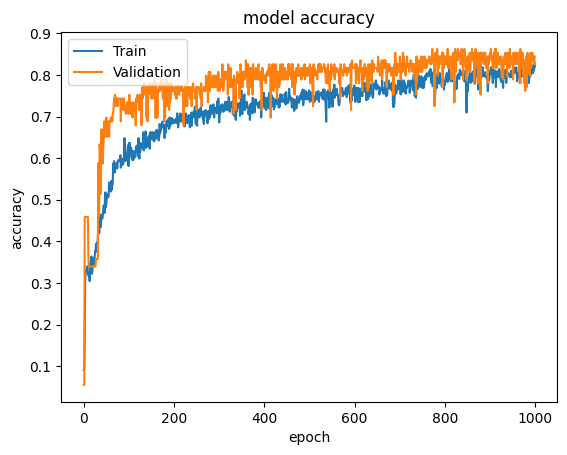

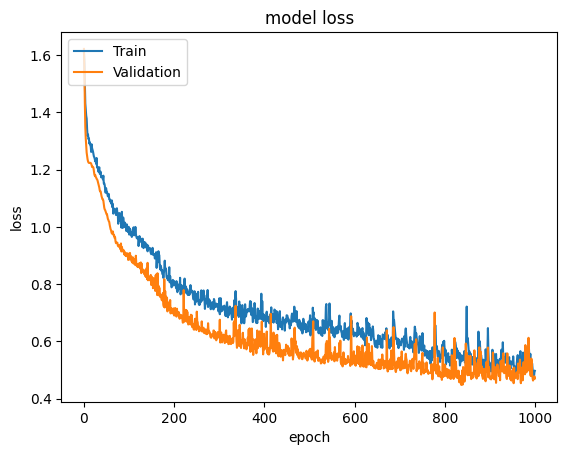

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 14ms/step - loss: 0.6992 - accuracy: 0.6881


[0.6992238759994507, 0.6880733966827393]

In [ ]:
prediction = model.predict(test_data)
pred_result = []
for i in range(len(prediction)):
  index = np.argmax(prediction[i])
  pred_result.append(index)


4/4 [==============================] - 1s 12ms/step


In [ ]:
tf.math.confusion_matrix(
    test_labels,
    pred_result,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[13,  6,  6,  0],
       [ 8, 31,  8,  1],
       [ 2,  0, 28,  1],
       [ 0,  2,  0,  3]], dtype=int32)>

In [ ]:
from pathlib import Path
import shutil
import PIL
import math
import glob
import json
import os


In [ ]:
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "project")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "project_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "project.tflite")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "project.cc")

In [ ]:
model.save(SAVED_MODEL_FILENAME)

In [ ]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
print(size_tf)

879403


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for i in range(50):
    # input_value = tf.cast(input_value, tf.float32)
    # input_value = tf.convert_to_tensor(np.transpose([input_value]), dtype=None, dtype_hint=None, name=None)
    # print(tf.shape(input_value))
    # print(tf.size(input_value))
    input_data = np.array(train_data[i], dtype=np.float32).reshape((1,data.shape[1], 1 ))
    
    yield [input_data]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS] #Fill this
converter.inference_input_type = tf.int8 #Fill this
converter.inference_output_type = tf.int8 # Fill this

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()


In [ ]:
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(tflite_model)
size_quantised_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)
print(size_quantised_tflite)

17520


In [ ]:
test_data = pd.read_csv('/content/Test_data.csv', header=None)
pred_result = []
raw_test_data = test_data.values
actual_result = raw_test_data[0, :]
for i in range(raw_test_data.shape[1]):
  single_test = raw_test_data[:, i]
  single_test = np.transpose([single_test])
  initial_data_only = single_test[1:, :]
  labels = single_test[0, :]
  new_data = np.array(slicing_data(initial_data_only, 80, labels))
  y = np.concatenate((new_data[0],new_data[1]), axis = 1)
  for i in range(len(new_data) - 2):
    y = np.concatenate((y,new_data[i+2]), axis = 1)
  y_float = [y[0]]
  for i in range(len(y)-1):
    int_row = [(float(k)) for k in y[i+1]]
    y_float = np.concatenate((y_float,[int_row]))
  print(y_float.shape[1])
  index_to_remove = []
  for j in range(y_float.shape[1]):
    for k in range(y_float.shape[0] - 1):
      if np.isnan(y_float[k + 1, j]):
        index_to_remove.append(j)
        break
 
  remove_nan = np.array([y_float[:, 0]]).T
  #remove_nan = remove_nan[:,np.newaxis]
  for j in range(y_float.shape[1]-1):
    if index_to_remove.count(j+1) == 0 :
      remove_nan = np.concatenate((remove_nan,np.transpose([y_float[:, j+1]])), axis = 1)
  int_row1 = [(int(k)) for k in remove_nan[0]]
  int_row2 = [(int(k)) for k in remove_nan[1]]
  new_remove_nan = np.concatenate(([int_row1],[int_row2]))

  for i in range(len(remove_nan)-2):
    int_row = [(int(k)) for k in remove_nan[i+2]]
    #print(int_row)
    new_remove_nan = np.concatenate((new_remove_nan,[int_row]))
  data = new_remove_nan[1:, :]
  labels = new_remove_nan[0, :]
  data = data.T
  labels = labels.T
  prediction = model.predict(data)
  pred = []
  for i in range(len(prediction)):
    index = np.argmax(prediction[i])
    pred.append(index)
  res = max(set(pred), key = pred.count)
  pred_result.append(res)


print(pred_result)
def test_accuracy(prediction, actual):
  counter = 0
  for i in range(len(prediction)):
    if prediction[i] == actual[i]:
      counter = counter + 1
  acc = (counter / len(prediction)) *100.0 
  return acc

print(test_accuracy(pred_result, actual_result))


35
1/1 [==============================] - 0s 29ms/step
35
1/1 [==============================] - 0s 30ms/step
35
1/1 [==============================] - 0s 33ms/step
35
1/1 [==============================] - 0s 25ms/step
35
1/1 [==============================] - 0s 27ms/step
35
1/1 [==============================] - 0s 29ms/step
35
1/1 [==============================] - 0s 33ms/step
35
1/1 [==============================] - 0s 26ms/step
35
2/2 [==============================] - 0s 10ms/step
[2, 0, 0, 1, 1, 1, 2, 0, 2]
77.77777777777779


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

In [ ]:
# Print the C source file
!cat {TFL_CC_MODEL_FILENAME}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)

unsigned char g_magic_wand_model_data[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x80, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00,
  0x54, 0x18, 0x00, 0x00, 0x64, 0x18, 0x00, 0x00, 0x38, 0x42, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xaa, 0xcd, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x24, 0xcf, 0xff, 0xff,
  0x23, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x37, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xae, 0xcd, 0xff, 0xff, 0x04, 0x00, 0x00, 